# TP 2 - algoritmos de ensambles 

El objetivo de este trabajo práctico es analizar las particularidades de la utilización de algoritmos de ensambles aplicados en casos casi reales. El mismo pretende fijar conceptos estudiados en la teoría: métodos de ensamble; random forests; boosting; sobreajuste; tolerancia al ruido. El material básico para la elaboración del presente trabajo se encuentra en las teóricas y prácticas presentadas hasta el momento y en las próximas clases y en las referencias bibliográficas indicadas [1,2,3]. Podrá utilizarse cualquier otra fuente siempre que esté correctamente referenciada.
El presente trabajo será grupal. El grupo deberá estar compuesto por exactamente tres integrantes. Se evaluarán los contenidos del Trabajo Práctico durante el coloquio posterior a la entrega del TP junto al material teórico y práctico enseñado en las clases de toda la materia. Todos los integrantes deben tener conocimiento del desarrollo del TP.

**Opcionales (dan puntos extra)**:

* Sumar al punto c) un modelo de perceptrón multicapa.
* Evaluar el desempeño de los modelos al utilizar el conjunto de atributos ComParE 2016.

**La fecha límite de entrega es el lunes 28 de junio a las 17:00 hs.**

**tbd** 
* Sacar a otro notebook la búsqueda de hiperparámetros de adabost, randomforest y bagging
* Sacar a otro notebook el entrenamiento del perceptron

## Cargar librerias


In [1]:
import datetime
import IPython
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sweetviz as sv
import time
from matplotlib import pyplot
from numpy import mean
from numpy import std
from urllib.parse import urlparse

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [28]:
from imblearn.over_sampling import SMOTE
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.calibration import calibration_curve
from sklearn.impute import KNNImputer
from sklearn.feature_selection import RFE
from sklearn.metrics import (
    roc_curve,
    make_scorer,
    accuracy_score,
    fbeta_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold,
    KFold,
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedStratifiedKFold,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree


In [3]:
# # Observación: Descomentar en caso de que quieran versionar los modelos y la búsqueda de hiperparámetros.
# import mlflow
# import mlflow.sklearn
# from mlflow.tracking import MlflowClient

## Cargar dataset

In [4]:
df_original = pd.read_csv("01.df.procesado.csv")
df_original.head()

Unnamed: 0                                          file_path  modality  \
0           0  ./audios/ravdess/Actor_23/03-01-07-02-02-01-23...         3   
1           1  ./audios/ravdess/Actor_23/03-02-03-02-02-01-23...         3   
2           2  ./audios/ravdess/Actor_23/03-01-04-01-02-01-23...         3   
3           3  ./audios/ravdess/Actor_23/03-02-04-02-02-01-23...         3   
4           4  ./audios/ravdess/Actor_23/03-01-02-02-02-02-23...         3   

   vocal_channel  emotion  emotional_intensity  statement  repetition  actor  \
0              1        7                    2          2           1     23   
1              2        3                    2          2           1     23   
2              1        4                    1          2           1     23   
3              2        4                    2          2           1     23   
4              1        2                    2          2           2     23   

             start  ... slopeUV0-500_sma3nz_amean  \
0  0 days 00:00:00  ...                  0.075190   
1  0 days 00:00:00  ...                  0.020998   
2  0 days 00:00:00  ...                  0.047365   
3  0 days 00:00:00  ...                  0.041743   
4  0 days 00:00:00  ...                  0.053580   

   slopeUV500-1500_sma3nz_amean  spectralFluxUV_sma3nz_amean  \
0                      0.014015                     0.022255   
1                      0.009869                     0.018871   
2                      0.011048                     0.011381   
3                      0.012340                     0.007390   
4                      0.011590                     0.005245   

   loudnessPeaksPerSec  VoicedSegmentsPerSec  MeanVoicedSegmentLengthSec  \
0             2.150538              1.089918                      0.2825   
1             1.492537              0.646552                      0.8200   
2             2.247191              0.569801                      0.5900   
3             1.394422              0.603622                      0.9300   
4             1.535088              0.886918                      0.3875   

   StddevVoicedSegmentLengthSec  MeanUnvoicedSegmentLength  \
0                      0.126763                     0.4900   
1                      0.277248                     0.5275   
2                      0.160000                     0.7600   
3                      0.885701                     0.5275   
4                      0.206079                     0.5740   

   StddevUnvoicedSegmentLength  equivalentSoundLevel_dBp  
0                     0.397291                -36.658245  
1                     0.438770                -29.391884  
2                     0.296985                -43.332924  
3                     0.420260                -37.549572  
4                     0.424999                -43.261425  

[5 rows x 99 columns]

In [18]:
num_columns = [col for col in df_original.columns if df_original[col].dtype != "object"]
num_columns

['Unnamed: 0',
 'modality',
 'vocal_channel',
 'emotion',
 'emotional_intensity',
 'statement',
 'repetition',
 'actor',
 'F0semitoneFrom27.5Hz_sma3nz_amean',
 'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
 'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope',
 'loudness_sma3_amean',
 'loudness_sma3_stddevNorm',
 'loudness_sma3_percentile20.0',
 'loudness_sma3_percentile50.0',
 'loudness_sma3_percentile80.0',
 'loudness_sma3_pctlrange0-2',
 'loudness_sma3_meanRisingSlope',
 'loudness_sma3_stddevRisingSlope',
 'loudness_sma3_meanFallingSlope',
 'loudness_sma3_stddevFallingSlope',
 'spectralFlux_sma3_amean',
 'spectralFlux_sma3_stddevNorm',
 'mfcc1_sma3_amean',
 'mfcc1

In [19]:
drop_columns = [
    "file_path",
    "Unnamed: 0",
    "modality",
    "vocal_channel",
#     "emotion",
    "emotional_intensity",
    "statement",
    "repetition",
    "actor",
]
num_columns = [x for x in num_columns if x not in drop_columns]
num_columns

['emotion',
 'F0semitoneFrom27.5Hz_sma3nz_amean',
 'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
 'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope',
 'loudness_sma3_amean',
 'loudness_sma3_stddevNorm',
 'loudness_sma3_percentile20.0',
 'loudness_sma3_percentile50.0',
 'loudness_sma3_percentile80.0',
 'loudness_sma3_pctlrange0-2',
 'loudness_sma3_meanRisingSlope',
 'loudness_sma3_stddevRisingSlope',
 'loudness_sma3_meanFallingSlope',
 'loudness_sma3_stddevFallingSlope',
 'spectralFlux_sma3_amean',
 'spectralFlux_sma3_stddevNorm',
 'mfcc1_sma3_amean',
 'mfcc1_sma3_stddevNorm',
 'mfcc2_sma3_amean',
 'mfcc2_sma3_stddevNorm',
 'mfcc3_sma3_amean',
 'mfcc3_sma3_stddevNor

In [20]:
df_proc = df_original[num_columns] #.head(10000)

## Split del dataset

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_proc.loc[:, df_proc.columns != "emotion"],
    df_proc["emotion"],
    stratify=df_proc["emotion"],
    random_state=66,
)

## Desarrollo de modelos de ensamble

B) Elegir un modelo de ensamble visto durante las clases y entrenarlo para predecir emociones dividiendo el dataset de las siguientes maneras:
    i) 12-fold cross validation armando los folds de forma aleatoria.
    ii) Leave-2-speakers out. Es decir, 12 folds conteniendo cada uno 2 actores distintos. Se recomienda utilizar la función de sklearn LeaveOneGroupOut

Reportar los resultados obtenidos y realizar un análisis de los mismos, teniendo en cuenta las características del dataset utilizado.

### Métricas

f1? o accuracy?

Si no está desbalanceado accuracy puede ser bien. 

F1 es un poco más robusta, pensando en que tiene en cuenta recall y precision.

No hay elementos que inclinen la balanza.

<BarContainer object of 8 artists>

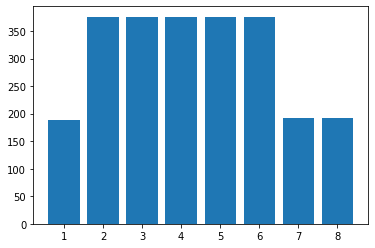

In [23]:
plt.bar(
    df_proc.groupby(["emotion"]).loudness_sma3_amean.count().index,
    df_proc.groupby(["emotion"]).loudness_sma3_amean.count(),
)

### Método elegido

Bagging con n árboles


### Árboles y búsqueda de hiperparámetros

Random search en 5000 árboles. Guardar esos 5000 en un pickle/csv para recuperarlo rápido. Quedarnos con el top 100.

#### Búsqueda de parámetros

##### Cantidad parametros

Podemos usar el logaritmo en base de dos de la cantidad de datos que tenemos para poder estimar la profundidad a partir de la cual overfiteamos el árbol.


In [ ]:
clfs = []
ccp_alphas = np.linspace(0, 0.001, 200)
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(x_train, y_train)
    clfs.append(clf)
print(
    "Cantidad de nodos en el último árbol: {} con ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

In [ ]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("Alpha")
ax[0].set_ylabel("Número de nodos")
ax[0].set_title("Número de nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("Alpha")
ax[1].set_ylabel("Profundidad del árbol")
ax[1].set_title("Profundidad vs alpha")
fig.tight_layout()

In [ ]:
train_scores = [clf.score(x_train, y_train) for clf in clfs]
test_scores = [clf.score(x_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("Alpha")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs alpha en train y test")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

#### Setup mlflow
Mlflow es una herramienta para versionado de modelos. Permite registrar paramétros, métricas y guardar los modelos entrenados asociados a una iteración.

En caso de no ser necesario comentar estas lineas.

In [25]:
# now = datetime.datetime.now()
# mlflow.set_tracking_uri("http://mlflow_server:5000")
# tracking_uri = mlflow.get_tracking_uri()
# print("Current tracking uri: {}".format(tracking_uri))

Current tracking uri: http://mlflow_server:5000


In [26]:
# # No hace falta el create, el set lo crea si no existe
# experiment = mlflow.set_experiment(
#     "AA.TP2.RandomizedSearchCV.{0}".format(now.strftime("%Y-%m-%d"))
# )

INFO: 'AA.TP2.RandomizedSearchCV.2021-06-24' does not exist. Creating a new experiment


### Busqueda de árboles

In [ ]:
start = time.time()
# Uno podría pasar una distribución para la busqueda de hiperparámetros
# Ref de criterios -> https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680
params_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None], # list(range(1, 13)),
    "ccp_alpha": np.linspace(0, 0.001, 2000),
    "min_samples_leaf": list(range(2, 4)),
    # cuantas muestras en nodo para poder hacer el split -> https://youtu.be/XABw4Y3GBR4?t=260
    # 'min_samples_split': list(range(2,6))
}

kfoldcv = StratifiedKFold(n_splits=12)
# base_tree = DecisionTreeClassifier(class_weight="balanced")
base_tree = DecisionTreeClassifier()
# F1 score
scorer_fn = make_scorer(f1_score)
randomcv = RandomizedSearchCV(
    estimator=base_tree,
    param_distributions=params_grid,
    scoring=scorer_fn,
    cv=kfoldcv,
    n_iter=2,
    verbose=10,
)
randomcv.fit(X_train, y_train)

end = time.time()

Fitting 12 folds for each of 5000 candidates, totalling 60000 fits
[CV 1/12; 1/5000] START ccp_alpha=0.0008544272136068034, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 1/5000] END ccp_alpha=0.0008544272136068034, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 1/5000] START ccp_alpha=0.0008544272136068034, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 1/5000] END ccp_alpha=0.0008544272136068034, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 1/5000] START ccp_alpha=0.0008544272136068034, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 1/5000] END ccp_alpha=0.0008544272136068034, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 1/5000] START ccp_alpha=0.0008544272136068034, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 1/5000] END ccp_alpha=0.0008544272136068034, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 1/5000] START ccp_alpha=0.0008544272136068034, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 1/5000] END ccp_alpha=0.0008544272136068034, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 1/5000] START ccp_alpha=0.0008544272136068034, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 1/5000] END ccp_alpha=0.0008544272136068034, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 1/5000] START ccp_alpha=0.0008544272136068034, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 1/5000] END ccp_alpha=0.0008544272136068034, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 1/5000] START ccp_alpha=0.0008544272136068034, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 1/5000] END ccp_alpha=0.0008544272136068034, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 1/5000] START ccp_alpha=0.0008544272136068034, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 1/5000] END ccp_alpha=0.0008544272136068034, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 1/5000] START ccp_alpha=0.0008544272136068034, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 1/5000] END ccp_alpha=0.0008544272136068034, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 1/5000] START ccp_alpha=0.0008544272136068034, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 1/5000] END ccp_alpha=0.0008544272136068034, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 1/5000] START ccp_alpha=0.0008544272136068034, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 1/5000] END ccp_alpha=0.0008544272136068034, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 1/12; 2/5000] START ccp_alpha=0.0007318659329664833, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 2/5000] END ccp_alpha=0.0007318659329664833, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 2/5000] START ccp_alpha=0.0007318659329664833, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 2/5000] END ccp_alpha=0.0007318659329664833, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 2/5000] START ccp_alpha=0.0007318659329664833, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 2/5000] END ccp_alpha=0.0007318659329664833, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 2/5000] START ccp_alpha=0.0007318659329664833, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 2/5000] END ccp_alpha=0.0007318659329664833, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 2/5000] START ccp_alpha=0.0007318659329664833, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 2/5000] END ccp_alpha=0.0007318659329664833, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 2/5000] START ccp_alpha=0.0007318659329664833, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 2/5000] END ccp_alpha=0.0007318659329664833, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 2/5000] START ccp_alpha=0.0007318659329664833, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 2/5000] END ccp_alpha=0.0007318659329664833, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 2/5000] START ccp_alpha=0.0007318659329664833, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 2/5000] END ccp_alpha=0.0007318659329664833, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 2/5000] START ccp_alpha=0.0007318659329664833, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 2/5000] END ccp_alpha=0.0007318659329664833, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 2/5000] START ccp_alpha=0.0007318659329664833, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 2/5000] END ccp_alpha=0.0007318659329664833, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 2/5000] START ccp_alpha=0.0007318659329664833, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 2/5000] END ccp_alpha=0.0007318659329664833, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 2/5000] START ccp_alpha=0.0007318659329664833, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 2/5000] END ccp_alpha=0.0007318659329664833, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 1/12; 3/5000] START ccp_alpha=0.0007978989494747373, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 3/5000] END ccp_alpha=0.0007978989494747373, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 2/12; 3/5000] START ccp_alpha=0.0007978989494747373, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 3/5000] END ccp_alpha=0.0007978989494747373, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 3/12; 3/5000] START ccp_alpha=0.0007978989494747373, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 3/5000] END ccp_alpha=0.0007978989494747373, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 4/12; 3/5000] START ccp_alpha=0.0007978989494747373, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 3/5000] END ccp_alpha=0.0007978989494747373, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 5/12; 3/5000] START ccp_alpha=0.0007978989494747373, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 3/5000] END ccp_alpha=0.0007978989494747373, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 6/12; 3/5000] START ccp_alpha=0.0007978989494747373, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 3/5000] END ccp_alpha=0.0007978989494747373, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 7/12; 3/5000] START ccp_alpha=0.0007978989494747373, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 3/5000] END ccp_alpha=0.0007978989494747373, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 8/12; 3/5000] START ccp_alpha=0.0007978989494747373, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 3/5000] END ccp_alpha=0.0007978989494747373, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 9/12; 3/5000] START ccp_alpha=0.0007978989494747373, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 3/5000] END ccp_alpha=0.0007978989494747373, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 10/12; 3/5000] START ccp_alpha=0.0007978989494747373, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 3/5000] END ccp_alpha=0.0007978989494747373, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 11/12; 3/5000] START ccp_alpha=0.0007978989494747373, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 3/5000] END ccp_alpha=0.0007978989494747373, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 12/12; 3/5000] START ccp_alpha=0.0007978989494747373, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 3/5000] END ccp_alpha=0.0007978989494747373, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 1/12; 4/5000] START ccp_alpha=0.0009469734867433717, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 4/5000] END ccp_alpha=0.0009469734867433717, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 2/12; 4/5000] START ccp_alpha=0.0009469734867433717, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 4/5000] END ccp_alpha=0.0009469734867433717, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 3/12; 4/5000] START ccp_alpha=0.0009469734867433717, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 4/5000] END ccp_alpha=0.0009469734867433717, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 4/12; 4/5000] START ccp_alpha=0.0009469734867433717, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 4/5000] END ccp_alpha=0.0009469734867433717, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 5/12; 4/5000] START ccp_alpha=0.0009469734867433717, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 4/5000] END ccp_alpha=0.0009469734867433717, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 6/12; 4/5000] START ccp_alpha=0.0009469734867433717, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 4/5000] END ccp_alpha=0.0009469734867433717, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 7/12; 4/5000] START ccp_alpha=0.0009469734867433717, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 4/5000] END ccp_alpha=0.0009469734867433717, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 8/12; 4/5000] START ccp_alpha=0.0009469734867433717, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 4/5000] END ccp_alpha=0.0009469734867433717, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 9/12; 4/5000] START ccp_alpha=0.0009469734867433717, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 4/5000] END ccp_alpha=0.0009469734867433717, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 10/12; 4/5000] START ccp_alpha=0.0009469734867433717, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 4/5000] END ccp_alpha=0.0009469734867433717, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 11/12; 4/5000] START ccp_alpha=0.0009469734867433717, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 4/5000] END ccp_alpha=0.0009469734867433717, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 12/12; 4/5000] START ccp_alpha=0.0009469734867433717, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 4/5000] END ccp_alpha=0.0009469734867433717, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 1/12; 5/5000] START ccp_alpha=0.0002801400700350175, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 5/5000] END ccp_alpha=0.0002801400700350175, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 5/5000] START ccp_alpha=0.0002801400700350175, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 5/5000] END ccp_alpha=0.0002801400700350175, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 5/5000] START ccp_alpha=0.0002801400700350175, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 5/5000] END ccp_alpha=0.0002801400700350175, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 5/5000] START ccp_alpha=0.0002801400700350175, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 5/5000] END ccp_alpha=0.0002801400700350175, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 5/5000] START ccp_alpha=0.0002801400700350175, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 5/5000] END ccp_alpha=0.0002801400700350175, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 5/5000] START ccp_alpha=0.0002801400700350175, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 5/5000] END ccp_alpha=0.0002801400700350175, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 5/5000] START ccp_alpha=0.0002801400700350175, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 5/5000] END ccp_alpha=0.0002801400700350175, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 5/5000] START ccp_alpha=0.0002801400700350175, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 5/5000] END ccp_alpha=0.0002801400700350175, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 5/5000] START ccp_alpha=0.0002801400700350175, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 5/5000] END ccp_alpha=0.0002801400700350175, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 10/12; 5/5000] START ccp_alpha=0.0002801400700350175, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 5/5000] END ccp_alpha=0.0002801400700350175, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 5/5000] START ccp_alpha=0.0002801400700350175, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 5/5000] END ccp_alpha=0.0002801400700350175, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 12/12; 5/5000] START ccp_alpha=0.0002801400700350175, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 5/5000] END ccp_alpha=0.0002801400700350175, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 1/12; 6/5000] START ccp_alpha=0.0009294647323661831, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 6/5000] END ccp_alpha=0.0009294647323661831, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 6/5000] START ccp_alpha=0.0009294647323661831, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 6/5000] END ccp_alpha=0.0009294647323661831, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 3/12; 6/5000] START ccp_alpha=0.0009294647323661831, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 6/5000] END ccp_alpha=0.0009294647323661831, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 4/12; 6/5000] START ccp_alpha=0.0009294647323661831, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 6/5000] END ccp_alpha=0.0009294647323661831, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 5/12; 6/5000] START ccp_alpha=0.0009294647323661831, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 6/5000] END ccp_alpha=0.0009294647323661831, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 6/12; 6/5000] START ccp_alpha=0.0009294647323661831, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 6/5000] END ccp_alpha=0.0009294647323661831, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 7/12; 6/5000] START ccp_alpha=0.0009294647323661831, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 6/5000] END ccp_alpha=0.0009294647323661831, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 8/12; 6/5000] START ccp_alpha=0.0009294647323661831, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 6/5000] END ccp_alpha=0.0009294647323661831, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 9/12; 6/5000] START ccp_alpha=0.0009294647323661831, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 6/5000] END ccp_alpha=0.0009294647323661831, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 10/12; 6/5000] START ccp_alpha=0.0009294647323661831, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 6/5000] END ccp_alpha=0.0009294647323661831, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 11/12; 6/5000] START ccp_alpha=0.0009294647323661831, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 6/5000] END ccp_alpha=0.0009294647323661831, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 12/12; 6/5000] START ccp_alpha=0.0009294647323661831, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 6/5000] END ccp_alpha=0.0009294647323661831, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 1/12; 7/5000] START ccp_alpha=0.0001915957978989495, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 7/5000] END ccp_alpha=0.0001915957978989495, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 7/5000] START ccp_alpha=0.0001915957978989495, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 7/5000] END ccp_alpha=0.0001915957978989495, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 3/12; 7/5000] START ccp_alpha=0.0001915957978989495, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 7/5000] END ccp_alpha=0.0001915957978989495, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 4/12; 7/5000] START ccp_alpha=0.0001915957978989495, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 7/5000] END ccp_alpha=0.0001915957978989495, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.6s
[CV 5/12; 7/5000] START ccp_alpha=0.0001915957978989495, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 7/5000] END ccp_alpha=0.0001915957978989495, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.6s
[CV 6/12; 7/5000] START ccp_alpha=0.0001915957978989495, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 7/5000] END ccp_alpha=0.0001915957978989495, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 7/5000] START ccp_alpha=0.0001915957978989495, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 7/5000] END ccp_alpha=0.0001915957978989495, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 8/12; 7/5000] START ccp_alpha=0.0001915957978989495, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 7/5000] END ccp_alpha=0.0001915957978989495, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 7/5000] START ccp_alpha=0.0001915957978989495, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 7/5000] END ccp_alpha=0.0001915957978989495, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 10/12; 7/5000] START ccp_alpha=0.0001915957978989495, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 7/5000] END ccp_alpha=0.0001915957978989495, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 7/5000] START ccp_alpha=0.0001915957978989495, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 7/5000] END ccp_alpha=0.0001915957978989495, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 7/5000] START ccp_alpha=0.0001915957978989495, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 7/5000] END ccp_alpha=0.0001915957978989495, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 1/12; 8/5000] START ccp_alpha=0.0006738369184592296, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 8/5000] END ccp_alpha=0.0006738369184592296, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 8/5000] START ccp_alpha=0.0006738369184592296, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 8/5000] END ccp_alpha=0.0006738369184592296, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 8/5000] START ccp_alpha=0.0006738369184592296, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 8/5000] END ccp_alpha=0.0006738369184592296, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 8/5000] START ccp_alpha=0.0006738369184592296, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 8/5000] END ccp_alpha=0.0006738369184592296, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 5/12; 8/5000] START ccp_alpha=0.0006738369184592296, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 8/5000] END ccp_alpha=0.0006738369184592296, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 6/12; 8/5000] START ccp_alpha=0.0006738369184592296, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 8/5000] END ccp_alpha=0.0006738369184592296, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 8/5000] START ccp_alpha=0.0006738369184592296, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 8/5000] END ccp_alpha=0.0006738369184592296, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 8/5000] START ccp_alpha=0.0006738369184592296, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 8/5000] END ccp_alpha=0.0006738369184592296, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 8/5000] START ccp_alpha=0.0006738369184592296, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 8/5000] END ccp_alpha=0.0006738369184592296, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 8/5000] START ccp_alpha=0.0006738369184592296, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 8/5000] END ccp_alpha=0.0006738369184592296, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 8/5000] START ccp_alpha=0.0006738369184592296, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 8/5000] END ccp_alpha=0.0006738369184592296, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 12/12; 8/5000] START ccp_alpha=0.0006738369184592296, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 8/5000] END ccp_alpha=0.0006738369184592296, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 1/12; 9/5000] START ccp_alpha=0.0005347673836918459, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 9/5000] END ccp_alpha=0.0005347673836918459, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 9/5000] START ccp_alpha=0.0005347673836918459, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 9/5000] END ccp_alpha=0.0005347673836918459, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 9/5000] START ccp_alpha=0.0005347673836918459, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 9/5000] END ccp_alpha=0.0005347673836918459, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 9/5000] START ccp_alpha=0.0005347673836918459, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 9/5000] END ccp_alpha=0.0005347673836918459, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 9/5000] START ccp_alpha=0.0005347673836918459, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 9/5000] END ccp_alpha=0.0005347673836918459, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 9/5000] START ccp_alpha=0.0005347673836918459, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 9/5000] END ccp_alpha=0.0005347673836918459, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 9/5000] START ccp_alpha=0.0005347673836918459, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 9/5000] END ccp_alpha=0.0005347673836918459, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 9/5000] START ccp_alpha=0.0005347673836918459, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 9/5000] END ccp_alpha=0.0005347673836918459, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 9/5000] START ccp_alpha=0.0005347673836918459, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 9/5000] END ccp_alpha=0.0005347673836918459, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 9/5000] START ccp_alpha=0.0005347673836918459, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 9/5000] END ccp_alpha=0.0005347673836918459, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 9/5000] START ccp_alpha=0.0005347673836918459, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 9/5000] END ccp_alpha=0.0005347673836918459, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 9/5000] START ccp_alpha=0.0005347673836918459, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 9/5000] END ccp_alpha=0.0005347673836918459, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 1/12; 10/5000] START ccp_alpha=0.000375687843921961, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 10/5000] END ccp_alpha=0.000375687843921961, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 2/12; 10/5000] START ccp_alpha=0.000375687843921961, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 10/5000] END ccp_alpha=0.000375687843921961, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 3/12; 10/5000] START ccp_alpha=0.000375687843921961, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 10/5000] END ccp_alpha=0.000375687843921961, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 4/12; 10/5000] START ccp_alpha=0.000375687843921961, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 10/5000] END ccp_alpha=0.000375687843921961, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 5/12; 10/5000] START ccp_alpha=0.000375687843921961, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 10/5000] END ccp_alpha=0.000375687843921961, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 6/12; 10/5000] START ccp_alpha=0.000375687843921961, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 10/5000] END ccp_alpha=0.000375687843921961, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 7/12; 10/5000] START ccp_alpha=0.000375687843921961, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 10/5000] END ccp_alpha=0.000375687843921961, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 8/12; 10/5000] START ccp_alpha=0.000375687843921961, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 10/5000] END ccp_alpha=0.000375687843921961, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 9/12; 10/5000] START ccp_alpha=0.000375687843921961, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 10/5000] END ccp_alpha=0.000375687843921961, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 10/12; 10/5000] START ccp_alpha=0.000375687843921961, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 10/5000] END ccp_alpha=0.000375687843921961, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 11/12; 10/5000] START ccp_alpha=0.000375687843921961, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 10/5000] END ccp_alpha=0.000375687843921961, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 12/12; 10/5000] START ccp_alpha=0.000375687843921961, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 10/5000] END ccp_alpha=0.000375687843921961, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 1/12; 11/5000] START ccp_alpha=9.854927463731866e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 11/5000] END ccp_alpha=9.854927463731866e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 11/5000] START ccp_alpha=9.854927463731866e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 11/5000] END ccp_alpha=9.854927463731866e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 3/12; 11/5000] START ccp_alpha=9.854927463731866e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 11/5000] END ccp_alpha=9.854927463731866e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 4/12; 11/5000] START ccp_alpha=9.854927463731866e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 11/5000] END ccp_alpha=9.854927463731866e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 5/12; 11/5000] START ccp_alpha=9.854927463731866e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 11/5000] END ccp_alpha=9.854927463731866e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 6/12; 11/5000] START ccp_alpha=9.854927463731866e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 11/5000] END ccp_alpha=9.854927463731866e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 7/12; 11/5000] START ccp_alpha=9.854927463731866e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 11/5000] END ccp_alpha=9.854927463731866e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 8/12; 11/5000] START ccp_alpha=9.854927463731866e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 11/5000] END ccp_alpha=9.854927463731866e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 9/12; 11/5000] START ccp_alpha=9.854927463731866e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 11/5000] END ccp_alpha=9.854927463731866e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 10/12; 11/5000] START ccp_alpha=9.854927463731866e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 11/5000] END ccp_alpha=9.854927463731866e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 11/12; 11/5000] START ccp_alpha=9.854927463731866e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 11/5000] END ccp_alpha=9.854927463731866e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 12/12; 11/5000] START ccp_alpha=9.854927463731866e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 11/5000] END ccp_alpha=9.854927463731866e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 1/12; 12/5000] START ccp_alpha=9.304652326163082e-05, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 12/5000] END ccp_alpha=9.304652326163082e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 2/12; 12/5000] START ccp_alpha=9.304652326163082e-05, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 12/5000] END ccp_alpha=9.304652326163082e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 12/5000] START ccp_alpha=9.304652326163082e-05, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 12/5000] END ccp_alpha=9.304652326163082e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 12/5000] START ccp_alpha=9.304652326163082e-05, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 12/5000] END ccp_alpha=9.304652326163082e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 12/5000] START ccp_alpha=9.304652326163082e-05, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 12/5000] END ccp_alpha=9.304652326163082e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 12/5000] START ccp_alpha=9.304652326163082e-05, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 12/5000] END ccp_alpha=9.304652326163082e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 12/5000] START ccp_alpha=9.304652326163082e-05, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 12/5000] END ccp_alpha=9.304652326163082e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 12/5000] START ccp_alpha=9.304652326163082e-05, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 12/5000] END ccp_alpha=9.304652326163082e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 12/5000] START ccp_alpha=9.304652326163082e-05, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 12/5000] END ccp_alpha=9.304652326163082e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 12/5000] START ccp_alpha=9.304652326163082e-05, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 12/5000] END ccp_alpha=9.304652326163082e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 12/5000] START ccp_alpha=9.304652326163082e-05, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 12/5000] END ccp_alpha=9.304652326163082e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 12/12; 12/5000] START ccp_alpha=9.304652326163082e-05, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 12/5000] END ccp_alpha=9.304652326163082e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 1/12; 13/5000] START ccp_alpha=7.553776888444222e-05, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 13/5000] END ccp_alpha=7.553776888444222e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 13/5000] START ccp_alpha=7.553776888444222e-05, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 13/5000] END ccp_alpha=7.553776888444222e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 13/5000] START ccp_alpha=7.553776888444222e-05, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 13/5000] END ccp_alpha=7.553776888444222e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 13/5000] START ccp_alpha=7.553776888444222e-05, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 13/5000] END ccp_alpha=7.553776888444222e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 13/5000] START ccp_alpha=7.553776888444222e-05, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 13/5000] END ccp_alpha=7.553776888444222e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 13/5000] START ccp_alpha=7.553776888444222e-05, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 13/5000] END ccp_alpha=7.553776888444222e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 7/12; 13/5000] START ccp_alpha=7.553776888444222e-05, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 13/5000] END ccp_alpha=7.553776888444222e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 13/5000] START ccp_alpha=7.553776888444222e-05, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 13/5000] END ccp_alpha=7.553776888444222e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 13/5000] START ccp_alpha=7.553776888444222e-05, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 13/5000] END ccp_alpha=7.553776888444222e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 10/12; 13/5000] START ccp_alpha=7.553776888444222e-05, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 13/5000] END ccp_alpha=7.553776888444222e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 11/12; 13/5000] START ccp_alpha=7.553776888444222e-05, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 13/5000] END ccp_alpha=7.553776888444222e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 12/12; 13/5000] START ccp_alpha=7.553776888444222e-05, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 13/5000] END ccp_alpha=7.553776888444222e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 1/12; 14/5000] START ccp_alpha=9.10455227613807e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 14/5000] END ccp_alpha=9.10455227613807e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 14/5000] START ccp_alpha=9.10455227613807e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 14/5000] END ccp_alpha=9.10455227613807e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 3/12; 14/5000] START ccp_alpha=9.10455227613807e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 14/5000] END ccp_alpha=9.10455227613807e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 4/12; 14/5000] START ccp_alpha=9.10455227613807e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 14/5000] END ccp_alpha=9.10455227613807e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 5/12; 14/5000] START ccp_alpha=9.10455227613807e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 14/5000] END ccp_alpha=9.10455227613807e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 6/12; 14/5000] START ccp_alpha=9.10455227613807e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 14/5000] END ccp_alpha=9.10455227613807e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 7/12; 14/5000] START ccp_alpha=9.10455227613807e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 14/5000] END ccp_alpha=9.10455227613807e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 8/12; 14/5000] START ccp_alpha=9.10455227613807e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 14/5000] END ccp_alpha=9.10455227613807e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 9/12; 14/5000] START ccp_alpha=9.10455227613807e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 14/5000] END ccp_alpha=9.10455227613807e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 10/12; 14/5000] START ccp_alpha=9.10455227613807e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 14/5000] END ccp_alpha=9.10455227613807e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 11/12; 14/5000] START ccp_alpha=9.10455227613807e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 14/5000] END ccp_alpha=9.10455227613807e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 12/12; 14/5000] START ccp_alpha=9.10455227613807e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 14/5000] END ccp_alpha=9.10455227613807e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 1/12; 15/5000] START ccp_alpha=0.00040270135067533766, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 15/5000] END ccp_alpha=0.00040270135067533766, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 2/12; 15/5000] START ccp_alpha=0.00040270135067533766, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 15/5000] END ccp_alpha=0.00040270135067533766, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 3/12; 15/5000] START ccp_alpha=0.00040270135067533766, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 15/5000] END ccp_alpha=0.00040270135067533766, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 4/12; 15/5000] START ccp_alpha=0.00040270135067533766, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 15/5000] END ccp_alpha=0.00040270135067533766, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 5/12; 15/5000] START ccp_alpha=0.00040270135067533766, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 15/5000] END ccp_alpha=0.00040270135067533766, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 6/12; 15/5000] START ccp_alpha=0.00040270135067533766, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 15/5000] END ccp_alpha=0.00040270135067533766, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 7/12; 15/5000] START ccp_alpha=0.00040270135067533766, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 15/5000] END ccp_alpha=0.00040270135067533766, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 8/12; 15/5000] START ccp_alpha=0.00040270135067533766, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 15/5000] END ccp_alpha=0.00040270135067533766, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 9/12; 15/5000] START ccp_alpha=0.00040270135067533766, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 15/5000] END ccp_alpha=0.00040270135067533766, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 10/12; 15/5000] START ccp_alpha=0.00040270135067533766, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 15/5000] END ccp_alpha=0.00040270135067533766, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 11/12; 15/5000] START ccp_alpha=0.00040270135067533766, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 15/5000] END ccp_alpha=0.00040270135067533766, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 12/12; 15/5000] START ccp_alpha=0.00040270135067533766, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 15/5000] END ccp_alpha=0.00040270135067533766, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 16/5000] START ccp_alpha=0.0007208604302151076, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 16/5000] END ccp_alpha=0.0007208604302151076, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 16/5000] START ccp_alpha=0.0007208604302151076, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 16/5000] END ccp_alpha=0.0007208604302151076, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 3/12; 16/5000] START ccp_alpha=0.0007208604302151076, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 16/5000] END ccp_alpha=0.0007208604302151076, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 4/12; 16/5000] START ccp_alpha=0.0007208604302151076, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 16/5000] END ccp_alpha=0.0007208604302151076, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 5/12; 16/5000] START ccp_alpha=0.0007208604302151076, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 16/5000] END ccp_alpha=0.0007208604302151076, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 6/12; 16/5000] START ccp_alpha=0.0007208604302151076, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 16/5000] END ccp_alpha=0.0007208604302151076, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 7/12; 16/5000] START ccp_alpha=0.0007208604302151076, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 16/5000] END ccp_alpha=0.0007208604302151076, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 8/12; 16/5000] START ccp_alpha=0.0007208604302151076, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 16/5000] END ccp_alpha=0.0007208604302151076, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 9/12; 16/5000] START ccp_alpha=0.0007208604302151076, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 16/5000] END ccp_alpha=0.0007208604302151076, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 10/12; 16/5000] START ccp_alpha=0.0007208604302151076, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 16/5000] END ccp_alpha=0.0007208604302151076, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 11/12; 16/5000] START ccp_alpha=0.0007208604302151076, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 16/5000] END ccp_alpha=0.0007208604302151076, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 12/12; 16/5000] START ccp_alpha=0.0007208604302151076, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 16/5000] END ccp_alpha=0.0007208604302151076, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 1/12; 17/5000] START ccp_alpha=0.0001310655327663832, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 17/5000] END ccp_alpha=0.0001310655327663832, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 17/5000] START ccp_alpha=0.0001310655327663832, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 17/5000] END ccp_alpha=0.0001310655327663832, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 3/12; 17/5000] START ccp_alpha=0.0001310655327663832, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 17/5000] END ccp_alpha=0.0001310655327663832, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 4/12; 17/5000] START ccp_alpha=0.0001310655327663832, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 17/5000] END ccp_alpha=0.0001310655327663832, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 5/12; 17/5000] START ccp_alpha=0.0001310655327663832, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 17/5000] END ccp_alpha=0.0001310655327663832, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 17/5000] START ccp_alpha=0.0001310655327663832, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 17/5000] END ccp_alpha=0.0001310655327663832, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 17/5000] START ccp_alpha=0.0001310655327663832, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 17/5000] END ccp_alpha=0.0001310655327663832, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 8/12; 17/5000] START ccp_alpha=0.0001310655327663832, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 17/5000] END ccp_alpha=0.0001310655327663832, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 17/5000] START ccp_alpha=0.0001310655327663832, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 17/5000] END ccp_alpha=0.0001310655327663832, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 10/12; 17/5000] START ccp_alpha=0.0001310655327663832, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 17/5000] END ccp_alpha=0.0001310655327663832, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 17/5000] START ccp_alpha=0.0001310655327663832, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 17/5000] END ccp_alpha=0.0001310655327663832, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 17/5000] START ccp_alpha=0.0001310655327663832, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 17/5000] END ccp_alpha=0.0001310655327663832, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 1/12; 18/5000] START ccp_alpha=6.853426713356679e-05, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 18/5000] END ccp_alpha=6.853426713356679e-05, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 2/12; 18/5000] START ccp_alpha=6.853426713356679e-05, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 18/5000] END ccp_alpha=6.853426713356679e-05, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 3/12; 18/5000] START ccp_alpha=6.853426713356679e-05, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 18/5000] END ccp_alpha=6.853426713356679e-05, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 4/12; 18/5000] START ccp_alpha=6.853426713356679e-05, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 18/5000] END ccp_alpha=6.853426713356679e-05, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 5/12; 18/5000] START ccp_alpha=6.853426713356679e-05, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 18/5000] END ccp_alpha=6.853426713356679e-05, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 6/12; 18/5000] START ccp_alpha=6.853426713356679e-05, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 18/5000] END ccp_alpha=6.853426713356679e-05, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 7/12; 18/5000] START ccp_alpha=6.853426713356679e-05, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 18/5000] END ccp_alpha=6.853426713356679e-05, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 8/12; 18/5000] START ccp_alpha=6.853426713356679e-05, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 18/5000] END ccp_alpha=6.853426713356679e-05, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 9/12; 18/5000] START ccp_alpha=6.853426713356679e-05, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 18/5000] END ccp_alpha=6.853426713356679e-05, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 10/12; 18/5000] START ccp_alpha=6.853426713356679e-05, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 18/5000] END ccp_alpha=6.853426713356679e-05, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 11/12; 18/5000] START ccp_alpha=6.853426713356679e-05, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 18/5000] END ccp_alpha=6.853426713356679e-05, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 12/12; 18/5000] START ccp_alpha=6.853426713356679e-05, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 18/5000] END ccp_alpha=6.853426713356679e-05, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 19/5000] START ccp_alpha=0.0009994997498749376, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 19/5000] END ccp_alpha=0.0009994997498749376, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 2/12; 19/5000] START ccp_alpha=0.0009994997498749376, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 19/5000] END ccp_alpha=0.0009994997498749376, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 3/12; 19/5000] START ccp_alpha=0.0009994997498749376, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 19/5000] END ccp_alpha=0.0009994997498749376, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 4/12; 19/5000] START ccp_alpha=0.0009994997498749376, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 19/5000] END ccp_alpha=0.0009994997498749376, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 5/12; 19/5000] START ccp_alpha=0.0009994997498749376, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 19/5000] END ccp_alpha=0.0009994997498749376, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 6/12; 19/5000] START ccp_alpha=0.0009994997498749376, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 19/5000] END ccp_alpha=0.0009994997498749376, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 7/12; 19/5000] START ccp_alpha=0.0009994997498749376, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 19/5000] END ccp_alpha=0.0009994997498749376, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 8/12; 19/5000] START ccp_alpha=0.0009994997498749376, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 19/5000] END ccp_alpha=0.0009994997498749376, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 9/12; 19/5000] START ccp_alpha=0.0009994997498749376, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 19/5000] END ccp_alpha=0.0009994997498749376, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 10/12; 19/5000] START ccp_alpha=0.0009994997498749376, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 19/5000] END ccp_alpha=0.0009994997498749376, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 11/12; 19/5000] START ccp_alpha=0.0009994997498749376, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 19/5000] END ccp_alpha=0.0009994997498749376, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 12/12; 19/5000] START ccp_alpha=0.0009994997498749376, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 19/5000] END ccp_alpha=0.0009994997498749376, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 1/12; 20/5000] START ccp_alpha=0.0008734367183591797, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 20/5000] END ccp_alpha=0.0008734367183591797, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 20/5000] START ccp_alpha=0.0008734367183591797, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 20/5000] END ccp_alpha=0.0008734367183591797, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 3/12; 20/5000] START ccp_alpha=0.0008734367183591797, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 20/5000] END ccp_alpha=0.0008734367183591797, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 4/12; 20/5000] START ccp_alpha=0.0008734367183591797, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 20/5000] END ccp_alpha=0.0008734367183591797, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 5/12; 20/5000] START ccp_alpha=0.0008734367183591797, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 20/5000] END ccp_alpha=0.0008734367183591797, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 20/5000] START ccp_alpha=0.0008734367183591797, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 20/5000] END ccp_alpha=0.0008734367183591797, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 20/5000] START ccp_alpha=0.0008734367183591797, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 20/5000] END ccp_alpha=0.0008734367183591797, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 8/12; 20/5000] START ccp_alpha=0.0008734367183591797, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 20/5000] END ccp_alpha=0.0008734367183591797, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 20/5000] START ccp_alpha=0.0008734367183591797, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 20/5000] END ccp_alpha=0.0008734367183591797, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 10/12; 20/5000] START ccp_alpha=0.0008734367183591797, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 20/5000] END ccp_alpha=0.0008734367183591797, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 20/5000] START ccp_alpha=0.0008734367183591797, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 20/5000] END ccp_alpha=0.0008734367183591797, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 20/5000] START ccp_alpha=0.0008734367183591797, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 20/5000] END ccp_alpha=0.0008734367183591797, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 1/12; 21/5000] START ccp_alpha=0.000647823911955978, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 21/5000] END ccp_alpha=0.000647823911955978, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 21/5000] START ccp_alpha=0.000647823911955978, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 21/5000] END ccp_alpha=0.000647823911955978, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 3/12; 21/5000] START ccp_alpha=0.000647823911955978, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 21/5000] END ccp_alpha=0.000647823911955978, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 4/12; 21/5000] START ccp_alpha=0.000647823911955978, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 21/5000] END ccp_alpha=0.000647823911955978, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 5/12; 21/5000] START ccp_alpha=0.000647823911955978, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 21/5000] END ccp_alpha=0.000647823911955978, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 21/5000] START ccp_alpha=0.000647823911955978, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 21/5000] END ccp_alpha=0.000647823911955978, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 21/5000] START ccp_alpha=0.000647823911955978, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 21/5000] END ccp_alpha=0.000647823911955978, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 8/12; 21/5000] START ccp_alpha=0.000647823911955978, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 21/5000] END ccp_alpha=0.000647823911955978, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 21/5000] START ccp_alpha=0.000647823911955978, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 21/5000] END ccp_alpha=0.000647823911955978, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 10/12; 21/5000] START ccp_alpha=0.000647823911955978, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 21/5000] END ccp_alpha=0.000647823911955978, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 21/5000] START ccp_alpha=0.000647823911955978, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 21/5000] END ccp_alpha=0.000647823911955978, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 21/5000] START ccp_alpha=0.000647823911955978, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 21/5000] END ccp_alpha=0.000647823911955978, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 1/12; 22/5000] START ccp_alpha=0.0004562281140570285, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 22/5000] END ccp_alpha=0.0004562281140570285, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 22/5000] START ccp_alpha=0.0004562281140570285, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 22/5000] END ccp_alpha=0.0004562281140570285, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 3/12; 22/5000] START ccp_alpha=0.0004562281140570285, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 22/5000] END ccp_alpha=0.0004562281140570285, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 4/12; 22/5000] START ccp_alpha=0.0004562281140570285, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 22/5000] END ccp_alpha=0.0004562281140570285, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 5/12; 22/5000] START ccp_alpha=0.0004562281140570285, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 22/5000] END ccp_alpha=0.0004562281140570285, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 6/12; 22/5000] START ccp_alpha=0.0004562281140570285, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 22/5000] END ccp_alpha=0.0004562281140570285, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 7/12; 22/5000] START ccp_alpha=0.0004562281140570285, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 22/5000] END ccp_alpha=0.0004562281140570285, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 8/12; 22/5000] START ccp_alpha=0.0004562281140570285, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 22/5000] END ccp_alpha=0.0004562281140570285, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 9/12; 22/5000] START ccp_alpha=0.0004562281140570285, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 22/5000] END ccp_alpha=0.0004562281140570285, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 10/12; 22/5000] START ccp_alpha=0.0004562281140570285, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 22/5000] END ccp_alpha=0.0004562281140570285, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 11/12; 22/5000] START ccp_alpha=0.0004562281140570285, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 22/5000] END ccp_alpha=0.0004562281140570285, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 12/12; 22/5000] START ccp_alpha=0.0004562281140570285, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 22/5000] END ccp_alpha=0.0004562281140570285, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 1/12; 23/5000] START ccp_alpha=0.00010005002501250626, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 23/5000] END ccp_alpha=0.00010005002501250626, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 23/5000] START ccp_alpha=0.00010005002501250626, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 23/5000] END ccp_alpha=0.00010005002501250626, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 3/12; 23/5000] START ccp_alpha=0.00010005002501250626, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 23/5000] END ccp_alpha=0.00010005002501250626, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 4/12; 23/5000] START ccp_alpha=0.00010005002501250626, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 23/5000] END ccp_alpha=0.00010005002501250626, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 5/12; 23/5000] START ccp_alpha=0.00010005002501250626, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 23/5000] END ccp_alpha=0.00010005002501250626, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 23/5000] START ccp_alpha=0.00010005002501250626, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 23/5000] END ccp_alpha=0.00010005002501250626, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 23/5000] START ccp_alpha=0.00010005002501250626, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 23/5000] END ccp_alpha=0.00010005002501250626, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 8/12; 23/5000] START ccp_alpha=0.00010005002501250626, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 23/5000] END ccp_alpha=0.00010005002501250626, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 23/5000] START ccp_alpha=0.00010005002501250626, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 23/5000] END ccp_alpha=0.00010005002501250626, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 10/12; 23/5000] START ccp_alpha=0.00010005002501250626, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 23/5000] END ccp_alpha=0.00010005002501250626, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 23/5000] START ccp_alpha=0.00010005002501250626, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 23/5000] END ccp_alpha=0.00010005002501250626, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 23/5000] START ccp_alpha=0.00010005002501250626, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 23/5000] END ccp_alpha=0.00010005002501250626, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 1/12; 24/5000] START ccp_alpha=0.0005287643821910955, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 24/5000] END ccp_alpha=0.0005287643821910955, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 24/5000] START ccp_alpha=0.0005287643821910955, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 24/5000] END ccp_alpha=0.0005287643821910955, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 24/5000] START ccp_alpha=0.0005287643821910955, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 24/5000] END ccp_alpha=0.0005287643821910955, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 24/5000] START ccp_alpha=0.0005287643821910955, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 24/5000] END ccp_alpha=0.0005287643821910955, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 24/5000] START ccp_alpha=0.0005287643821910955, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 24/5000] END ccp_alpha=0.0005287643821910955, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 24/5000] START ccp_alpha=0.0005287643821910955, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 24/5000] END ccp_alpha=0.0005287643821910955, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 24/5000] START ccp_alpha=0.0005287643821910955, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 24/5000] END ccp_alpha=0.0005287643821910955, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 24/5000] START ccp_alpha=0.0005287643821910955, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 24/5000] END ccp_alpha=0.0005287643821910955, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 24/5000] START ccp_alpha=0.0005287643821910955, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 24/5000] END ccp_alpha=0.0005287643821910955, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 24/5000] START ccp_alpha=0.0005287643821910955, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 24/5000] END ccp_alpha=0.0005287643821910955, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 24/5000] START ccp_alpha=0.0005287643821910955, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 24/5000] END ccp_alpha=0.0005287643821910955, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 24/5000] START ccp_alpha=0.0005287643821910955, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 24/5000] END ccp_alpha=0.0005287643821910955, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 1/12; 25/5000] START ccp_alpha=0.0008579289644822411, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 25/5000] END ccp_alpha=0.0008579289644822411, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 25/5000] START ccp_alpha=0.0008579289644822411, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 25/5000] END ccp_alpha=0.0008579289644822411, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 3/12; 25/5000] START ccp_alpha=0.0008579289644822411, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 25/5000] END ccp_alpha=0.0008579289644822411, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 4/12; 25/5000] START ccp_alpha=0.0008579289644822411, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 25/5000] END ccp_alpha=0.0008579289644822411, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 5/12; 25/5000] START ccp_alpha=0.0008579289644822411, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 25/5000] END ccp_alpha=0.0008579289644822411, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 25/5000] START ccp_alpha=0.0008579289644822411, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 25/5000] END ccp_alpha=0.0008579289644822411, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 25/5000] START ccp_alpha=0.0008579289644822411, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 25/5000] END ccp_alpha=0.0008579289644822411, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 8/12; 25/5000] START ccp_alpha=0.0008579289644822411, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 25/5000] END ccp_alpha=0.0008579289644822411, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 25/5000] START ccp_alpha=0.0008579289644822411, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 25/5000] END ccp_alpha=0.0008579289644822411, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 10/12; 25/5000] START ccp_alpha=0.0008579289644822411, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 25/5000] END ccp_alpha=0.0008579289644822411, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 11/12; 25/5000] START ccp_alpha=0.0008579289644822411, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 25/5000] END ccp_alpha=0.0008579289644822411, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 25/5000] START ccp_alpha=0.0008579289644822411, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 25/5000] END ccp_alpha=0.0008579289644822411, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 1/12; 26/5000] START ccp_alpha=0.00022011005502751377, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 26/5000] END ccp_alpha=0.00022011005502751377, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 26/5000] START ccp_alpha=0.00022011005502751377, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 26/5000] END ccp_alpha=0.00022011005502751377, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 3/12; 26/5000] START ccp_alpha=0.00022011005502751377, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 26/5000] END ccp_alpha=0.00022011005502751377, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 4/12; 26/5000] START ccp_alpha=0.00022011005502751377, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 26/5000] END ccp_alpha=0.00022011005502751377, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 5/12; 26/5000] START ccp_alpha=0.00022011005502751377, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 26/5000] END ccp_alpha=0.00022011005502751377, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 6/12; 26/5000] START ccp_alpha=0.00022011005502751377, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 26/5000] END ccp_alpha=0.00022011005502751377, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 7/12; 26/5000] START ccp_alpha=0.00022011005502751377, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 26/5000] END ccp_alpha=0.00022011005502751377, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 8/12; 26/5000] START ccp_alpha=0.00022011005502751377, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 26/5000] END ccp_alpha=0.00022011005502751377, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 9/12; 26/5000] START ccp_alpha=0.00022011005502751377, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 26/5000] END ccp_alpha=0.00022011005502751377, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 10/12; 26/5000] START ccp_alpha=0.00022011005502751377, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 26/5000] END ccp_alpha=0.00022011005502751377, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 11/12; 26/5000] START ccp_alpha=0.00022011005502751377, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 26/5000] END ccp_alpha=0.00022011005502751377, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 12/12; 26/5000] START ccp_alpha=0.00022011005502751377, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 26/5000] END ccp_alpha=0.00022011005502751377, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 1/12; 27/5000] START ccp_alpha=0.0003076538269134567, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 27/5000] END ccp_alpha=0.0003076538269134567, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 27/5000] START ccp_alpha=0.0003076538269134567, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 27/5000] END ccp_alpha=0.0003076538269134567, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 3/12; 27/5000] START ccp_alpha=0.0003076538269134567, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 27/5000] END ccp_alpha=0.0003076538269134567, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 4/12; 27/5000] START ccp_alpha=0.0003076538269134567, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 27/5000] END ccp_alpha=0.0003076538269134567, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 5/12; 27/5000] START ccp_alpha=0.0003076538269134567, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 27/5000] END ccp_alpha=0.0003076538269134567, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 27/5000] START ccp_alpha=0.0003076538269134567, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 27/5000] END ccp_alpha=0.0003076538269134567, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 27/5000] START ccp_alpha=0.0003076538269134567, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 27/5000] END ccp_alpha=0.0003076538269134567, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 8/12; 27/5000] START ccp_alpha=0.0003076538269134567, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 27/5000] END ccp_alpha=0.0003076538269134567, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 9/12; 27/5000] START ccp_alpha=0.0003076538269134567, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 27/5000] END ccp_alpha=0.0003076538269134567, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 10/12; 27/5000] START ccp_alpha=0.0003076538269134567, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 27/5000] END ccp_alpha=0.0003076538269134567, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 27/5000] START ccp_alpha=0.0003076538269134567, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 27/5000] END ccp_alpha=0.0003076538269134567, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 27/5000] START ccp_alpha=0.0003076538269134567, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 27/5000] END ccp_alpha=0.0003076538269134567, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 1/12; 28/5000] START ccp_alpha=0.00013506753376688345, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 28/5000] END ccp_alpha=0.00013506753376688345, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 28/5000] START ccp_alpha=0.00013506753376688345, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 28/5000] END ccp_alpha=0.00013506753376688345, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 28/5000] START ccp_alpha=0.00013506753376688345, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 28/5000] END ccp_alpha=0.00013506753376688345, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 28/5000] START ccp_alpha=0.00013506753376688345, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 28/5000] END ccp_alpha=0.00013506753376688345, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 28/5000] START ccp_alpha=0.00013506753376688345, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 28/5000] END ccp_alpha=0.00013506753376688345, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 28/5000] START ccp_alpha=0.00013506753376688345, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 28/5000] END ccp_alpha=0.00013506753376688345, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 28/5000] START ccp_alpha=0.00013506753376688345, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 28/5000] END ccp_alpha=0.00013506753376688345, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 28/5000] START ccp_alpha=0.00013506753376688345, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 28/5000] END ccp_alpha=0.00013506753376688345, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 28/5000] START ccp_alpha=0.00013506753376688345, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 28/5000] END ccp_alpha=0.00013506753376688345, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 28/5000] START ccp_alpha=0.00013506753376688345, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 28/5000] END ccp_alpha=0.00013506753376688345, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 28/5000] START ccp_alpha=0.00013506753376688345, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 28/5000] END ccp_alpha=0.00013506753376688345, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 28/5000] START ccp_alpha=0.00013506753376688345, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 28/5000] END ccp_alpha=0.00013506753376688345, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 1/12; 29/5000] START ccp_alpha=0.0002161080540270135, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 29/5000] END ccp_alpha=0.0002161080540270135, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 29/5000] START ccp_alpha=0.0002161080540270135, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 29/5000] END ccp_alpha=0.0002161080540270135, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 3/12; 29/5000] START ccp_alpha=0.0002161080540270135, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 29/5000] END ccp_alpha=0.0002161080540270135, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 4/12; 29/5000] START ccp_alpha=0.0002161080540270135, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 29/5000] END ccp_alpha=0.0002161080540270135, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 5/12; 29/5000] START ccp_alpha=0.0002161080540270135, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 29/5000] END ccp_alpha=0.0002161080540270135, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 29/5000] START ccp_alpha=0.0002161080540270135, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 29/5000] END ccp_alpha=0.0002161080540270135, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 29/5000] START ccp_alpha=0.0002161080540270135, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 29/5000] END ccp_alpha=0.0002161080540270135, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 8/12; 29/5000] START ccp_alpha=0.0002161080540270135, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 29/5000] END ccp_alpha=0.0002161080540270135, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 29/5000] START ccp_alpha=0.0002161080540270135, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 29/5000] END ccp_alpha=0.0002161080540270135, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 10/12; 29/5000] START ccp_alpha=0.0002161080540270135, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 29/5000] END ccp_alpha=0.0002161080540270135, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 29/5000] START ccp_alpha=0.0002161080540270135, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 29/5000] END ccp_alpha=0.0002161080540270135, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 29/5000] START ccp_alpha=0.0002161080540270135, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 29/5000] END ccp_alpha=0.0002161080540270135, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 1/12; 30/5000] START ccp_alpha=0.0008339169584792396, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 30/5000] END ccp_alpha=0.0008339169584792396, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 2/12; 30/5000] START ccp_alpha=0.0008339169584792396, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 30/5000] END ccp_alpha=0.0008339169584792396, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 3/12; 30/5000] START ccp_alpha=0.0008339169584792396, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 30/5000] END ccp_alpha=0.0008339169584792396, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 4/12; 30/5000] START ccp_alpha=0.0008339169584792396, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 30/5000] END ccp_alpha=0.0008339169584792396, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 5/12; 30/5000] START ccp_alpha=0.0008339169584792396, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 30/5000] END ccp_alpha=0.0008339169584792396, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 6/12; 30/5000] START ccp_alpha=0.0008339169584792396, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 30/5000] END ccp_alpha=0.0008339169584792396, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 7/12; 30/5000] START ccp_alpha=0.0008339169584792396, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 30/5000] END ccp_alpha=0.0008339169584792396, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 8/12; 30/5000] START ccp_alpha=0.0008339169584792396, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 30/5000] END ccp_alpha=0.0008339169584792396, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 9/12; 30/5000] START ccp_alpha=0.0008339169584792396, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 30/5000] END ccp_alpha=0.0008339169584792396, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 10/12; 30/5000] START ccp_alpha=0.0008339169584792396, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 30/5000] END ccp_alpha=0.0008339169584792396, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 11/12; 30/5000] START ccp_alpha=0.0008339169584792396, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 30/5000] END ccp_alpha=0.0008339169584792396, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 12/12; 30/5000] START ccp_alpha=0.0008339169584792396, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 30/5000] END ccp_alpha=0.0008339169584792396, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 1/12; 31/5000] START ccp_alpha=0.0006848424212106053, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 31/5000] END ccp_alpha=0.0006848424212106053, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 31/5000] START ccp_alpha=0.0006848424212106053, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 31/5000] END ccp_alpha=0.0006848424212106053, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 31/5000] START ccp_alpha=0.0006848424212106053, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 31/5000] END ccp_alpha=0.0006848424212106053, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 31/5000] START ccp_alpha=0.0006848424212106053, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 31/5000] END ccp_alpha=0.0006848424212106053, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 31/5000] START ccp_alpha=0.0006848424212106053, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 31/5000] END ccp_alpha=0.0006848424212106053, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 31/5000] START ccp_alpha=0.0006848424212106053, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 31/5000] END ccp_alpha=0.0006848424212106053, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 31/5000] START ccp_alpha=0.0006848424212106053, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 31/5000] END ccp_alpha=0.0006848424212106053, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 31/5000] START ccp_alpha=0.0006848424212106053, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 31/5000] END ccp_alpha=0.0006848424212106053, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 31/5000] START ccp_alpha=0.0006848424212106053, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 31/5000] END ccp_alpha=0.0006848424212106053, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 31/5000] START ccp_alpha=0.0006848424212106053, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 31/5000] END ccp_alpha=0.0006848424212106053, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 31/5000] START ccp_alpha=0.0006848424212106053, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 31/5000] END ccp_alpha=0.0006848424212106053, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 31/5000] START ccp_alpha=0.0006848424212106053, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 31/5000] END ccp_alpha=0.0006848424212106053, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 1/12; 32/5000] START ccp_alpha=0.0009154577288644323, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 32/5000] END ccp_alpha=0.0009154577288644323, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 32/5000] START ccp_alpha=0.0009154577288644323, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 32/5000] END ccp_alpha=0.0009154577288644323, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 32/5000] START ccp_alpha=0.0009154577288644323, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 32/5000] END ccp_alpha=0.0009154577288644323, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 32/5000] START ccp_alpha=0.0009154577288644323, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 32/5000] END ccp_alpha=0.0009154577288644323, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 32/5000] START ccp_alpha=0.0009154577288644323, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 32/5000] END ccp_alpha=0.0009154577288644323, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 32/5000] START ccp_alpha=0.0009154577288644323, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 32/5000] END ccp_alpha=0.0009154577288644323, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 32/5000] START ccp_alpha=0.0009154577288644323, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 32/5000] END ccp_alpha=0.0009154577288644323, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 32/5000] START ccp_alpha=0.0009154577288644323, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 32/5000] END ccp_alpha=0.0009154577288644323, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 32/5000] START ccp_alpha=0.0009154577288644323, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 32/5000] END ccp_alpha=0.0009154577288644323, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 32/5000] START ccp_alpha=0.0009154577288644323, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 32/5000] END ccp_alpha=0.0009154577288644323, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 32/5000] START ccp_alpha=0.0009154577288644323, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 32/5000] END ccp_alpha=0.0009154577288644323, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 32/5000] START ccp_alpha=0.0009154577288644323, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 32/5000] END ccp_alpha=0.0009154577288644323, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 1/12; 33/5000] START ccp_alpha=0.0008169084542271136, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 33/5000] END ccp_alpha=0.0008169084542271136, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 33/5000] START ccp_alpha=0.0008169084542271136, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 33/5000] END ccp_alpha=0.0008169084542271136, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 3/12; 33/5000] START ccp_alpha=0.0008169084542271136, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 33/5000] END ccp_alpha=0.0008169084542271136, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 4/12; 33/5000] START ccp_alpha=0.0008169084542271136, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 33/5000] END ccp_alpha=0.0008169084542271136, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 5/12; 33/5000] START ccp_alpha=0.0008169084542271136, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 33/5000] END ccp_alpha=0.0008169084542271136, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 33/5000] START ccp_alpha=0.0008169084542271136, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 33/5000] END ccp_alpha=0.0008169084542271136, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 33/5000] START ccp_alpha=0.0008169084542271136, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 33/5000] END ccp_alpha=0.0008169084542271136, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 8/12; 33/5000] START ccp_alpha=0.0008169084542271136, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 33/5000] END ccp_alpha=0.0008169084542271136, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 33/5000] START ccp_alpha=0.0008169084542271136, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 33/5000] END ccp_alpha=0.0008169084542271136, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 10/12; 33/5000] START ccp_alpha=0.0008169084542271136, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 33/5000] END ccp_alpha=0.0008169084542271136, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 33/5000] START ccp_alpha=0.0008169084542271136, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 33/5000] END ccp_alpha=0.0008169084542271136, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 33/5000] START ccp_alpha=0.0008169084542271136, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 33/5000] END ccp_alpha=0.0008169084542271136, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 1/12; 34/5000] START ccp_alpha=0.0009394697348674338, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 34/5000] END ccp_alpha=0.0009394697348674338, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 34/5000] START ccp_alpha=0.0009394697348674338, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 34/5000] END ccp_alpha=0.0009394697348674338, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 3/12; 34/5000] START ccp_alpha=0.0009394697348674338, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 34/5000] END ccp_alpha=0.0009394697348674338, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 4/12; 34/5000] START ccp_alpha=0.0009394697348674338, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 34/5000] END ccp_alpha=0.0009394697348674338, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 5/12; 34/5000] START ccp_alpha=0.0009394697348674338, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 34/5000] END ccp_alpha=0.0009394697348674338, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 6/12; 34/5000] START ccp_alpha=0.0009394697348674338, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 34/5000] END ccp_alpha=0.0009394697348674338, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 7/12; 34/5000] START ccp_alpha=0.0009394697348674338, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 34/5000] END ccp_alpha=0.0009394697348674338, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 8/12; 34/5000] START ccp_alpha=0.0009394697348674338, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 34/5000] END ccp_alpha=0.0009394697348674338, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 9/12; 34/5000] START ccp_alpha=0.0009394697348674338, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 34/5000] END ccp_alpha=0.0009394697348674338, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 10/12; 34/5000] START ccp_alpha=0.0009394697348674338, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 34/5000] END ccp_alpha=0.0009394697348674338, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 11/12; 34/5000] START ccp_alpha=0.0009394697348674338, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 34/5000] END ccp_alpha=0.0009394697348674338, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 12/12; 34/5000] START ccp_alpha=0.0009394697348674338, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 34/5000] END ccp_alpha=0.0009394697348674338, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 1/12; 35/5000] START ccp_alpha=0.000247623811905953, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 35/5000] END ccp_alpha=0.000247623811905953, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 35/5000] START ccp_alpha=0.000247623811905953, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 35/5000] END ccp_alpha=0.000247623811905953, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 3/12; 35/5000] START ccp_alpha=0.000247623811905953, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 35/5000] END ccp_alpha=0.000247623811905953, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 4/12; 35/5000] START ccp_alpha=0.000247623811905953, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 35/5000] END ccp_alpha=0.000247623811905953, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.6s
[CV 5/12; 35/5000] START ccp_alpha=0.000247623811905953, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 35/5000] END ccp_alpha=0.000247623811905953, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 35/5000] START ccp_alpha=0.000247623811905953, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 35/5000] END ccp_alpha=0.000247623811905953, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 35/5000] START ccp_alpha=0.000247623811905953, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 35/5000] END ccp_alpha=0.000247623811905953, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 8/12; 35/5000] START ccp_alpha=0.000247623811905953, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 35/5000] END ccp_alpha=0.000247623811905953, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 35/5000] START ccp_alpha=0.000247623811905953, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 35/5000] END ccp_alpha=0.000247623811905953, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 10/12; 35/5000] START ccp_alpha=0.000247623811905953, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 35/5000] END ccp_alpha=0.000247623811905953, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 35/5000] START ccp_alpha=0.000247623811905953, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 35/5000] END ccp_alpha=0.000247623811905953, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 35/5000] START ccp_alpha=0.000247623811905953, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 35/5000] END ccp_alpha=0.000247623811905953, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 1/12; 36/5000] START ccp_alpha=0.0009129564782391196, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 36/5000] END ccp_alpha=0.0009129564782391196, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 36/5000] START ccp_alpha=0.0009129564782391196, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 36/5000] END ccp_alpha=0.0009129564782391196, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 36/5000] START ccp_alpha=0.0009129564782391196, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 36/5000] END ccp_alpha=0.0009129564782391196, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 36/5000] START ccp_alpha=0.0009129564782391196, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 36/5000] END ccp_alpha=0.0009129564782391196, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 5/12; 36/5000] START ccp_alpha=0.0009129564782391196, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 36/5000] END ccp_alpha=0.0009129564782391196, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 36/5000] START ccp_alpha=0.0009129564782391196, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 36/5000] END ccp_alpha=0.0009129564782391196, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 36/5000] START ccp_alpha=0.0009129564782391196, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 36/5000] END ccp_alpha=0.0009129564782391196, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 36/5000] START ccp_alpha=0.0009129564782391196, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 36/5000] END ccp_alpha=0.0009129564782391196, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 36/5000] START ccp_alpha=0.0009129564782391196, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 36/5000] END ccp_alpha=0.0009129564782391196, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 36/5000] START ccp_alpha=0.0009129564782391196, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 36/5000] END ccp_alpha=0.0009129564782391196, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 36/5000] START ccp_alpha=0.0009129564782391196, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 36/5000] END ccp_alpha=0.0009129564782391196, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 36/5000] START ccp_alpha=0.0009129564782391196, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 36/5000] END ccp_alpha=0.0009129564782391196, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 1/12; 37/5000] START ccp_alpha=0.0006373186593296649, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 37/5000] END ccp_alpha=0.0006373186593296649, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 37/5000] START ccp_alpha=0.0006373186593296649, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 37/5000] END ccp_alpha=0.0006373186593296649, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 3/12; 37/5000] START ccp_alpha=0.0006373186593296649, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 37/5000] END ccp_alpha=0.0006373186593296649, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 4/12; 37/5000] START ccp_alpha=0.0006373186593296649, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 37/5000] END ccp_alpha=0.0006373186593296649, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 5/12; 37/5000] START ccp_alpha=0.0006373186593296649, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 37/5000] END ccp_alpha=0.0006373186593296649, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 37/5000] START ccp_alpha=0.0006373186593296649, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 37/5000] END ccp_alpha=0.0006373186593296649, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 37/5000] START ccp_alpha=0.0006373186593296649, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 37/5000] END ccp_alpha=0.0006373186593296649, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 8/12; 37/5000] START ccp_alpha=0.0006373186593296649, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 37/5000] END ccp_alpha=0.0006373186593296649, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 9/12; 37/5000] START ccp_alpha=0.0006373186593296649, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 37/5000] END ccp_alpha=0.0006373186593296649, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 10/12; 37/5000] START ccp_alpha=0.0006373186593296649, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 37/5000] END ccp_alpha=0.0006373186593296649, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 11/12; 37/5000] START ccp_alpha=0.0006373186593296649, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 37/5000] END ccp_alpha=0.0006373186593296649, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 37/5000] START ccp_alpha=0.0006373186593296649, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 37/5000] END ccp_alpha=0.0006373186593296649, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 1/12; 38/5000] START ccp_alpha=0.0008454227113556779, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 38/5000] END ccp_alpha=0.0008454227113556779, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 38/5000] START ccp_alpha=0.0008454227113556779, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 38/5000] END ccp_alpha=0.0008454227113556779, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 3/12; 38/5000] START ccp_alpha=0.0008454227113556779, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 38/5000] END ccp_alpha=0.0008454227113556779, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 4/12; 38/5000] START ccp_alpha=0.0008454227113556779, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 38/5000] END ccp_alpha=0.0008454227113556779, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 5/12; 38/5000] START ccp_alpha=0.0008454227113556779, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 38/5000] END ccp_alpha=0.0008454227113556779, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 6/12; 38/5000] START ccp_alpha=0.0008454227113556779, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 38/5000] END ccp_alpha=0.0008454227113556779, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 7/12; 38/5000] START ccp_alpha=0.0008454227113556779, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 38/5000] END ccp_alpha=0.0008454227113556779, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 8/12; 38/5000] START ccp_alpha=0.0008454227113556779, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 38/5000] END ccp_alpha=0.0008454227113556779, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 9/12; 38/5000] START ccp_alpha=0.0008454227113556779, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 38/5000] END ccp_alpha=0.0008454227113556779, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 10/12; 38/5000] START ccp_alpha=0.0008454227113556779, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 38/5000] END ccp_alpha=0.0008454227113556779, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 11/12; 38/5000] START ccp_alpha=0.0008454227113556779, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 38/5000] END ccp_alpha=0.0008454227113556779, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 12/12; 38/5000] START ccp_alpha=0.0008454227113556779, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 38/5000] END ccp_alpha=0.0008454227113556779, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 1/12; 39/5000] START ccp_alpha=0.0006908454227113557, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 39/5000] END ccp_alpha=0.0006908454227113557, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 2/12; 39/5000] START ccp_alpha=0.0006908454227113557, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 39/5000] END ccp_alpha=0.0006908454227113557, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 3/12; 39/5000] START ccp_alpha=0.0006908454227113557, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 39/5000] END ccp_alpha=0.0006908454227113557, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 4/12; 39/5000] START ccp_alpha=0.0006908454227113557, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 39/5000] END ccp_alpha=0.0006908454227113557, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 5/12; 39/5000] START ccp_alpha=0.0006908454227113557, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 39/5000] END ccp_alpha=0.0006908454227113557, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 6/12; 39/5000] START ccp_alpha=0.0006908454227113557, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 39/5000] END ccp_alpha=0.0006908454227113557, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 7/12; 39/5000] START ccp_alpha=0.0006908454227113557, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 39/5000] END ccp_alpha=0.0006908454227113557, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 8/12; 39/5000] START ccp_alpha=0.0006908454227113557, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 39/5000] END ccp_alpha=0.0006908454227113557, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 9/12; 39/5000] START ccp_alpha=0.0006908454227113557, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 39/5000] END ccp_alpha=0.0006908454227113557, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 10/12; 39/5000] START ccp_alpha=0.0006908454227113557, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 39/5000] END ccp_alpha=0.0006908454227113557, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 11/12; 39/5000] START ccp_alpha=0.0006908454227113557, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 39/5000] END ccp_alpha=0.0006908454227113557, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 12/12; 39/5000] START ccp_alpha=0.0006908454227113557, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 39/5000] END ccp_alpha=0.0006908454227113557, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 40/5000] START ccp_alpha=0.00030315157578789397, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 40/5000] END ccp_alpha=0.00030315157578789397, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 40/5000] START ccp_alpha=0.00030315157578789397, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 40/5000] END ccp_alpha=0.00030315157578789397, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 3/12; 40/5000] START ccp_alpha=0.00030315157578789397, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 40/5000] END ccp_alpha=0.00030315157578789397, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 4/12; 40/5000] START ccp_alpha=0.00030315157578789397, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 40/5000] END ccp_alpha=0.00030315157578789397, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 5/12; 40/5000] START ccp_alpha=0.00030315157578789397, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 40/5000] END ccp_alpha=0.00030315157578789397, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 6/12; 40/5000] START ccp_alpha=0.00030315157578789397, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 40/5000] END ccp_alpha=0.00030315157578789397, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 7/12; 40/5000] START ccp_alpha=0.00030315157578789397, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 40/5000] END ccp_alpha=0.00030315157578789397, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 8/12; 40/5000] START ccp_alpha=0.00030315157578789397, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 40/5000] END ccp_alpha=0.00030315157578789397, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 9/12; 40/5000] START ccp_alpha=0.00030315157578789397, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 40/5000] END ccp_alpha=0.00030315157578789397, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 10/12; 40/5000] START ccp_alpha=0.00030315157578789397, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 40/5000] END ccp_alpha=0.00030315157578789397, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 11/12; 40/5000] START ccp_alpha=0.00030315157578789397, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 40/5000] END ccp_alpha=0.00030315157578789397, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 12/12; 40/5000] START ccp_alpha=0.00030315157578789397, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 40/5000] END ccp_alpha=0.00030315157578789397, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 1/12; 41/5000] START ccp_alpha=0.00022761380690345173, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 41/5000] END ccp_alpha=0.00022761380690345173, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 41/5000] START ccp_alpha=0.00022761380690345173, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 41/5000] END ccp_alpha=0.00022761380690345173, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 3/12; 41/5000] START ccp_alpha=0.00022761380690345173, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 41/5000] END ccp_alpha=0.00022761380690345173, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 4/12; 41/5000] START ccp_alpha=0.00022761380690345173, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 41/5000] END ccp_alpha=0.00022761380690345173, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 5/12; 41/5000] START ccp_alpha=0.00022761380690345173, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 41/5000] END ccp_alpha=0.00022761380690345173, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 41/5000] START ccp_alpha=0.00022761380690345173, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 41/5000] END ccp_alpha=0.00022761380690345173, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 41/5000] START ccp_alpha=0.00022761380690345173, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 41/5000] END ccp_alpha=0.00022761380690345173, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 8/12; 41/5000] START ccp_alpha=0.00022761380690345173, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 41/5000] END ccp_alpha=0.00022761380690345173, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 41/5000] START ccp_alpha=0.00022761380690345173, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 41/5000] END ccp_alpha=0.00022761380690345173, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 10/12; 41/5000] START ccp_alpha=0.00022761380690345173, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 41/5000] END ccp_alpha=0.00022761380690345173, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 41/5000] START ccp_alpha=0.00022761380690345173, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 41/5000] END ccp_alpha=0.00022761380690345173, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 41/5000] START ccp_alpha=0.00022761380690345173, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 41/5000] END ccp_alpha=0.00022761380690345173, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 1/12; 42/5000] START ccp_alpha=0.0008149074537268635, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 42/5000] END ccp_alpha=0.0008149074537268635, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 42/5000] START ccp_alpha=0.0008149074537268635, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 42/5000] END ccp_alpha=0.0008149074537268635, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 3/12; 42/5000] START ccp_alpha=0.0008149074537268635, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 42/5000] END ccp_alpha=0.0008149074537268635, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 4/12; 42/5000] START ccp_alpha=0.0008149074537268635, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 42/5000] END ccp_alpha=0.0008149074537268635, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 5/12; 42/5000] START ccp_alpha=0.0008149074537268635, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 42/5000] END ccp_alpha=0.0008149074537268635, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 6/12; 42/5000] START ccp_alpha=0.0008149074537268635, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 42/5000] END ccp_alpha=0.0008149074537268635, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 7/12; 42/5000] START ccp_alpha=0.0008149074537268635, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 42/5000] END ccp_alpha=0.0008149074537268635, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 8/12; 42/5000] START ccp_alpha=0.0008149074537268635, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 42/5000] END ccp_alpha=0.0008149074537268635, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 9/12; 42/5000] START ccp_alpha=0.0008149074537268635, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 42/5000] END ccp_alpha=0.0008149074537268635, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 10/12; 42/5000] START ccp_alpha=0.0008149074537268635, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 42/5000] END ccp_alpha=0.0008149074537268635, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 11/12; 42/5000] START ccp_alpha=0.0008149074537268635, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 42/5000] END ccp_alpha=0.0008149074537268635, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 12/12; 42/5000] START ccp_alpha=0.0008149074537268635, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 42/5000] END ccp_alpha=0.0008149074537268635, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 1/12; 43/5000] START ccp_alpha=0.0009639819909954977, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 43/5000] END ccp_alpha=0.0009639819909954977, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 43/5000] START ccp_alpha=0.0009639819909954977, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 43/5000] END ccp_alpha=0.0009639819909954977, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 43/5000] START ccp_alpha=0.0009639819909954977, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 43/5000] END ccp_alpha=0.0009639819909954977, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 43/5000] START ccp_alpha=0.0009639819909954977, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 43/5000] END ccp_alpha=0.0009639819909954977, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 43/5000] START ccp_alpha=0.0009639819909954977, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 43/5000] END ccp_alpha=0.0009639819909954977, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 43/5000] START ccp_alpha=0.0009639819909954977, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 43/5000] END ccp_alpha=0.0009639819909954977, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 43/5000] START ccp_alpha=0.0009639819909954977, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 43/5000] END ccp_alpha=0.0009639819909954977, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 43/5000] START ccp_alpha=0.0009639819909954977, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 43/5000] END ccp_alpha=0.0009639819909954977, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 43/5000] START ccp_alpha=0.0009639819909954977, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 43/5000] END ccp_alpha=0.0009639819909954977, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 43/5000] START ccp_alpha=0.0009639819909954977, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 43/5000] END ccp_alpha=0.0009639819909954977, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 43/5000] START ccp_alpha=0.0009639819909954977, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 43/5000] END ccp_alpha=0.0009639819909954977, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 43/5000] START ccp_alpha=0.0009639819909954977, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 43/5000] END ccp_alpha=0.0009639819909954977, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 1/12; 44/5000] START ccp_alpha=0.00064032016008004, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 44/5000] END ccp_alpha=0.00064032016008004, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 44/5000] START ccp_alpha=0.00064032016008004, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 44/5000] END ccp_alpha=0.00064032016008004, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 44/5000] START ccp_alpha=0.00064032016008004, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 44/5000] END ccp_alpha=0.00064032016008004, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 44/5000] START ccp_alpha=0.00064032016008004, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 44/5000] END ccp_alpha=0.00064032016008004, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 44/5000] START ccp_alpha=0.00064032016008004, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 44/5000] END ccp_alpha=0.00064032016008004, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 44/5000] START ccp_alpha=0.00064032016008004, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 44/5000] END ccp_alpha=0.00064032016008004, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 44/5000] START ccp_alpha=0.00064032016008004, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 44/5000] END ccp_alpha=0.00064032016008004, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 44/5000] START ccp_alpha=0.00064032016008004, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 44/5000] END ccp_alpha=0.00064032016008004, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 44/5000] START ccp_alpha=0.00064032016008004, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 44/5000] END ccp_alpha=0.00064032016008004, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 44/5000] START ccp_alpha=0.00064032016008004, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 44/5000] END ccp_alpha=0.00064032016008004, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 44/5000] START ccp_alpha=0.00064032016008004, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 44/5000] END ccp_alpha=0.00064032016008004, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 44/5000] START ccp_alpha=0.00064032016008004, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 44/5000] END ccp_alpha=0.00064032016008004, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 1/12; 45/5000] START ccp_alpha=0.0004897448724362182, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 45/5000] END ccp_alpha=0.0004897448724362182, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 2/12; 45/5000] START ccp_alpha=0.0004897448724362182, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 45/5000] END ccp_alpha=0.0004897448724362182, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 3/12; 45/5000] START ccp_alpha=0.0004897448724362182, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 45/5000] END ccp_alpha=0.0004897448724362182, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 4/12; 45/5000] START ccp_alpha=0.0004897448724362182, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 45/5000] END ccp_alpha=0.0004897448724362182, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 5/12; 45/5000] START ccp_alpha=0.0004897448724362182, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 45/5000] END ccp_alpha=0.0004897448724362182, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 6/12; 45/5000] START ccp_alpha=0.0004897448724362182, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 45/5000] END ccp_alpha=0.0004897448724362182, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 7/12; 45/5000] START ccp_alpha=0.0004897448724362182, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 45/5000] END ccp_alpha=0.0004897448724362182, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 8/12; 45/5000] START ccp_alpha=0.0004897448724362182, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 45/5000] END ccp_alpha=0.0004897448724362182, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 9/12; 45/5000] START ccp_alpha=0.0004897448724362182, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 45/5000] END ccp_alpha=0.0004897448724362182, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 10/12; 45/5000] START ccp_alpha=0.0004897448724362182, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 45/5000] END ccp_alpha=0.0004897448724362182, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 11/12; 45/5000] START ccp_alpha=0.0004897448724362182, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 45/5000] END ccp_alpha=0.0004897448724362182, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 12/12; 45/5000] START ccp_alpha=0.0004897448724362182, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 45/5000] END ccp_alpha=0.0004897448724362182, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 1/12; 46/5000] START ccp_alpha=0.0006778389194597299, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 46/5000] END ccp_alpha=0.0006778389194597299, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 2/12; 46/5000] START ccp_alpha=0.0006778389194597299, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 46/5000] END ccp_alpha=0.0006778389194597299, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 3/12; 46/5000] START ccp_alpha=0.0006778389194597299, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 46/5000] END ccp_alpha=0.0006778389194597299, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 4/12; 46/5000] START ccp_alpha=0.0006778389194597299, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 46/5000] END ccp_alpha=0.0006778389194597299, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 5/12; 46/5000] START ccp_alpha=0.0006778389194597299, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 46/5000] END ccp_alpha=0.0006778389194597299, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 6/12; 46/5000] START ccp_alpha=0.0006778389194597299, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 46/5000] END ccp_alpha=0.0006778389194597299, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 7/12; 46/5000] START ccp_alpha=0.0006778389194597299, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 46/5000] END ccp_alpha=0.0006778389194597299, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 8/12; 46/5000] START ccp_alpha=0.0006778389194597299, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 46/5000] END ccp_alpha=0.0006778389194597299, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 9/12; 46/5000] START ccp_alpha=0.0006778389194597299, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 46/5000] END ccp_alpha=0.0006778389194597299, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 10/12; 46/5000] START ccp_alpha=0.0006778389194597299, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 46/5000] END ccp_alpha=0.0006778389194597299, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 11/12; 46/5000] START ccp_alpha=0.0006778389194597299, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 46/5000] END ccp_alpha=0.0006778389194597299, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 12/12; 46/5000] START ccp_alpha=0.0006778389194597299, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 46/5000] END ccp_alpha=0.0006778389194597299, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 1/12; 47/5000] START ccp_alpha=0.00044822411205602803, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 47/5000] END ccp_alpha=0.00044822411205602803, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 47/5000] START ccp_alpha=0.00044822411205602803, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 47/5000] END ccp_alpha=0.00044822411205602803, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 47/5000] START ccp_alpha=0.00044822411205602803, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 47/5000] END ccp_alpha=0.00044822411205602803, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 47/5000] START ccp_alpha=0.00044822411205602803, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 47/5000] END ccp_alpha=0.00044822411205602803, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 47/5000] START ccp_alpha=0.00044822411205602803, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 47/5000] END ccp_alpha=0.00044822411205602803, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 47/5000] START ccp_alpha=0.00044822411205602803, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 47/5000] END ccp_alpha=0.00044822411205602803, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 47/5000] START ccp_alpha=0.00044822411205602803, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 47/5000] END ccp_alpha=0.00044822411205602803, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 47/5000] START ccp_alpha=0.00044822411205602803, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 47/5000] END ccp_alpha=0.00044822411205602803, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 9/12; 47/5000] START ccp_alpha=0.00044822411205602803, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 47/5000] END ccp_alpha=0.00044822411205602803, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 47/5000] START ccp_alpha=0.00044822411205602803, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 47/5000] END ccp_alpha=0.00044822411205602803, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 47/5000] START ccp_alpha=0.00044822411205602803, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 47/5000] END ccp_alpha=0.00044822411205602803, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 47/5000] START ccp_alpha=0.00044822411205602803, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 47/5000] END ccp_alpha=0.00044822411205602803, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 1/12; 48/5000] START ccp_alpha=0.0006753376688344172, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 48/5000] END ccp_alpha=0.0006753376688344172, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 48/5000] START ccp_alpha=0.0006753376688344172, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 48/5000] END ccp_alpha=0.0006753376688344172, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 3/12; 48/5000] START ccp_alpha=0.0006753376688344172, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 48/5000] END ccp_alpha=0.0006753376688344172, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 4/12; 48/5000] START ccp_alpha=0.0006753376688344172, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 48/5000] END ccp_alpha=0.0006753376688344172, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 5/12; 48/5000] START ccp_alpha=0.0006753376688344172, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 48/5000] END ccp_alpha=0.0006753376688344172, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 6/12; 48/5000] START ccp_alpha=0.0006753376688344172, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 48/5000] END ccp_alpha=0.0006753376688344172, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 7/12; 48/5000] START ccp_alpha=0.0006753376688344172, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 48/5000] END ccp_alpha=0.0006753376688344172, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 8/12; 48/5000] START ccp_alpha=0.0006753376688344172, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 48/5000] END ccp_alpha=0.0006753376688344172, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 48/5000] START ccp_alpha=0.0006753376688344172, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 48/5000] END ccp_alpha=0.0006753376688344172, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 10/12; 48/5000] START ccp_alpha=0.0006753376688344172, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 48/5000] END ccp_alpha=0.0006753376688344172, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 48/5000] START ccp_alpha=0.0006753376688344172, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 48/5000] END ccp_alpha=0.0006753376688344172, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 48/5000] START ccp_alpha=0.0006753376688344172, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 48/5000] END ccp_alpha=0.0006753376688344172, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 1/12; 49/5000] START ccp_alpha=7.453726863431716e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 49/5000] END ccp_alpha=7.453726863431716e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 2/12; 49/5000] START ccp_alpha=7.453726863431716e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 49/5000] END ccp_alpha=7.453726863431716e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 3/12; 49/5000] START ccp_alpha=7.453726863431716e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 49/5000] END ccp_alpha=7.453726863431716e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.6s
[CV 4/12; 49/5000] START ccp_alpha=7.453726863431716e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 49/5000] END ccp_alpha=7.453726863431716e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 5/12; 49/5000] START ccp_alpha=7.453726863431716e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 49/5000] END ccp_alpha=7.453726863431716e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 49/5000] START ccp_alpha=7.453726863431716e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 49/5000] END ccp_alpha=7.453726863431716e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 49/5000] START ccp_alpha=7.453726863431716e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 49/5000] END ccp_alpha=7.453726863431716e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 8/12; 49/5000] START ccp_alpha=7.453726863431716e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 49/5000] END ccp_alpha=7.453726863431716e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 9/12; 49/5000] START ccp_alpha=7.453726863431716e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 49/5000] END ccp_alpha=7.453726863431716e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 10/12; 49/5000] START ccp_alpha=7.453726863431716e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 49/5000] END ccp_alpha=7.453726863431716e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 11/12; 49/5000] START ccp_alpha=7.453726863431716e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 49/5000] END ccp_alpha=7.453726863431716e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 49/5000] START ccp_alpha=7.453726863431716e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 49/5000] END ccp_alpha=7.453726863431716e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 1/12; 50/5000] START ccp_alpha=0.00015907953976988494, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 50/5000] END ccp_alpha=0.00015907953976988494, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 2/12; 50/5000] START ccp_alpha=0.00015907953976988494, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 50/5000] END ccp_alpha=0.00015907953976988494, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 3/12; 50/5000] START ccp_alpha=0.00015907953976988494, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 50/5000] END ccp_alpha=0.00015907953976988494, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 4/12; 50/5000] START ccp_alpha=0.00015907953976988494, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 50/5000] END ccp_alpha=0.00015907953976988494, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 5/12; 50/5000] START ccp_alpha=0.00015907953976988494, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 50/5000] END ccp_alpha=0.00015907953976988494, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 6/12; 50/5000] START ccp_alpha=0.00015907953976988494, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 50/5000] END ccp_alpha=0.00015907953976988494, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 7/12; 50/5000] START ccp_alpha=0.00015907953976988494, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 50/5000] END ccp_alpha=0.00015907953976988494, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 8/12; 50/5000] START ccp_alpha=0.00015907953976988494, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 50/5000] END ccp_alpha=0.00015907953976988494, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 9/12; 50/5000] START ccp_alpha=0.00015907953976988494, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 50/5000] END ccp_alpha=0.00015907953976988494, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 10/12; 50/5000] START ccp_alpha=0.00015907953976988494, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 50/5000] END ccp_alpha=0.00015907953976988494, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 11/12; 50/5000] START ccp_alpha=0.00015907953976988494, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 50/5000] END ccp_alpha=0.00015907953976988494, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 12/12; 50/5000] START ccp_alpha=0.00015907953976988494, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 50/5000] END ccp_alpha=0.00015907953976988494, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 51/5000] START ccp_alpha=0.00024362181090545272, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 51/5000] END ccp_alpha=0.00024362181090545272, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 51/5000] START ccp_alpha=0.00024362181090545272, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 51/5000] END ccp_alpha=0.00024362181090545272, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 3/12; 51/5000] START ccp_alpha=0.00024362181090545272, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 51/5000] END ccp_alpha=0.00024362181090545272, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 4/12; 51/5000] START ccp_alpha=0.00024362181090545272, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 51/5000] END ccp_alpha=0.00024362181090545272, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 51/5000] START ccp_alpha=0.00024362181090545272, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 51/5000] END ccp_alpha=0.00024362181090545272, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 51/5000] START ccp_alpha=0.00024362181090545272, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 51/5000] END ccp_alpha=0.00024362181090545272, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 51/5000] START ccp_alpha=0.00024362181090545272, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 51/5000] END ccp_alpha=0.00024362181090545272, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 51/5000] START ccp_alpha=0.00024362181090545272, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 51/5000] END ccp_alpha=0.00024362181090545272, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 51/5000] START ccp_alpha=0.00024362181090545272, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 51/5000] END ccp_alpha=0.00024362181090545272, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 51/5000] START ccp_alpha=0.00024362181090545272, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 51/5000] END ccp_alpha=0.00024362181090545272, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 51/5000] START ccp_alpha=0.00024362181090545272, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 51/5000] END ccp_alpha=0.00024362181090545272, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 51/5000] START ccp_alpha=0.00024362181090545272, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 51/5000] END ccp_alpha=0.00024362181090545272, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 1/12; 52/5000] START ccp_alpha=0.000911455727863932, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 52/5000] END ccp_alpha=0.000911455727863932, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 2/12; 52/5000] START ccp_alpha=0.000911455727863932, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 52/5000] END ccp_alpha=0.000911455727863932, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 3/12; 52/5000] START ccp_alpha=0.000911455727863932, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 52/5000] END ccp_alpha=0.000911455727863932, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 4/12; 52/5000] START ccp_alpha=0.000911455727863932, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 52/5000] END ccp_alpha=0.000911455727863932, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 5/12; 52/5000] START ccp_alpha=0.000911455727863932, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 52/5000] END ccp_alpha=0.000911455727863932, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 6/12; 52/5000] START ccp_alpha=0.000911455727863932, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 52/5000] END ccp_alpha=0.000911455727863932, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 7/12; 52/5000] START ccp_alpha=0.000911455727863932, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 52/5000] END ccp_alpha=0.000911455727863932, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 8/12; 52/5000] START ccp_alpha=0.000911455727863932, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 52/5000] END ccp_alpha=0.000911455727863932, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 9/12; 52/5000] START ccp_alpha=0.000911455727863932, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 52/5000] END ccp_alpha=0.000911455727863932, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 10/12; 52/5000] START ccp_alpha=0.000911455727863932, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 52/5000] END ccp_alpha=0.000911455727863932, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 11/12; 52/5000] START ccp_alpha=0.000911455727863932, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 52/5000] END ccp_alpha=0.000911455727863932, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 12/12; 52/5000] START ccp_alpha=0.000911455727863932, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 52/5000] END ccp_alpha=0.000911455727863932, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 53/5000] START ccp_alpha=0.0008404202101050525, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 53/5000] END ccp_alpha=0.0008404202101050525, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 53/5000] START ccp_alpha=0.0008404202101050525, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 53/5000] END ccp_alpha=0.0008404202101050525, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.6s
[CV 3/12; 53/5000] START ccp_alpha=0.0008404202101050525, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 53/5000] END ccp_alpha=0.0008404202101050525, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.6s
[CV 4/12; 53/5000] START ccp_alpha=0.0008404202101050525, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 53/5000] END ccp_alpha=0.0008404202101050525, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.6s
[CV 5/12; 53/5000] START ccp_alpha=0.0008404202101050525, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 53/5000] END ccp_alpha=0.0008404202101050525, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 53/5000] START ccp_alpha=0.0008404202101050525, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 53/5000] END ccp_alpha=0.0008404202101050525, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.6s
[CV 7/12; 53/5000] START ccp_alpha=0.0008404202101050525, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 53/5000] END ccp_alpha=0.0008404202101050525, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.6s
[CV 8/12; 53/5000] START ccp_alpha=0.0008404202101050525, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 53/5000] END ccp_alpha=0.0008404202101050525, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 53/5000] START ccp_alpha=0.0008404202101050525, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 53/5000] END ccp_alpha=0.0008404202101050525, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 10/12; 53/5000] START ccp_alpha=0.0008404202101050525, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 53/5000] END ccp_alpha=0.0008404202101050525, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 53/5000] START ccp_alpha=0.0008404202101050525, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 53/5000] END ccp_alpha=0.0008404202101050525, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 53/5000] START ccp_alpha=0.0008404202101050525, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 53/5000] END ccp_alpha=0.0008404202101050525, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.6s
[CV 1/12; 54/5000] START ccp_alpha=0.00041020510255127565, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 54/5000] END ccp_alpha=0.00041020510255127565, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 2/12; 54/5000] START ccp_alpha=0.00041020510255127565, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 54/5000] END ccp_alpha=0.00041020510255127565, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 3/12; 54/5000] START ccp_alpha=0.00041020510255127565, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 54/5000] END ccp_alpha=0.00041020510255127565, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 4/12; 54/5000] START ccp_alpha=0.00041020510255127565, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 54/5000] END ccp_alpha=0.00041020510255127565, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 5/12; 54/5000] START ccp_alpha=0.00041020510255127565, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 54/5000] END ccp_alpha=0.00041020510255127565, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 6/12; 54/5000] START ccp_alpha=0.00041020510255127565, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 54/5000] END ccp_alpha=0.00041020510255127565, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 7/12; 54/5000] START ccp_alpha=0.00041020510255127565, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 54/5000] END ccp_alpha=0.00041020510255127565, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 8/12; 54/5000] START ccp_alpha=0.00041020510255127565, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 54/5000] END ccp_alpha=0.00041020510255127565, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 9/12; 54/5000] START ccp_alpha=0.00041020510255127565, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 54/5000] END ccp_alpha=0.00041020510255127565, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 10/12; 54/5000] START ccp_alpha=0.00041020510255127565, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 54/5000] END ccp_alpha=0.00041020510255127565, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 11/12; 54/5000] START ccp_alpha=0.00041020510255127565, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 54/5000] END ccp_alpha=0.00041020510255127565, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 12/12; 54/5000] START ccp_alpha=0.00041020510255127565, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 54/5000] END ccp_alpha=0.00041020510255127565, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 55/5000] START ccp_alpha=0.0008704352176088045, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 55/5000] END ccp_alpha=0.0008704352176088045, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 2/12; 55/5000] START ccp_alpha=0.0008704352176088045, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 55/5000] END ccp_alpha=0.0008704352176088045, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 3/12; 55/5000] START ccp_alpha=0.0008704352176088045, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 55/5000] END ccp_alpha=0.0008704352176088045, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 4/12; 55/5000] START ccp_alpha=0.0008704352176088045, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 55/5000] END ccp_alpha=0.0008704352176088045, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 5/12; 55/5000] START ccp_alpha=0.0008704352176088045, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 55/5000] END ccp_alpha=0.0008704352176088045, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 55/5000] START ccp_alpha=0.0008704352176088045, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 55/5000] END ccp_alpha=0.0008704352176088045, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 55/5000] START ccp_alpha=0.0008704352176088045, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 55/5000] END ccp_alpha=0.0008704352176088045, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 8/12; 55/5000] START ccp_alpha=0.0008704352176088045, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 55/5000] END ccp_alpha=0.0008704352176088045, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 9/12; 55/5000] START ccp_alpha=0.0008704352176088045, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 55/5000] END ccp_alpha=0.0008704352176088045, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 10/12; 55/5000] START ccp_alpha=0.0008704352176088045, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 55/5000] END ccp_alpha=0.0008704352176088045, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 55/5000] START ccp_alpha=0.0008704352176088045, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 55/5000] END ccp_alpha=0.0008704352176088045, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 55/5000] START ccp_alpha=0.0008704352176088045, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 55/5000] END ccp_alpha=0.0008704352176088045, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 1/12; 56/5000] START ccp_alpha=0.00018159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 56/5000] END ccp_alpha=0.00018159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 56/5000] START ccp_alpha=0.00018159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 56/5000] END ccp_alpha=0.00018159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 3/12; 56/5000] START ccp_alpha=0.00018159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 56/5000] END ccp_alpha=0.00018159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 4/12; 56/5000] START ccp_alpha=0.00018159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 56/5000] END ccp_alpha=0.00018159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 5/12; 56/5000] START ccp_alpha=0.00018159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 56/5000] END ccp_alpha=0.00018159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 6/12; 56/5000] START ccp_alpha=0.00018159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 56/5000] END ccp_alpha=0.00018159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 7/12; 56/5000] START ccp_alpha=0.00018159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 56/5000] END ccp_alpha=0.00018159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 8/12; 56/5000] START ccp_alpha=0.00018159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 56/5000] END ccp_alpha=0.00018159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 9/12; 56/5000] START ccp_alpha=0.00018159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 56/5000] END ccp_alpha=0.00018159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 10/12; 56/5000] START ccp_alpha=0.00018159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 56/5000] END ccp_alpha=0.00018159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 11/12; 56/5000] START ccp_alpha=0.00018159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 56/5000] END ccp_alpha=0.00018159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 12/12; 56/5000] START ccp_alpha=0.00018159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 56/5000] END ccp_alpha=0.00018159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 1/12; 57/5000] START ccp_alpha=0.00014157078539269634, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 57/5000] END ccp_alpha=0.00014157078539269634, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 57/5000] START ccp_alpha=0.00014157078539269634, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 57/5000] END ccp_alpha=0.00014157078539269634, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 57/5000] START ccp_alpha=0.00014157078539269634, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 57/5000] END ccp_alpha=0.00014157078539269634, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 4/12; 57/5000] START ccp_alpha=0.00014157078539269634, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 57/5000] END ccp_alpha=0.00014157078539269634, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 57/5000] START ccp_alpha=0.00014157078539269634, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 57/5000] END ccp_alpha=0.00014157078539269634, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 57/5000] START ccp_alpha=0.00014157078539269634, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 57/5000] END ccp_alpha=0.00014157078539269634, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 57/5000] START ccp_alpha=0.00014157078539269634, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 57/5000] END ccp_alpha=0.00014157078539269634, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 57/5000] START ccp_alpha=0.00014157078539269634, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 57/5000] END ccp_alpha=0.00014157078539269634, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 57/5000] START ccp_alpha=0.00014157078539269634, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 57/5000] END ccp_alpha=0.00014157078539269634, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 57/5000] START ccp_alpha=0.00014157078539269634, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 57/5000] END ccp_alpha=0.00014157078539269634, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 57/5000] START ccp_alpha=0.00014157078539269634, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 57/5000] END ccp_alpha=0.00014157078539269634, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 57/5000] START ccp_alpha=0.00014157078539269634, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 57/5000] END ccp_alpha=0.00014157078539269634, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 1/12; 58/5000] START ccp_alpha=0.000934967483741871, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 58/5000] END ccp_alpha=0.000934967483741871, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 2/12; 58/5000] START ccp_alpha=0.000934967483741871, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 58/5000] END ccp_alpha=0.000934967483741871, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 3/12; 58/5000] START ccp_alpha=0.000934967483741871, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 58/5000] END ccp_alpha=0.000934967483741871, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 4/12; 58/5000] START ccp_alpha=0.000934967483741871, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 58/5000] END ccp_alpha=0.000934967483741871, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 5/12; 58/5000] START ccp_alpha=0.000934967483741871, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 58/5000] END ccp_alpha=0.000934967483741871, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 6/12; 58/5000] START ccp_alpha=0.000934967483741871, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 58/5000] END ccp_alpha=0.000934967483741871, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 7/12; 58/5000] START ccp_alpha=0.000934967483741871, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 58/5000] END ccp_alpha=0.000934967483741871, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 8/12; 58/5000] START ccp_alpha=0.000934967483741871, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 58/5000] END ccp_alpha=0.000934967483741871, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 9/12; 58/5000] START ccp_alpha=0.000934967483741871, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 58/5000] END ccp_alpha=0.000934967483741871, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 10/12; 58/5000] START ccp_alpha=0.000934967483741871, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 58/5000] END ccp_alpha=0.000934967483741871, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 11/12; 58/5000] START ccp_alpha=0.000934967483741871, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 58/5000] END ccp_alpha=0.000934967483741871, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 12/12; 58/5000] START ccp_alpha=0.000934967483741871, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 58/5000] END ccp_alpha=0.000934967483741871, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 59/5000] START ccp_alpha=0.0008459229614807404, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 59/5000] END ccp_alpha=0.0008459229614807404, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 59/5000] START ccp_alpha=0.0008459229614807404, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 59/5000] END ccp_alpha=0.0008459229614807404, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 59/5000] START ccp_alpha=0.0008459229614807404, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 59/5000] END ccp_alpha=0.0008459229614807404, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 59/5000] START ccp_alpha=0.0008459229614807404, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 59/5000] END ccp_alpha=0.0008459229614807404, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 5/12; 59/5000] START ccp_alpha=0.0008459229614807404, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 59/5000] END ccp_alpha=0.0008459229614807404, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 59/5000] START ccp_alpha=0.0008459229614807404, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 59/5000] END ccp_alpha=0.0008459229614807404, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 59/5000] START ccp_alpha=0.0008459229614807404, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 59/5000] END ccp_alpha=0.0008459229614807404, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 8/12; 59/5000] START ccp_alpha=0.0008459229614807404, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 59/5000] END ccp_alpha=0.0008459229614807404, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 59/5000] START ccp_alpha=0.0008459229614807404, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 59/5000] END ccp_alpha=0.0008459229614807404, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 59/5000] START ccp_alpha=0.0008459229614807404, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 59/5000] END ccp_alpha=0.0008459229614807404, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 59/5000] START ccp_alpha=0.0008459229614807404, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 59/5000] END ccp_alpha=0.0008459229614807404, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 12/12; 59/5000] START ccp_alpha=0.0008459229614807404, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 59/5000] END ccp_alpha=0.0008459229614807404, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 1/12; 60/5000] START ccp_alpha=9.904952476238119e-05, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 60/5000] END ccp_alpha=9.904952476238119e-05, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 2/12; 60/5000] START ccp_alpha=9.904952476238119e-05, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 60/5000] END ccp_alpha=9.904952476238119e-05, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 3/12; 60/5000] START ccp_alpha=9.904952476238119e-05, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 60/5000] END ccp_alpha=9.904952476238119e-05, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 4/12; 60/5000] START ccp_alpha=9.904952476238119e-05, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 60/5000] END ccp_alpha=9.904952476238119e-05, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 5/12; 60/5000] START ccp_alpha=9.904952476238119e-05, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 60/5000] END ccp_alpha=9.904952476238119e-05, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 6/12; 60/5000] START ccp_alpha=9.904952476238119e-05, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 60/5000] END ccp_alpha=9.904952476238119e-05, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 7/12; 60/5000] START ccp_alpha=9.904952476238119e-05, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 60/5000] END ccp_alpha=9.904952476238119e-05, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 8/12; 60/5000] START ccp_alpha=9.904952476238119e-05, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 60/5000] END ccp_alpha=9.904952476238119e-05, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 9/12; 60/5000] START ccp_alpha=9.904952476238119e-05, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 60/5000] END ccp_alpha=9.904952476238119e-05, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 10/12; 60/5000] START ccp_alpha=9.904952476238119e-05, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 60/5000] END ccp_alpha=9.904952476238119e-05, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 11/12; 60/5000] START ccp_alpha=9.904952476238119e-05, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 60/5000] END ccp_alpha=9.904952476238119e-05, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 12/12; 60/5000] START ccp_alpha=9.904952476238119e-05, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 60/5000] END ccp_alpha=9.904952476238119e-05, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 61/5000] START ccp_alpha=0.0008304152076038019, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 61/5000] END ccp_alpha=0.0008304152076038019, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 61/5000] START ccp_alpha=0.0008304152076038019, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 61/5000] END ccp_alpha=0.0008304152076038019, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 3/12; 61/5000] START ccp_alpha=0.0008304152076038019, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 61/5000] END ccp_alpha=0.0008304152076038019, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 4/12; 61/5000] START ccp_alpha=0.0008304152076038019, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 61/5000] END ccp_alpha=0.0008304152076038019, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 5/12; 61/5000] START ccp_alpha=0.0008304152076038019, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 61/5000] END ccp_alpha=0.0008304152076038019, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 6/12; 61/5000] START ccp_alpha=0.0008304152076038019, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 61/5000] END ccp_alpha=0.0008304152076038019, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 7/12; 61/5000] START ccp_alpha=0.0008304152076038019, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 61/5000] END ccp_alpha=0.0008304152076038019, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 8/12; 61/5000] START ccp_alpha=0.0008304152076038019, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 61/5000] END ccp_alpha=0.0008304152076038019, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 9/12; 61/5000] START ccp_alpha=0.0008304152076038019, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 61/5000] END ccp_alpha=0.0008304152076038019, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 10/12; 61/5000] START ccp_alpha=0.0008304152076038019, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 61/5000] END ccp_alpha=0.0008304152076038019, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 11/12; 61/5000] START ccp_alpha=0.0008304152076038019, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 61/5000] END ccp_alpha=0.0008304152076038019, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 12/12; 61/5000] START ccp_alpha=0.0008304152076038019, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 61/5000] END ccp_alpha=0.0008304152076038019, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 1/12; 62/5000] START ccp_alpha=0.00010655327663831917, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 62/5000] END ccp_alpha=0.00010655327663831917, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 2/12; 62/5000] START ccp_alpha=0.00010655327663831917, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 62/5000] END ccp_alpha=0.00010655327663831917, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 3/12; 62/5000] START ccp_alpha=0.00010655327663831917, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 62/5000] END ccp_alpha=0.00010655327663831917, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 4/12; 62/5000] START ccp_alpha=0.00010655327663831917, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 62/5000] END ccp_alpha=0.00010655327663831917, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 5/12; 62/5000] START ccp_alpha=0.00010655327663831917, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 62/5000] END ccp_alpha=0.00010655327663831917, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 6/12; 62/5000] START ccp_alpha=0.00010655327663831917, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 62/5000] END ccp_alpha=0.00010655327663831917, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 7/12; 62/5000] START ccp_alpha=0.00010655327663831917, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 62/5000] END ccp_alpha=0.00010655327663831917, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 8/12; 62/5000] START ccp_alpha=0.00010655327663831917, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 62/5000] END ccp_alpha=0.00010655327663831917, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 9/12; 62/5000] START ccp_alpha=0.00010655327663831917, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 62/5000] END ccp_alpha=0.00010655327663831917, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 10/12; 62/5000] START ccp_alpha=0.00010655327663831917, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 62/5000] END ccp_alpha=0.00010655327663831917, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 11/12; 62/5000] START ccp_alpha=0.00010655327663831917, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 62/5000] END ccp_alpha=0.00010655327663831917, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 12/12; 62/5000] START ccp_alpha=0.00010655327663831917, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 62/5000] END ccp_alpha=0.00010655327663831917, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 63/5000] START ccp_alpha=0.00010805402701350675, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 63/5000] END ccp_alpha=0.00010805402701350675, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 2/12; 63/5000] START ccp_alpha=0.00010805402701350675, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 63/5000] END ccp_alpha=0.00010805402701350675, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 3/12; 63/5000] START ccp_alpha=0.00010805402701350675, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 63/5000] END ccp_alpha=0.00010805402701350675, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 4/12; 63/5000] START ccp_alpha=0.00010805402701350675, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 63/5000] END ccp_alpha=0.00010805402701350675, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 5/12; 63/5000] START ccp_alpha=0.00010805402701350675, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 63/5000] END ccp_alpha=0.00010805402701350675, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 6/12; 63/5000] START ccp_alpha=0.00010805402701350675, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 63/5000] END ccp_alpha=0.00010805402701350675, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 7/12; 63/5000] START ccp_alpha=0.00010805402701350675, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 63/5000] END ccp_alpha=0.00010805402701350675, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 8/12; 63/5000] START ccp_alpha=0.00010805402701350675, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 63/5000] END ccp_alpha=0.00010805402701350675, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 9/12; 63/5000] START ccp_alpha=0.00010805402701350675, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 63/5000] END ccp_alpha=0.00010805402701350675, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 10/12; 63/5000] START ccp_alpha=0.00010805402701350675, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 63/5000] END ccp_alpha=0.00010805402701350675, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 11/12; 63/5000] START ccp_alpha=0.00010805402701350675, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 63/5000] END ccp_alpha=0.00010805402701350675, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 12/12; 63/5000] START ccp_alpha=0.00010805402701350675, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 63/5000] END ccp_alpha=0.00010805402701350675, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 1/12; 64/5000] START ccp_alpha=0.00045772886443221615, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 64/5000] END ccp_alpha=0.00045772886443221615, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 64/5000] START ccp_alpha=0.00045772886443221615, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 64/5000] END ccp_alpha=0.00045772886443221615, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 3/12; 64/5000] START ccp_alpha=0.00045772886443221615, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 64/5000] END ccp_alpha=0.00045772886443221615, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 4/12; 64/5000] START ccp_alpha=0.00045772886443221615, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 64/5000] END ccp_alpha=0.00045772886443221615, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 5/12; 64/5000] START ccp_alpha=0.00045772886443221615, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 64/5000] END ccp_alpha=0.00045772886443221615, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 64/5000] START ccp_alpha=0.00045772886443221615, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 64/5000] END ccp_alpha=0.00045772886443221615, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 64/5000] START ccp_alpha=0.00045772886443221615, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 64/5000] END ccp_alpha=0.00045772886443221615, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 64/5000] START ccp_alpha=0.00045772886443221615, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 64/5000] END ccp_alpha=0.00045772886443221615, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 64/5000] START ccp_alpha=0.00045772886443221615, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 64/5000] END ccp_alpha=0.00045772886443221615, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 64/5000] START ccp_alpha=0.00045772886443221615, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 64/5000] END ccp_alpha=0.00045772886443221615, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 64/5000] START ccp_alpha=0.00045772886443221615, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 64/5000] END ccp_alpha=0.00045772886443221615, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 64/5000] START ccp_alpha=0.00045772886443221615, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 64/5000] END ccp_alpha=0.00045772886443221615, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 1/12; 65/5000] START ccp_alpha=0.0004447223611805903, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 65/5000] END ccp_alpha=0.0004447223611805903, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 65/5000] START ccp_alpha=0.0004447223611805903, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 65/5000] END ccp_alpha=0.0004447223611805903, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 3/12; 65/5000] START ccp_alpha=0.0004447223611805903, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 65/5000] END ccp_alpha=0.0004447223611805903, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 4/12; 65/5000] START ccp_alpha=0.0004447223611805903, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 65/5000] END ccp_alpha=0.0004447223611805903, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 5/12; 65/5000] START ccp_alpha=0.0004447223611805903, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 65/5000] END ccp_alpha=0.0004447223611805903, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 6/12; 65/5000] START ccp_alpha=0.0004447223611805903, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 65/5000] END ccp_alpha=0.0004447223611805903, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 7/12; 65/5000] START ccp_alpha=0.0004447223611805903, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 65/5000] END ccp_alpha=0.0004447223611805903, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 8/12; 65/5000] START ccp_alpha=0.0004447223611805903, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 65/5000] END ccp_alpha=0.0004447223611805903, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 9/12; 65/5000] START ccp_alpha=0.0004447223611805903, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 65/5000] END ccp_alpha=0.0004447223611805903, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 10/12; 65/5000] START ccp_alpha=0.0004447223611805903, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 65/5000] END ccp_alpha=0.0004447223611805903, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 11/12; 65/5000] START ccp_alpha=0.0004447223611805903, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 65/5000] END ccp_alpha=0.0004447223611805903, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 12/12; 65/5000] START ccp_alpha=0.0004447223611805903, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 65/5000] END ccp_alpha=0.0004447223611805903, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 1/12; 66/5000] START ccp_alpha=0.0009269634817408704, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 66/5000] END ccp_alpha=0.0009269634817408704, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 66/5000] START ccp_alpha=0.0009269634817408704, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 66/5000] END ccp_alpha=0.0009269634817408704, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 3/12; 66/5000] START ccp_alpha=0.0009269634817408704, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 66/5000] END ccp_alpha=0.0009269634817408704, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 4/12; 66/5000] START ccp_alpha=0.0009269634817408704, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 66/5000] END ccp_alpha=0.0009269634817408704, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 5/12; 66/5000] START ccp_alpha=0.0009269634817408704, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 66/5000] END ccp_alpha=0.0009269634817408704, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 66/5000] START ccp_alpha=0.0009269634817408704, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 66/5000] END ccp_alpha=0.0009269634817408704, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 66/5000] START ccp_alpha=0.0009269634817408704, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 66/5000] END ccp_alpha=0.0009269634817408704, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 8/12; 66/5000] START ccp_alpha=0.0009269634817408704, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 66/5000] END ccp_alpha=0.0009269634817408704, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 66/5000] START ccp_alpha=0.0009269634817408704, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 66/5000] END ccp_alpha=0.0009269634817408704, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 10/12; 66/5000] START ccp_alpha=0.0009269634817408704, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 66/5000] END ccp_alpha=0.0009269634817408704, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 66/5000] START ccp_alpha=0.0009269634817408704, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 66/5000] END ccp_alpha=0.0009269634817408704, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 66/5000] START ccp_alpha=0.0009269634817408704, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 66/5000] END ccp_alpha=0.0009269634817408704, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 1/12; 67/5000] START ccp_alpha=0.0005327663831915958, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 67/5000] END ccp_alpha=0.0005327663831915958, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 67/5000] START ccp_alpha=0.0005327663831915958, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 67/5000] END ccp_alpha=0.0005327663831915958, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 3/12; 67/5000] START ccp_alpha=0.0005327663831915958, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 67/5000] END ccp_alpha=0.0005327663831915958, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 4/12; 67/5000] START ccp_alpha=0.0005327663831915958, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 67/5000] END ccp_alpha=0.0005327663831915958, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 5/12; 67/5000] START ccp_alpha=0.0005327663831915958, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 67/5000] END ccp_alpha=0.0005327663831915958, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 67/5000] START ccp_alpha=0.0005327663831915958, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 67/5000] END ccp_alpha=0.0005327663831915958, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 67/5000] START ccp_alpha=0.0005327663831915958, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 67/5000] END ccp_alpha=0.0005327663831915958, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 8/12; 67/5000] START ccp_alpha=0.0005327663831915958, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 67/5000] END ccp_alpha=0.0005327663831915958, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 67/5000] START ccp_alpha=0.0005327663831915958, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 67/5000] END ccp_alpha=0.0005327663831915958, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 10/12; 67/5000] START ccp_alpha=0.0005327663831915958, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 67/5000] END ccp_alpha=0.0005327663831915958, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.6s
[CV 11/12; 67/5000] START ccp_alpha=0.0005327663831915958, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 67/5000] END ccp_alpha=0.0005327663831915958, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.6s
[CV 12/12; 67/5000] START ccp_alpha=0.0005327663831915958, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 67/5000] END ccp_alpha=0.0005327663831915958, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 1/12; 68/5000] START ccp_alpha=0.00013406703351675838, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 68/5000] END ccp_alpha=0.00013406703351675838, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 68/5000] START ccp_alpha=0.00013406703351675838, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 68/5000] END ccp_alpha=0.00013406703351675838, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 3/12; 68/5000] START ccp_alpha=0.00013406703351675838, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 68/5000] END ccp_alpha=0.00013406703351675838, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 4/12; 68/5000] START ccp_alpha=0.00013406703351675838, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 68/5000] END ccp_alpha=0.00013406703351675838, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 5/12; 68/5000] START ccp_alpha=0.00013406703351675838, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 68/5000] END ccp_alpha=0.00013406703351675838, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 6/12; 68/5000] START ccp_alpha=0.00013406703351675838, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 68/5000] END ccp_alpha=0.00013406703351675838, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 7/12; 68/5000] START ccp_alpha=0.00013406703351675838, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 68/5000] END ccp_alpha=0.00013406703351675838, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 8/12; 68/5000] START ccp_alpha=0.00013406703351675838, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 68/5000] END ccp_alpha=0.00013406703351675838, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 9/12; 68/5000] START ccp_alpha=0.00013406703351675838, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 68/5000] END ccp_alpha=0.00013406703351675838, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 10/12; 68/5000] START ccp_alpha=0.00013406703351675838, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 68/5000] END ccp_alpha=0.00013406703351675838, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 11/12; 68/5000] START ccp_alpha=0.00013406703351675838, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 68/5000] END ccp_alpha=0.00013406703351675838, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 12/12; 68/5000] START ccp_alpha=0.00013406703351675838, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 68/5000] END ccp_alpha=0.00013406703351675838, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 1/12; 69/5000] START ccp_alpha=0.00011905952976488245, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 69/5000] END ccp_alpha=0.00011905952976488245, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 2/12; 69/5000] START ccp_alpha=0.00011905952976488245, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 69/5000] END ccp_alpha=0.00011905952976488245, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 3/12; 69/5000] START ccp_alpha=0.00011905952976488245, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 69/5000] END ccp_alpha=0.00011905952976488245, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 4/12; 69/5000] START ccp_alpha=0.00011905952976488245, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 69/5000] END ccp_alpha=0.00011905952976488245, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 5/12; 69/5000] START ccp_alpha=0.00011905952976488245, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 69/5000] END ccp_alpha=0.00011905952976488245, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 6/12; 69/5000] START ccp_alpha=0.00011905952976488245, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 69/5000] END ccp_alpha=0.00011905952976488245, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 7/12; 69/5000] START ccp_alpha=0.00011905952976488245, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 69/5000] END ccp_alpha=0.00011905952976488245, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 8/12; 69/5000] START ccp_alpha=0.00011905952976488245, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 69/5000] END ccp_alpha=0.00011905952976488245, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 9/12; 69/5000] START ccp_alpha=0.00011905952976488245, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 69/5000] END ccp_alpha=0.00011905952976488245, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 10/12; 69/5000] START ccp_alpha=0.00011905952976488245, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 69/5000] END ccp_alpha=0.00011905952976488245, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 11/12; 69/5000] START ccp_alpha=0.00011905952976488245, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 69/5000] END ccp_alpha=0.00011905952976488245, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 12/12; 69/5000] START ccp_alpha=0.00011905952976488245, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 69/5000] END ccp_alpha=0.00011905952976488245, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 70/5000] START ccp_alpha=0.00071935967983992, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 70/5000] END ccp_alpha=0.00071935967983992, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 2/12; 70/5000] START ccp_alpha=0.00071935967983992, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 70/5000] END ccp_alpha=0.00071935967983992, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 3/12; 70/5000] START ccp_alpha=0.00071935967983992, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 70/5000] END ccp_alpha=0.00071935967983992, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 4/12; 70/5000] START ccp_alpha=0.00071935967983992, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 70/5000] END ccp_alpha=0.00071935967983992, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 5/12; 70/5000] START ccp_alpha=0.00071935967983992, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 70/5000] END ccp_alpha=0.00071935967983992, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 6/12; 70/5000] START ccp_alpha=0.00071935967983992, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 70/5000] END ccp_alpha=0.00071935967983992, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 7/12; 70/5000] START ccp_alpha=0.00071935967983992, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 70/5000] END ccp_alpha=0.00071935967983992, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 8/12; 70/5000] START ccp_alpha=0.00071935967983992, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 70/5000] END ccp_alpha=0.00071935967983992, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 9/12; 70/5000] START ccp_alpha=0.00071935967983992, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 70/5000] END ccp_alpha=0.00071935967983992, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 10/12; 70/5000] START ccp_alpha=0.00071935967983992, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 70/5000] END ccp_alpha=0.00071935967983992, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 11/12; 70/5000] START ccp_alpha=0.00071935967983992, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 70/5000] END ccp_alpha=0.00071935967983992, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 12/12; 70/5000] START ccp_alpha=0.00071935967983992, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 70/5000] END ccp_alpha=0.00071935967983992, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 71/5000] START ccp_alpha=0.000471735867933967, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 71/5000] END ccp_alpha=0.000471735867933967, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 71/5000] START ccp_alpha=0.000471735867933967, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 71/5000] END ccp_alpha=0.000471735867933967, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 3/12; 71/5000] START ccp_alpha=0.000471735867933967, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 71/5000] END ccp_alpha=0.000471735867933967, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 4/12; 71/5000] START ccp_alpha=0.000471735867933967, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 71/5000] END ccp_alpha=0.000471735867933967, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 5/12; 71/5000] START ccp_alpha=0.000471735867933967, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 71/5000] END ccp_alpha=0.000471735867933967, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 71/5000] START ccp_alpha=0.000471735867933967, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 71/5000] END ccp_alpha=0.000471735867933967, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 71/5000] START ccp_alpha=0.000471735867933967, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 71/5000] END ccp_alpha=0.000471735867933967, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 8/12; 71/5000] START ccp_alpha=0.000471735867933967, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 71/5000] END ccp_alpha=0.000471735867933967, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 71/5000] START ccp_alpha=0.000471735867933967, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 71/5000] END ccp_alpha=0.000471735867933967, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 10/12; 71/5000] START ccp_alpha=0.000471735867933967, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 71/5000] END ccp_alpha=0.000471735867933967, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 71/5000] START ccp_alpha=0.000471735867933967, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 71/5000] END ccp_alpha=0.000471735867933967, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 71/5000] START ccp_alpha=0.000471735867933967, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 71/5000] END ccp_alpha=0.000471735867933967, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 1/12; 72/5000] START ccp_alpha=0.000375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 72/5000] END ccp_alpha=0.000375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 2/12; 72/5000] START ccp_alpha=0.000375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 72/5000] END ccp_alpha=0.000375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 3/12; 72/5000] START ccp_alpha=0.000375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 72/5000] END ccp_alpha=0.000375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 4/12; 72/5000] START ccp_alpha=0.000375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 72/5000] END ccp_alpha=0.000375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 5/12; 72/5000] START ccp_alpha=0.000375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 72/5000] END ccp_alpha=0.000375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 72/5000] START ccp_alpha=0.000375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 72/5000] END ccp_alpha=0.000375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 72/5000] START ccp_alpha=0.000375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 72/5000] END ccp_alpha=0.000375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 8/12; 72/5000] START ccp_alpha=0.000375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 72/5000] END ccp_alpha=0.000375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 72/5000] START ccp_alpha=0.000375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 72/5000] END ccp_alpha=0.000375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 10/12; 72/5000] START ccp_alpha=0.000375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 72/5000] END ccp_alpha=0.000375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 72/5000] START ccp_alpha=0.000375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 72/5000] END ccp_alpha=0.000375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 72/5000] START ccp_alpha=0.000375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 72/5000] END ccp_alpha=0.000375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 1/12; 73/5000] START ccp_alpha=0.0007453726863431716, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 73/5000] END ccp_alpha=0.0007453726863431716, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 73/5000] START ccp_alpha=0.0007453726863431716, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 73/5000] END ccp_alpha=0.0007453726863431716, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 3/12; 73/5000] START ccp_alpha=0.0007453726863431716, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 73/5000] END ccp_alpha=0.0007453726863431716, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 4/12; 73/5000] START ccp_alpha=0.0007453726863431716, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 73/5000] END ccp_alpha=0.0007453726863431716, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 5/12; 73/5000] START ccp_alpha=0.0007453726863431716, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 73/5000] END ccp_alpha=0.0007453726863431716, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 6/12; 73/5000] START ccp_alpha=0.0007453726863431716, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 73/5000] END ccp_alpha=0.0007453726863431716, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 7/12; 73/5000] START ccp_alpha=0.0007453726863431716, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 73/5000] END ccp_alpha=0.0007453726863431716, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 8/12; 73/5000] START ccp_alpha=0.0007453726863431716, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 73/5000] END ccp_alpha=0.0007453726863431716, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 9/12; 73/5000] START ccp_alpha=0.0007453726863431716, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 73/5000] END ccp_alpha=0.0007453726863431716, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 10/12; 73/5000] START ccp_alpha=0.0007453726863431716, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 73/5000] END ccp_alpha=0.0007453726863431716, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 11/12; 73/5000] START ccp_alpha=0.0007453726863431716, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 73/5000] END ccp_alpha=0.0007453726863431716, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 12/12; 73/5000] START ccp_alpha=0.0007453726863431716, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 73/5000] END ccp_alpha=0.0007453726863431716, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 1/12; 74/5000] START ccp_alpha=0.0002511255627813907, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 74/5000] END ccp_alpha=0.0002511255627813907, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 2/12; 74/5000] START ccp_alpha=0.0002511255627813907, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 74/5000] END ccp_alpha=0.0002511255627813907, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 3/12; 74/5000] START ccp_alpha=0.0002511255627813907, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 74/5000] END ccp_alpha=0.0002511255627813907, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 4/12; 74/5000] START ccp_alpha=0.0002511255627813907, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 74/5000] END ccp_alpha=0.0002511255627813907, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 5/12; 74/5000] START ccp_alpha=0.0002511255627813907, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 74/5000] END ccp_alpha=0.0002511255627813907, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 6/12; 74/5000] START ccp_alpha=0.0002511255627813907, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 74/5000] END ccp_alpha=0.0002511255627813907, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 7/12; 74/5000] START ccp_alpha=0.0002511255627813907, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 74/5000] END ccp_alpha=0.0002511255627813907, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 8/12; 74/5000] START ccp_alpha=0.0002511255627813907, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 74/5000] END ccp_alpha=0.0002511255627813907, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 9/12; 74/5000] START ccp_alpha=0.0002511255627813907, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 74/5000] END ccp_alpha=0.0002511255627813907, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 10/12; 74/5000] START ccp_alpha=0.0002511255627813907, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 74/5000] END ccp_alpha=0.0002511255627813907, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 11/12; 74/5000] START ccp_alpha=0.0002511255627813907, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 74/5000] END ccp_alpha=0.0002511255627813907, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 12/12; 74/5000] START ccp_alpha=0.0002511255627813907, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 74/5000] END ccp_alpha=0.0002511255627813907, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 75/5000] START ccp_alpha=0.0008159079539769885, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 75/5000] END ccp_alpha=0.0008159079539769885, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 2/12; 75/5000] START ccp_alpha=0.0008159079539769885, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 75/5000] END ccp_alpha=0.0008159079539769885, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 3/12; 75/5000] START ccp_alpha=0.0008159079539769885, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 75/5000] END ccp_alpha=0.0008159079539769885, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 4/12; 75/5000] START ccp_alpha=0.0008159079539769885, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 75/5000] END ccp_alpha=0.0008159079539769885, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 5/12; 75/5000] START ccp_alpha=0.0008159079539769885, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 75/5000] END ccp_alpha=0.0008159079539769885, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 6/12; 75/5000] START ccp_alpha=0.0008159079539769885, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 75/5000] END ccp_alpha=0.0008159079539769885, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 7/12; 75/5000] START ccp_alpha=0.0008159079539769885, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 75/5000] END ccp_alpha=0.0008159079539769885, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 8/12; 75/5000] START ccp_alpha=0.0008159079539769885, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 75/5000] END ccp_alpha=0.0008159079539769885, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 9/12; 75/5000] START ccp_alpha=0.0008159079539769885, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 75/5000] END ccp_alpha=0.0008159079539769885, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 10/12; 75/5000] START ccp_alpha=0.0008159079539769885, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 75/5000] END ccp_alpha=0.0008159079539769885, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 11/12; 75/5000] START ccp_alpha=0.0008159079539769885, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 75/5000] END ccp_alpha=0.0008159079539769885, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 12/12; 75/5000] START ccp_alpha=0.0008159079539769885, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 75/5000] END ccp_alpha=0.0008159079539769885, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 1/12; 76/5000] START ccp_alpha=0.0002671335667833917, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 76/5000] END ccp_alpha=0.0002671335667833917, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 2/12; 76/5000] START ccp_alpha=0.0002671335667833917, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 76/5000] END ccp_alpha=0.0002671335667833917, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 3/12; 76/5000] START ccp_alpha=0.0002671335667833917, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 76/5000] END ccp_alpha=0.0002671335667833917, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 4/12; 76/5000] START ccp_alpha=0.0002671335667833917, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 76/5000] END ccp_alpha=0.0002671335667833917, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 5/12; 76/5000] START ccp_alpha=0.0002671335667833917, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 76/5000] END ccp_alpha=0.0002671335667833917, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 6/12; 76/5000] START ccp_alpha=0.0002671335667833917, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 76/5000] END ccp_alpha=0.0002671335667833917, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 7/12; 76/5000] START ccp_alpha=0.0002671335667833917, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 76/5000] END ccp_alpha=0.0002671335667833917, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 8/12; 76/5000] START ccp_alpha=0.0002671335667833917, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 76/5000] END ccp_alpha=0.0002671335667833917, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 9/12; 76/5000] START ccp_alpha=0.0002671335667833917, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 76/5000] END ccp_alpha=0.0002671335667833917, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 10/12; 76/5000] START ccp_alpha=0.0002671335667833917, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 76/5000] END ccp_alpha=0.0002671335667833917, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 11/12; 76/5000] START ccp_alpha=0.0002671335667833917, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 76/5000] END ccp_alpha=0.0002671335667833917, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 12/12; 76/5000] START ccp_alpha=0.0002671335667833917, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 76/5000] END ccp_alpha=0.0002671335667833917, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 1/12; 77/5000] START ccp_alpha=0.0007128564282141071, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 77/5000] END ccp_alpha=0.0007128564282141071, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 77/5000] START ccp_alpha=0.0007128564282141071, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 77/5000] END ccp_alpha=0.0007128564282141071, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 3/12; 77/5000] START ccp_alpha=0.0007128564282141071, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 77/5000] END ccp_alpha=0.0007128564282141071, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 4/12; 77/5000] START ccp_alpha=0.0007128564282141071, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 77/5000] END ccp_alpha=0.0007128564282141071, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 5/12; 77/5000] START ccp_alpha=0.0007128564282141071, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 77/5000] END ccp_alpha=0.0007128564282141071, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 77/5000] START ccp_alpha=0.0007128564282141071, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 77/5000] END ccp_alpha=0.0007128564282141071, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 77/5000] START ccp_alpha=0.0007128564282141071, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 77/5000] END ccp_alpha=0.0007128564282141071, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 8/12; 77/5000] START ccp_alpha=0.0007128564282141071, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 77/5000] END ccp_alpha=0.0007128564282141071, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 77/5000] START ccp_alpha=0.0007128564282141071, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 77/5000] END ccp_alpha=0.0007128564282141071, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 10/12; 77/5000] START ccp_alpha=0.0007128564282141071, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 77/5000] END ccp_alpha=0.0007128564282141071, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 11/12; 77/5000] START ccp_alpha=0.0007128564282141071, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 77/5000] END ccp_alpha=0.0007128564282141071, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 77/5000] START ccp_alpha=0.0007128564282141071, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 77/5000] END ccp_alpha=0.0007128564282141071, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 1/12; 78/5000] START ccp_alpha=0.0007368684342171086, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 78/5000] END ccp_alpha=0.0007368684342171086, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 78/5000] START ccp_alpha=0.0007368684342171086, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 78/5000] END ccp_alpha=0.0007368684342171086, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 78/5000] START ccp_alpha=0.0007368684342171086, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 78/5000] END ccp_alpha=0.0007368684342171086, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 78/5000] START ccp_alpha=0.0007368684342171086, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 78/5000] END ccp_alpha=0.0007368684342171086, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 78/5000] START ccp_alpha=0.0007368684342171086, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 78/5000] END ccp_alpha=0.0007368684342171086, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 78/5000] START ccp_alpha=0.0007368684342171086, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 78/5000] END ccp_alpha=0.0007368684342171086, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 78/5000] START ccp_alpha=0.0007368684342171086, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 78/5000] END ccp_alpha=0.0007368684342171086, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 78/5000] START ccp_alpha=0.0007368684342171086, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 78/5000] END ccp_alpha=0.0007368684342171086, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 78/5000] START ccp_alpha=0.0007368684342171086, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 78/5000] END ccp_alpha=0.0007368684342171086, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 78/5000] START ccp_alpha=0.0007368684342171086, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 78/5000] END ccp_alpha=0.0007368684342171086, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 78/5000] START ccp_alpha=0.0007368684342171086, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 78/5000] END ccp_alpha=0.0007368684342171086, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 78/5000] START ccp_alpha=0.0007368684342171086, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 78/5000] END ccp_alpha=0.0007368684342171086, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 1/12; 79/5000] START ccp_alpha=0.00010755377688844422, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 79/5000] END ccp_alpha=0.00010755377688844422, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 79/5000] START ccp_alpha=0.00010755377688844422, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 79/5000] END ccp_alpha=0.00010755377688844422, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 79/5000] START ccp_alpha=0.00010755377688844422, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 79/5000] END ccp_alpha=0.00010755377688844422, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 79/5000] START ccp_alpha=0.00010755377688844422, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 79/5000] END ccp_alpha=0.00010755377688844422, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 79/5000] START ccp_alpha=0.00010755377688844422, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 79/5000] END ccp_alpha=0.00010755377688844422, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 79/5000] START ccp_alpha=0.00010755377688844422, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 79/5000] END ccp_alpha=0.00010755377688844422, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 79/5000] START ccp_alpha=0.00010755377688844422, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 79/5000] END ccp_alpha=0.00010755377688844422, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 79/5000] START ccp_alpha=0.00010755377688844422, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 79/5000] END ccp_alpha=0.00010755377688844422, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 79/5000] START ccp_alpha=0.00010755377688844422, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 79/5000] END ccp_alpha=0.00010755377688844422, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 79/5000] START ccp_alpha=0.00010755377688844422, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 79/5000] END ccp_alpha=0.00010755377688844422, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 79/5000] START ccp_alpha=0.00010755377688844422, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 79/5000] END ccp_alpha=0.00010755377688844422, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 79/5000] START ccp_alpha=0.00010755377688844422, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 79/5000] END ccp_alpha=0.00010755377688844422, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 1/12; 80/5000] START ccp_alpha=0.00029714857428714356, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 80/5000] END ccp_alpha=0.00029714857428714356, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 80/5000] START ccp_alpha=0.00029714857428714356, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 80/5000] END ccp_alpha=0.00029714857428714356, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 3/12; 80/5000] START ccp_alpha=0.00029714857428714356, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 80/5000] END ccp_alpha=0.00029714857428714356, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 4/12; 80/5000] START ccp_alpha=0.00029714857428714356, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 80/5000] END ccp_alpha=0.00029714857428714356, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 5/12; 80/5000] START ccp_alpha=0.00029714857428714356, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 80/5000] END ccp_alpha=0.00029714857428714356, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 6/12; 80/5000] START ccp_alpha=0.00029714857428714356, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 80/5000] END ccp_alpha=0.00029714857428714356, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 7/12; 80/5000] START ccp_alpha=0.00029714857428714356, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 80/5000] END ccp_alpha=0.00029714857428714356, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 8/12; 80/5000] START ccp_alpha=0.00029714857428714356, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 80/5000] END ccp_alpha=0.00029714857428714356, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 9/12; 80/5000] START ccp_alpha=0.00029714857428714356, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 80/5000] END ccp_alpha=0.00029714857428714356, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 10/12; 80/5000] START ccp_alpha=0.00029714857428714356, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 80/5000] END ccp_alpha=0.00029714857428714356, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 11/12; 80/5000] START ccp_alpha=0.00029714857428714356, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 80/5000] END ccp_alpha=0.00029714857428714356, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 12/12; 80/5000] START ccp_alpha=0.00029714857428714356, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 80/5000] END ccp_alpha=0.00029714857428714356, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 1/12; 81/5000] START ccp_alpha=6.803401700850426e-05, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 81/5000] END ccp_alpha=6.803401700850426e-05, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 2/12; 81/5000] START ccp_alpha=6.803401700850426e-05, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 81/5000] END ccp_alpha=6.803401700850426e-05, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 3/12; 81/5000] START ccp_alpha=6.803401700850426e-05, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 81/5000] END ccp_alpha=6.803401700850426e-05, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 4/12; 81/5000] START ccp_alpha=6.803401700850426e-05, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 81/5000] END ccp_alpha=6.803401700850426e-05, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 5/12; 81/5000] START ccp_alpha=6.803401700850426e-05, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 81/5000] END ccp_alpha=6.803401700850426e-05, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 6/12; 81/5000] START ccp_alpha=6.803401700850426e-05, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 81/5000] END ccp_alpha=6.803401700850426e-05, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 7/12; 81/5000] START ccp_alpha=6.803401700850426e-05, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 81/5000] END ccp_alpha=6.803401700850426e-05, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 8/12; 81/5000] START ccp_alpha=6.803401700850426e-05, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 81/5000] END ccp_alpha=6.803401700850426e-05, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 9/12; 81/5000] START ccp_alpha=6.803401700850426e-05, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 81/5000] END ccp_alpha=6.803401700850426e-05, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 10/12; 81/5000] START ccp_alpha=6.803401700850426e-05, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 81/5000] END ccp_alpha=6.803401700850426e-05, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 11/12; 81/5000] START ccp_alpha=6.803401700850426e-05, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 81/5000] END ccp_alpha=6.803401700850426e-05, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 12/12; 81/5000] START ccp_alpha=6.803401700850426e-05, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 81/5000] END ccp_alpha=6.803401700850426e-05, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 1/12; 82/5000] START ccp_alpha=0.0002306153076538269, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 82/5000] END ccp_alpha=0.0002306153076538269, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 82/5000] START ccp_alpha=0.0002306153076538269, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 82/5000] END ccp_alpha=0.0002306153076538269, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 82/5000] START ccp_alpha=0.0002306153076538269, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 82/5000] END ccp_alpha=0.0002306153076538269, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 82/5000] START ccp_alpha=0.0002306153076538269, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 82/5000] END ccp_alpha=0.0002306153076538269, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 82/5000] START ccp_alpha=0.0002306153076538269, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 82/5000] END ccp_alpha=0.0002306153076538269, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 82/5000] START ccp_alpha=0.0002306153076538269, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 82/5000] END ccp_alpha=0.0002306153076538269, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 82/5000] START ccp_alpha=0.0002306153076538269, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 82/5000] END ccp_alpha=0.0002306153076538269, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 82/5000] START ccp_alpha=0.0002306153076538269, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 82/5000] END ccp_alpha=0.0002306153076538269, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 82/5000] START ccp_alpha=0.0002306153076538269, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 82/5000] END ccp_alpha=0.0002306153076538269, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 82/5000] START ccp_alpha=0.0002306153076538269, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 82/5000] END ccp_alpha=0.0002306153076538269, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 82/5000] START ccp_alpha=0.0002306153076538269, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 82/5000] END ccp_alpha=0.0002306153076538269, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 82/5000] START ccp_alpha=0.0002306153076538269, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 82/5000] END ccp_alpha=0.0002306153076538269, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 1/12; 83/5000] START ccp_alpha=0.0005947973986993497, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 83/5000] END ccp_alpha=0.0005947973986993497, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 83/5000] START ccp_alpha=0.0005947973986993497, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 83/5000] END ccp_alpha=0.0005947973986993497, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 83/5000] START ccp_alpha=0.0005947973986993497, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 83/5000] END ccp_alpha=0.0005947973986993497, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 83/5000] START ccp_alpha=0.0005947973986993497, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 83/5000] END ccp_alpha=0.0005947973986993497, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 83/5000] START ccp_alpha=0.0005947973986993497, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 83/5000] END ccp_alpha=0.0005947973986993497, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 83/5000] START ccp_alpha=0.0005947973986993497, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 83/5000] END ccp_alpha=0.0005947973986993497, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 83/5000] START ccp_alpha=0.0005947973986993497, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 83/5000] END ccp_alpha=0.0005947973986993497, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 83/5000] START ccp_alpha=0.0005947973986993497, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 83/5000] END ccp_alpha=0.0005947973986993497, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 83/5000] START ccp_alpha=0.0005947973986993497, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 83/5000] END ccp_alpha=0.0005947973986993497, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 83/5000] START ccp_alpha=0.0005947973986993497, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 83/5000] END ccp_alpha=0.0005947973986993497, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 83/5000] START ccp_alpha=0.0005947973986993497, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 83/5000] END ccp_alpha=0.0005947973986993497, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 83/5000] START ccp_alpha=0.0005947973986993497, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 83/5000] END ccp_alpha=0.0005947973986993497, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 1/12; 84/5000] START ccp_alpha=0.0007258629314657329, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 84/5000] END ccp_alpha=0.0007258629314657329, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 84/5000] START ccp_alpha=0.0007258629314657329, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 84/5000] END ccp_alpha=0.0007258629314657329, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 84/5000] START ccp_alpha=0.0007258629314657329, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 84/5000] END ccp_alpha=0.0007258629314657329, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 84/5000] START ccp_alpha=0.0007258629314657329, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 84/5000] END ccp_alpha=0.0007258629314657329, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 84/5000] START ccp_alpha=0.0007258629314657329, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 84/5000] END ccp_alpha=0.0007258629314657329, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 84/5000] START ccp_alpha=0.0007258629314657329, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 84/5000] END ccp_alpha=0.0007258629314657329, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 84/5000] START ccp_alpha=0.0007258629314657329, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 84/5000] END ccp_alpha=0.0007258629314657329, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 84/5000] START ccp_alpha=0.0007258629314657329, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 84/5000] END ccp_alpha=0.0007258629314657329, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 84/5000] START ccp_alpha=0.0007258629314657329, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 84/5000] END ccp_alpha=0.0007258629314657329, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 84/5000] START ccp_alpha=0.0007258629314657329, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 84/5000] END ccp_alpha=0.0007258629314657329, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 84/5000] START ccp_alpha=0.0007258629314657329, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 84/5000] END ccp_alpha=0.0007258629314657329, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 84/5000] START ccp_alpha=0.0007258629314657329, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 84/5000] END ccp_alpha=0.0007258629314657329, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 1/12; 85/5000] START ccp_alpha=0.0006313156578289145, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 85/5000] END ccp_alpha=0.0006313156578289145, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 2/12; 85/5000] START ccp_alpha=0.0006313156578289145, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 85/5000] END ccp_alpha=0.0006313156578289145, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 3/12; 85/5000] START ccp_alpha=0.0006313156578289145, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 85/5000] END ccp_alpha=0.0006313156578289145, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 4/12; 85/5000] START ccp_alpha=0.0006313156578289145, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 85/5000] END ccp_alpha=0.0006313156578289145, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 5/12; 85/5000] START ccp_alpha=0.0006313156578289145, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 85/5000] END ccp_alpha=0.0006313156578289145, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 6/12; 85/5000] START ccp_alpha=0.0006313156578289145, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 85/5000] END ccp_alpha=0.0006313156578289145, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 7/12; 85/5000] START ccp_alpha=0.0006313156578289145, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 85/5000] END ccp_alpha=0.0006313156578289145, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 8/12; 85/5000] START ccp_alpha=0.0006313156578289145, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 85/5000] END ccp_alpha=0.0006313156578289145, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 9/12; 85/5000] START ccp_alpha=0.0006313156578289145, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 85/5000] END ccp_alpha=0.0006313156578289145, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 10/12; 85/5000] START ccp_alpha=0.0006313156578289145, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 85/5000] END ccp_alpha=0.0006313156578289145, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 11/12; 85/5000] START ccp_alpha=0.0006313156578289145, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 85/5000] END ccp_alpha=0.0006313156578289145, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 12/12; 85/5000] START ccp_alpha=0.0006313156578289145, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 85/5000] END ccp_alpha=0.0006313156578289145, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 1/12; 86/5000] START ccp_alpha=0.0002736368184092046, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 86/5000] END ccp_alpha=0.0002736368184092046, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 86/5000] START ccp_alpha=0.0002736368184092046, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 86/5000] END ccp_alpha=0.0002736368184092046, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 86/5000] START ccp_alpha=0.0002736368184092046, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 86/5000] END ccp_alpha=0.0002736368184092046, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 86/5000] START ccp_alpha=0.0002736368184092046, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 86/5000] END ccp_alpha=0.0002736368184092046, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 86/5000] START ccp_alpha=0.0002736368184092046, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 86/5000] END ccp_alpha=0.0002736368184092046, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 86/5000] START ccp_alpha=0.0002736368184092046, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 86/5000] END ccp_alpha=0.0002736368184092046, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 86/5000] START ccp_alpha=0.0002736368184092046, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 86/5000] END ccp_alpha=0.0002736368184092046, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 86/5000] START ccp_alpha=0.0002736368184092046, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 86/5000] END ccp_alpha=0.0002736368184092046, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 86/5000] START ccp_alpha=0.0002736368184092046, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 86/5000] END ccp_alpha=0.0002736368184092046, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 86/5000] START ccp_alpha=0.0002736368184092046, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 86/5000] END ccp_alpha=0.0002736368184092046, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 86/5000] START ccp_alpha=0.0002736368184092046, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 86/5000] END ccp_alpha=0.0002736368184092046, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 86/5000] START ccp_alpha=0.0002736368184092046, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 86/5000] END ccp_alpha=0.0002736368184092046, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 1/12; 87/5000] START ccp_alpha=0.0008204102051025513, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 87/5000] END ccp_alpha=0.0008204102051025513, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 2/12; 87/5000] START ccp_alpha=0.0008204102051025513, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 87/5000] END ccp_alpha=0.0008204102051025513, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 3/12; 87/5000] START ccp_alpha=0.0008204102051025513, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 87/5000] END ccp_alpha=0.0008204102051025513, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 4/12; 87/5000] START ccp_alpha=0.0008204102051025513, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 87/5000] END ccp_alpha=0.0008204102051025513, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 5/12; 87/5000] START ccp_alpha=0.0008204102051025513, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 87/5000] END ccp_alpha=0.0008204102051025513, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 6/12; 87/5000] START ccp_alpha=0.0008204102051025513, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 87/5000] END ccp_alpha=0.0008204102051025513, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 7/12; 87/5000] START ccp_alpha=0.0008204102051025513, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 87/5000] END ccp_alpha=0.0008204102051025513, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 8/12; 87/5000] START ccp_alpha=0.0008204102051025513, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 87/5000] END ccp_alpha=0.0008204102051025513, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 9/12; 87/5000] START ccp_alpha=0.0008204102051025513, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 87/5000] END ccp_alpha=0.0008204102051025513, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 10/12; 87/5000] START ccp_alpha=0.0008204102051025513, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 87/5000] END ccp_alpha=0.0008204102051025513, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 11/12; 87/5000] START ccp_alpha=0.0008204102051025513, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 87/5000] END ccp_alpha=0.0008204102051025513, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 12/12; 87/5000] START ccp_alpha=0.0008204102051025513, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 87/5000] END ccp_alpha=0.0008204102051025513, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 88/5000] START ccp_alpha=0.0004317158579289645, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 88/5000] END ccp_alpha=0.0004317158579289645, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 2/12; 88/5000] START ccp_alpha=0.0004317158579289645, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 88/5000] END ccp_alpha=0.0004317158579289645, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 3/12; 88/5000] START ccp_alpha=0.0004317158579289645, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 88/5000] END ccp_alpha=0.0004317158579289645, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 4/12; 88/5000] START ccp_alpha=0.0004317158579289645, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 88/5000] END ccp_alpha=0.0004317158579289645, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 5/12; 88/5000] START ccp_alpha=0.0004317158579289645, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 88/5000] END ccp_alpha=0.0004317158579289645, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 6/12; 88/5000] START ccp_alpha=0.0004317158579289645, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 88/5000] END ccp_alpha=0.0004317158579289645, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 7/12; 88/5000] START ccp_alpha=0.0004317158579289645, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 88/5000] END ccp_alpha=0.0004317158579289645, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 8/12; 88/5000] START ccp_alpha=0.0004317158579289645, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 88/5000] END ccp_alpha=0.0004317158579289645, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 9/12; 88/5000] START ccp_alpha=0.0004317158579289645, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 88/5000] END ccp_alpha=0.0004317158579289645, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 10/12; 88/5000] START ccp_alpha=0.0004317158579289645, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 88/5000] END ccp_alpha=0.0004317158579289645, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 11/12; 88/5000] START ccp_alpha=0.0004317158579289645, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 88/5000] END ccp_alpha=0.0004317158579289645, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 12/12; 88/5000] START ccp_alpha=0.0004317158579289645, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 88/5000] END ccp_alpha=0.0004317158579289645, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 89/5000] START ccp_alpha=0.0008159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 89/5000] END ccp_alpha=0.0008159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 89/5000] START ccp_alpha=0.0008159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 89/5000] END ccp_alpha=0.0008159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 3/12; 89/5000] START ccp_alpha=0.0008159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 89/5000] END ccp_alpha=0.0008159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 4/12; 89/5000] START ccp_alpha=0.0008159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 89/5000] END ccp_alpha=0.0008159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 5/12; 89/5000] START ccp_alpha=0.0008159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 89/5000] END ccp_alpha=0.0008159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 6/12; 89/5000] START ccp_alpha=0.0008159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 89/5000] END ccp_alpha=0.0008159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 7/12; 89/5000] START ccp_alpha=0.0008159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 89/5000] END ccp_alpha=0.0008159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 8/12; 89/5000] START ccp_alpha=0.0008159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 89/5000] END ccp_alpha=0.0008159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 9/12; 89/5000] START ccp_alpha=0.0008159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 89/5000] END ccp_alpha=0.0008159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 10/12; 89/5000] START ccp_alpha=0.0008159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 89/5000] END ccp_alpha=0.0008159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 11/12; 89/5000] START ccp_alpha=0.0008159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 89/5000] END ccp_alpha=0.0008159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 12/12; 89/5000] START ccp_alpha=0.0008159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 89/5000] END ccp_alpha=0.0008159079539769885, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 1/12; 90/5000] START ccp_alpha=0.0009144572286143072, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 90/5000] END ccp_alpha=0.0009144572286143072, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 90/5000] START ccp_alpha=0.0009144572286143072, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 90/5000] END ccp_alpha=0.0009144572286143072, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 3/12; 90/5000] START ccp_alpha=0.0009144572286143072, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 90/5000] END ccp_alpha=0.0009144572286143072, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 4/12; 90/5000] START ccp_alpha=0.0009144572286143072, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 90/5000] END ccp_alpha=0.0009144572286143072, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 5/12; 90/5000] START ccp_alpha=0.0009144572286143072, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 90/5000] END ccp_alpha=0.0009144572286143072, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 6/12; 90/5000] START ccp_alpha=0.0009144572286143072, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 90/5000] END ccp_alpha=0.0009144572286143072, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 7/12; 90/5000] START ccp_alpha=0.0009144572286143072, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 90/5000] END ccp_alpha=0.0009144572286143072, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 8/12; 90/5000] START ccp_alpha=0.0009144572286143072, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 90/5000] END ccp_alpha=0.0009144572286143072, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 9/12; 90/5000] START ccp_alpha=0.0009144572286143072, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 90/5000] END ccp_alpha=0.0009144572286143072, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 10/12; 90/5000] START ccp_alpha=0.0009144572286143072, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 90/5000] END ccp_alpha=0.0009144572286143072, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.7s
[CV 11/12; 90/5000] START ccp_alpha=0.0009144572286143072, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 90/5000] END ccp_alpha=0.0009144572286143072, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 12/12; 90/5000] START ccp_alpha=0.0009144572286143072, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 90/5000] END ccp_alpha=0.0009144572286143072, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 1/12; 91/5000] START ccp_alpha=0.0008749374687343672, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 91/5000] END ccp_alpha=0.0008749374687343672, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 2/12; 91/5000] START ccp_alpha=0.0008749374687343672, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 91/5000] END ccp_alpha=0.0008749374687343672, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 3/12; 91/5000] START ccp_alpha=0.0008749374687343672, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 91/5000] END ccp_alpha=0.0008749374687343672, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 4/12; 91/5000] START ccp_alpha=0.0008749374687343672, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 91/5000] END ccp_alpha=0.0008749374687343672, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 5/12; 91/5000] START ccp_alpha=0.0008749374687343672, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 91/5000] END ccp_alpha=0.0008749374687343672, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 6/12; 91/5000] START ccp_alpha=0.0008749374687343672, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 91/5000] END ccp_alpha=0.0008749374687343672, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 7/12; 91/5000] START ccp_alpha=0.0008749374687343672, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 91/5000] END ccp_alpha=0.0008749374687343672, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 8/12; 91/5000] START ccp_alpha=0.0008749374687343672, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 91/5000] END ccp_alpha=0.0008749374687343672, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 9/12; 91/5000] START ccp_alpha=0.0008749374687343672, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 91/5000] END ccp_alpha=0.0008749374687343672, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 10/12; 91/5000] START ccp_alpha=0.0008749374687343672, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 91/5000] END ccp_alpha=0.0008749374687343672, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 11/12; 91/5000] START ccp_alpha=0.0008749374687343672, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 91/5000] END ccp_alpha=0.0008749374687343672, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 12/12; 91/5000] START ccp_alpha=0.0008749374687343672, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 91/5000] END ccp_alpha=0.0008749374687343672, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 92/5000] START ccp_alpha=0.0004332166083041521, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 92/5000] END ccp_alpha=0.0004332166083041521, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 92/5000] START ccp_alpha=0.0004332166083041521, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 92/5000] END ccp_alpha=0.0004332166083041521, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 92/5000] START ccp_alpha=0.0004332166083041521, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 92/5000] END ccp_alpha=0.0004332166083041521, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 92/5000] START ccp_alpha=0.0004332166083041521, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 92/5000] END ccp_alpha=0.0004332166083041521, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 92/5000] START ccp_alpha=0.0004332166083041521, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 92/5000] END ccp_alpha=0.0004332166083041521, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 92/5000] START ccp_alpha=0.0004332166083041521, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 92/5000] END ccp_alpha=0.0004332166083041521, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 7/12; 92/5000] START ccp_alpha=0.0004332166083041521, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 92/5000] END ccp_alpha=0.0004332166083041521, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 92/5000] START ccp_alpha=0.0004332166083041521, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 92/5000] END ccp_alpha=0.0004332166083041521, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 9/12; 92/5000] START ccp_alpha=0.0004332166083041521, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 92/5000] END ccp_alpha=0.0004332166083041521, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 10/12; 92/5000] START ccp_alpha=0.0004332166083041521, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 92/5000] END ccp_alpha=0.0004332166083041521, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 11/12; 92/5000] START ccp_alpha=0.0004332166083041521, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 92/5000] END ccp_alpha=0.0004332166083041521, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 92/5000] START ccp_alpha=0.0004332166083041521, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 92/5000] END ccp_alpha=0.0004332166083041521, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 1/12; 93/5000] START ccp_alpha=0.0005142571285642821, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 93/5000] END ccp_alpha=0.0005142571285642821, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 2/12; 93/5000] START ccp_alpha=0.0005142571285642821, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 93/5000] END ccp_alpha=0.0005142571285642821, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 3/12; 93/5000] START ccp_alpha=0.0005142571285642821, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 93/5000] END ccp_alpha=0.0005142571285642821, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 4/12; 93/5000] START ccp_alpha=0.0005142571285642821, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 93/5000] END ccp_alpha=0.0005142571285642821, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 5/12; 93/5000] START ccp_alpha=0.0005142571285642821, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 93/5000] END ccp_alpha=0.0005142571285642821, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 6/12; 93/5000] START ccp_alpha=0.0005142571285642821, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 93/5000] END ccp_alpha=0.0005142571285642821, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 7/12; 93/5000] START ccp_alpha=0.0005142571285642821, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 93/5000] END ccp_alpha=0.0005142571285642821, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 8/12; 93/5000] START ccp_alpha=0.0005142571285642821, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 93/5000] END ccp_alpha=0.0005142571285642821, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 9/12; 93/5000] START ccp_alpha=0.0005142571285642821, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 93/5000] END ccp_alpha=0.0005142571285642821, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 10/12; 93/5000] START ccp_alpha=0.0005142571285642821, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 93/5000] END ccp_alpha=0.0005142571285642821, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 11/12; 93/5000] START ccp_alpha=0.0005142571285642821, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 93/5000] END ccp_alpha=0.0005142571285642821, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 12/12; 93/5000] START ccp_alpha=0.0005142571285642821, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 93/5000] END ccp_alpha=0.0005142571285642821, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 1/12; 94/5000] START ccp_alpha=0.00037968984492246126, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 94/5000] END ccp_alpha=0.00037968984492246126, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 2/12; 94/5000] START ccp_alpha=0.00037968984492246126, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 94/5000] END ccp_alpha=0.00037968984492246126, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 3/12; 94/5000] START ccp_alpha=0.00037968984492246126, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 94/5000] END ccp_alpha=0.00037968984492246126, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 4/12; 94/5000] START ccp_alpha=0.00037968984492246126, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 94/5000] END ccp_alpha=0.00037968984492246126, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 5/12; 94/5000] START ccp_alpha=0.00037968984492246126, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 94/5000] END ccp_alpha=0.00037968984492246126, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 6/12; 94/5000] START ccp_alpha=0.00037968984492246126, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 94/5000] END ccp_alpha=0.00037968984492246126, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 7/12; 94/5000] START ccp_alpha=0.00037968984492246126, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 94/5000] END ccp_alpha=0.00037968984492246126, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 8/12; 94/5000] START ccp_alpha=0.00037968984492246126, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 94/5000] END ccp_alpha=0.00037968984492246126, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 9/12; 94/5000] START ccp_alpha=0.00037968984492246126, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 94/5000] END ccp_alpha=0.00037968984492246126, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 10/12; 94/5000] START ccp_alpha=0.00037968984492246126, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 94/5000] END ccp_alpha=0.00037968984492246126, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 11/12; 94/5000] START ccp_alpha=0.00037968984492246126, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 94/5000] END ccp_alpha=0.00037968984492246126, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 12/12; 94/5000] START ccp_alpha=0.00037968984492246126, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 94/5000] END ccp_alpha=0.00037968984492246126, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 95/5000] START ccp_alpha=0.00022411205602801401, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 95/5000] END ccp_alpha=0.00022411205602801401, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 2/12; 95/5000] START ccp_alpha=0.00022411205602801401, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 95/5000] END ccp_alpha=0.00022411205602801401, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 95/5000] START ccp_alpha=0.00022411205602801401, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 95/5000] END ccp_alpha=0.00022411205602801401, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 95/5000] START ccp_alpha=0.00022411205602801401, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 95/5000] END ccp_alpha=0.00022411205602801401, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 95/5000] START ccp_alpha=0.00022411205602801401, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 95/5000] END ccp_alpha=0.00022411205602801401, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 95/5000] START ccp_alpha=0.00022411205602801401, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 95/5000] END ccp_alpha=0.00022411205602801401, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 95/5000] START ccp_alpha=0.00022411205602801401, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 95/5000] END ccp_alpha=0.00022411205602801401, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 95/5000] START ccp_alpha=0.00022411205602801401, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 95/5000] END ccp_alpha=0.00022411205602801401, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 9/12; 95/5000] START ccp_alpha=0.00022411205602801401, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 95/5000] END ccp_alpha=0.00022411205602801401, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 10/12; 95/5000] START ccp_alpha=0.00022411205602801401, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 95/5000] END ccp_alpha=0.00022411205602801401, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 11/12; 95/5000] START ccp_alpha=0.00022411205602801401, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 95/5000] END ccp_alpha=0.00022411205602801401, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 12/12; 95/5000] START ccp_alpha=0.00022411205602801401, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 95/5000] END ccp_alpha=0.00022411205602801401, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 1/12; 96/5000] START ccp_alpha=0.00047073536768384194, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 96/5000] END ccp_alpha=0.00047073536768384194, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 96/5000] START ccp_alpha=0.00047073536768384194, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 96/5000] END ccp_alpha=0.00047073536768384194, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 96/5000] START ccp_alpha=0.00047073536768384194, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 96/5000] END ccp_alpha=0.00047073536768384194, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 96/5000] START ccp_alpha=0.00047073536768384194, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 96/5000] END ccp_alpha=0.00047073536768384194, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 96/5000] START ccp_alpha=0.00047073536768384194, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 96/5000] END ccp_alpha=0.00047073536768384194, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 96/5000] START ccp_alpha=0.00047073536768384194, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 96/5000] END ccp_alpha=0.00047073536768384194, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 96/5000] START ccp_alpha=0.00047073536768384194, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 96/5000] END ccp_alpha=0.00047073536768384194, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 96/5000] START ccp_alpha=0.00047073536768384194, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 96/5000] END ccp_alpha=0.00047073536768384194, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 96/5000] START ccp_alpha=0.00047073536768384194, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 96/5000] END ccp_alpha=0.00047073536768384194, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 96/5000] START ccp_alpha=0.00047073536768384194, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 96/5000] END ccp_alpha=0.00047073536768384194, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 96/5000] START ccp_alpha=0.00047073536768384194, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 96/5000] END ccp_alpha=0.00047073536768384194, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 96/5000] START ccp_alpha=0.00047073536768384194, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 96/5000] END ccp_alpha=0.00047073536768384194, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 1/12; 97/5000] START ccp_alpha=0.0007548774387193597, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 97/5000] END ccp_alpha=0.0007548774387193597, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 2/12; 97/5000] START ccp_alpha=0.0007548774387193597, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 97/5000] END ccp_alpha=0.0007548774387193597, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 3/12; 97/5000] START ccp_alpha=0.0007548774387193597, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 97/5000] END ccp_alpha=0.0007548774387193597, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 4/12; 97/5000] START ccp_alpha=0.0007548774387193597, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 97/5000] END ccp_alpha=0.0007548774387193597, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 5/12; 97/5000] START ccp_alpha=0.0007548774387193597, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 97/5000] END ccp_alpha=0.0007548774387193597, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 6/12; 97/5000] START ccp_alpha=0.0007548774387193597, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 97/5000] END ccp_alpha=0.0007548774387193597, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 7/12; 97/5000] START ccp_alpha=0.0007548774387193597, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 97/5000] END ccp_alpha=0.0007548774387193597, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 8/12; 97/5000] START ccp_alpha=0.0007548774387193597, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 97/5000] END ccp_alpha=0.0007548774387193597, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 9/12; 97/5000] START ccp_alpha=0.0007548774387193597, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 97/5000] END ccp_alpha=0.0007548774387193597, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 10/12; 97/5000] START ccp_alpha=0.0007548774387193597, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 97/5000] END ccp_alpha=0.0007548774387193597, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 11/12; 97/5000] START ccp_alpha=0.0007548774387193597, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 97/5000] END ccp_alpha=0.0007548774387193597, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 12/12; 97/5000] START ccp_alpha=0.0007548774387193597, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 97/5000] END ccp_alpha=0.0007548774387193597, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 1/12; 98/5000] START ccp_alpha=0.00048524262131065536, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 98/5000] END ccp_alpha=0.00048524262131065536, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 2/12; 98/5000] START ccp_alpha=0.00048524262131065536, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 98/5000] END ccp_alpha=0.00048524262131065536, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 3/12; 98/5000] START ccp_alpha=0.00048524262131065536, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 98/5000] END ccp_alpha=0.00048524262131065536, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 4/12; 98/5000] START ccp_alpha=0.00048524262131065536, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 98/5000] END ccp_alpha=0.00048524262131065536, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 5/12; 98/5000] START ccp_alpha=0.00048524262131065536, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 98/5000] END ccp_alpha=0.00048524262131065536, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 6/12; 98/5000] START ccp_alpha=0.00048524262131065536, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 98/5000] END ccp_alpha=0.00048524262131065536, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 7/12; 98/5000] START ccp_alpha=0.00048524262131065536, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 98/5000] END ccp_alpha=0.00048524262131065536, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 8/12; 98/5000] START ccp_alpha=0.00048524262131065536, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 98/5000] END ccp_alpha=0.00048524262131065536, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 9/12; 98/5000] START ccp_alpha=0.00048524262131065536, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 98/5000] END ccp_alpha=0.00048524262131065536, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 10/12; 98/5000] START ccp_alpha=0.00048524262131065536, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 98/5000] END ccp_alpha=0.00048524262131065536, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 11/12; 98/5000] START ccp_alpha=0.00048524262131065536, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 98/5000] END ccp_alpha=0.00048524262131065536, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 12/12; 98/5000] START ccp_alpha=0.00048524262131065536, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 98/5000] END ccp_alpha=0.00048524262131065536, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 99/5000] START ccp_alpha=0.00022911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 99/5000] END ccp_alpha=0.00022911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 2/12; 99/5000] START ccp_alpha=0.00022911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 99/5000] END ccp_alpha=0.00022911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.7s
[CV 3/12; 99/5000] START ccp_alpha=0.00022911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 99/5000] END ccp_alpha=0.00022911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.7s
[CV 4/12; 99/5000] START ccp_alpha=0.00022911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 99/5000] END ccp_alpha=0.00022911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 5/12; 99/5000] START ccp_alpha=0.00022911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 99/5000] END ccp_alpha=0.00022911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.7s
[CV 6/12; 99/5000] START ccp_alpha=0.00022911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 99/5000] END ccp_alpha=0.00022911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 7/12; 99/5000] START ccp_alpha=0.00022911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 99/5000] END ccp_alpha=0.00022911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 8/12; 99/5000] START ccp_alpha=0.00022911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 99/5000] END ccp_alpha=0.00022911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 9/12; 99/5000] START ccp_alpha=0.00022911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 99/5000] END ccp_alpha=0.00022911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 10/12; 99/5000] START ccp_alpha=0.00022911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 99/5000] END ccp_alpha=0.00022911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 11/12; 99/5000] START ccp_alpha=0.00022911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 99/5000] END ccp_alpha=0.00022911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 12/12; 99/5000] START ccp_alpha=0.00022911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 99/5000] END ccp_alpha=0.00022911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 1/12; 100/5000] START ccp_alpha=0.00032866433216608305, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 100/5000] END ccp_alpha=0.00032866433216608305, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 100/5000] START ccp_alpha=0.00032866433216608305, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 100/5000] END ccp_alpha=0.00032866433216608305, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 3/12; 100/5000] START ccp_alpha=0.00032866433216608305, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 100/5000] END ccp_alpha=0.00032866433216608305, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 4/12; 100/5000] START ccp_alpha=0.00032866433216608305, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 100/5000] END ccp_alpha=0.00032866433216608305, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 5/12; 100/5000] START ccp_alpha=0.00032866433216608305, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 100/5000] END ccp_alpha=0.00032866433216608305, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 6/12; 100/5000] START ccp_alpha=0.00032866433216608305, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 100/5000] END ccp_alpha=0.00032866433216608305, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 7/12; 100/5000] START ccp_alpha=0.00032866433216608305, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 100/5000] END ccp_alpha=0.00032866433216608305, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 8/12; 100/5000] START ccp_alpha=0.00032866433216608305, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 100/5000] END ccp_alpha=0.00032866433216608305, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 9/12; 100/5000] START ccp_alpha=0.00032866433216608305, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 100/5000] END ccp_alpha=0.00032866433216608305, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 10/12; 100/5000] START ccp_alpha=0.00032866433216608305, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 100/5000] END ccp_alpha=0.00032866433216608305, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 11/12; 100/5000] START ccp_alpha=0.00032866433216608305, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 100/5000] END ccp_alpha=0.00032866433216608305, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 12/12; 100/5000] START ccp_alpha=0.00032866433216608305, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 100/5000] END ccp_alpha=0.00032866433216608305, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 1/12; 101/5000] START ccp_alpha=6.453226613306654e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 101/5000] END ccp_alpha=6.453226613306654e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 101/5000] START ccp_alpha=6.453226613306654e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 101/5000] END ccp_alpha=6.453226613306654e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 3/12; 101/5000] START ccp_alpha=6.453226613306654e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 101/5000] END ccp_alpha=6.453226613306654e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 4/12; 101/5000] START ccp_alpha=6.453226613306654e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 101/5000] END ccp_alpha=6.453226613306654e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 5/12; 101/5000] START ccp_alpha=6.453226613306654e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 101/5000] END ccp_alpha=6.453226613306654e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 6/12; 101/5000] START ccp_alpha=6.453226613306654e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 101/5000] END ccp_alpha=6.453226613306654e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 7/12; 101/5000] START ccp_alpha=6.453226613306654e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 101/5000] END ccp_alpha=6.453226613306654e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 8/12; 101/5000] START ccp_alpha=6.453226613306654e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 101/5000] END ccp_alpha=6.453226613306654e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 101/5000] START ccp_alpha=6.453226613306654e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 101/5000] END ccp_alpha=6.453226613306654e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 10/12; 101/5000] START ccp_alpha=6.453226613306654e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 101/5000] END ccp_alpha=6.453226613306654e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 101/5000] START ccp_alpha=6.453226613306654e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 101/5000] END ccp_alpha=6.453226613306654e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.6s
[CV 12/12; 101/5000] START ccp_alpha=6.453226613306654e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 101/5000] END ccp_alpha=6.453226613306654e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 1/12; 102/5000] START ccp_alpha=0.0004122061030515258, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 102/5000] END ccp_alpha=0.0004122061030515258, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 2/12; 102/5000] START ccp_alpha=0.0004122061030515258, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 102/5000] END ccp_alpha=0.0004122061030515258, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 3/12; 102/5000] START ccp_alpha=0.0004122061030515258, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 102/5000] END ccp_alpha=0.0004122061030515258, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 4/12; 102/5000] START ccp_alpha=0.0004122061030515258, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 102/5000] END ccp_alpha=0.0004122061030515258, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 5/12; 102/5000] START ccp_alpha=0.0004122061030515258, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 102/5000] END ccp_alpha=0.0004122061030515258, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 6/12; 102/5000] START ccp_alpha=0.0004122061030515258, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 102/5000] END ccp_alpha=0.0004122061030515258, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 7/12; 102/5000] START ccp_alpha=0.0004122061030515258, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 102/5000] END ccp_alpha=0.0004122061030515258, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 8/12; 102/5000] START ccp_alpha=0.0004122061030515258, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 102/5000] END ccp_alpha=0.0004122061030515258, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 9/12; 102/5000] START ccp_alpha=0.0004122061030515258, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 102/5000] END ccp_alpha=0.0004122061030515258, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 10/12; 102/5000] START ccp_alpha=0.0004122061030515258, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 102/5000] END ccp_alpha=0.0004122061030515258, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 11/12; 102/5000] START ccp_alpha=0.0004122061030515258, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 102/5000] END ccp_alpha=0.0004122061030515258, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 12/12; 102/5000] START ccp_alpha=0.0004122061030515258, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 102/5000] END ccp_alpha=0.0004122061030515258, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 103/5000] START ccp_alpha=0.00029814907453726866, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 103/5000] END ccp_alpha=0.00029814907453726866, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 2/12; 103/5000] START ccp_alpha=0.00029814907453726866, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 103/5000] END ccp_alpha=0.00029814907453726866, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 3/12; 103/5000] START ccp_alpha=0.00029814907453726866, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 103/5000] END ccp_alpha=0.00029814907453726866, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 4/12; 103/5000] START ccp_alpha=0.00029814907453726866, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 103/5000] END ccp_alpha=0.00029814907453726866, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 5/12; 103/5000] START ccp_alpha=0.00029814907453726866, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 103/5000] END ccp_alpha=0.00029814907453726866, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 6/12; 103/5000] START ccp_alpha=0.00029814907453726866, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 103/5000] END ccp_alpha=0.00029814907453726866, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 7/12; 103/5000] START ccp_alpha=0.00029814907453726866, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 103/5000] END ccp_alpha=0.00029814907453726866, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 8/12; 103/5000] START ccp_alpha=0.00029814907453726866, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 103/5000] END ccp_alpha=0.00029814907453726866, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 9/12; 103/5000] START ccp_alpha=0.00029814907453726866, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 103/5000] END ccp_alpha=0.00029814907453726866, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 10/12; 103/5000] START ccp_alpha=0.00029814907453726866, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 103/5000] END ccp_alpha=0.00029814907453726866, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 11/12; 103/5000] START ccp_alpha=0.00029814907453726866, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 103/5000] END ccp_alpha=0.00029814907453726866, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 12/12; 103/5000] START ccp_alpha=0.00029814907453726866, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 103/5000] END ccp_alpha=0.00029814907453726866, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 104/5000] START ccp_alpha=0.00014757378689344672, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 104/5000] END ccp_alpha=0.00014757378689344672, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 2/12; 104/5000] START ccp_alpha=0.00014757378689344672, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 104/5000] END ccp_alpha=0.00014757378689344672, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 3/12; 104/5000] START ccp_alpha=0.00014757378689344672, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 104/5000] END ccp_alpha=0.00014757378689344672, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 4/12; 104/5000] START ccp_alpha=0.00014757378689344672, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 104/5000] END ccp_alpha=0.00014757378689344672, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 5/12; 104/5000] START ccp_alpha=0.00014757378689344672, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 104/5000] END ccp_alpha=0.00014757378689344672, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 6/12; 104/5000] START ccp_alpha=0.00014757378689344672, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 104/5000] END ccp_alpha=0.00014757378689344672, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 7/12; 104/5000] START ccp_alpha=0.00014757378689344672, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 104/5000] END ccp_alpha=0.00014757378689344672, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 8/12; 104/5000] START ccp_alpha=0.00014757378689344672, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 104/5000] END ccp_alpha=0.00014757378689344672, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 9/12; 104/5000] START ccp_alpha=0.00014757378689344672, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 104/5000] END ccp_alpha=0.00014757378689344672, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 10/12; 104/5000] START ccp_alpha=0.00014757378689344672, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 104/5000] END ccp_alpha=0.00014757378689344672, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 11/12; 104/5000] START ccp_alpha=0.00014757378689344672, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 104/5000] END ccp_alpha=0.00014757378689344672, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 12/12; 104/5000] START ccp_alpha=0.00014757378689344672, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 104/5000] END ccp_alpha=0.00014757378689344672, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 1/12; 105/5000] START ccp_alpha=1.3506753376688344e-05, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 105/5000] END ccp_alpha=1.3506753376688344e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 105/5000] START ccp_alpha=1.3506753376688344e-05, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 105/5000] END ccp_alpha=1.3506753376688344e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 105/5000] START ccp_alpha=1.3506753376688344e-05, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 105/5000] END ccp_alpha=1.3506753376688344e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 105/5000] START ccp_alpha=1.3506753376688344e-05, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 105/5000] END ccp_alpha=1.3506753376688344e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 105/5000] START ccp_alpha=1.3506753376688344e-05, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 105/5000] END ccp_alpha=1.3506753376688344e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 105/5000] START ccp_alpha=1.3506753376688344e-05, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 105/5000] END ccp_alpha=1.3506753376688344e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 105/5000] START ccp_alpha=1.3506753376688344e-05, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 105/5000] END ccp_alpha=1.3506753376688344e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 105/5000] START ccp_alpha=1.3506753376688344e-05, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 105/5000] END ccp_alpha=1.3506753376688344e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 105/5000] START ccp_alpha=1.3506753376688344e-05, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 105/5000] END ccp_alpha=1.3506753376688344e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 10/12; 105/5000] START ccp_alpha=1.3506753376688344e-05, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 105/5000] END ccp_alpha=1.3506753376688344e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 11/12; 105/5000] START ccp_alpha=1.3506753376688344e-05, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 105/5000] END ccp_alpha=1.3506753376688344e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 12/12; 105/5000] START ccp_alpha=1.3506753376688344e-05, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 105/5000] END ccp_alpha=1.3506753376688344e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 1/12; 106/5000] START ccp_alpha=0.00041770885442721364, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 106/5000] END ccp_alpha=0.00041770885442721364, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 106/5000] START ccp_alpha=0.00041770885442721364, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 106/5000] END ccp_alpha=0.00041770885442721364, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 3/12; 106/5000] START ccp_alpha=0.00041770885442721364, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 106/5000] END ccp_alpha=0.00041770885442721364, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 4/12; 106/5000] START ccp_alpha=0.00041770885442721364, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 106/5000] END ccp_alpha=0.00041770885442721364, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 5/12; 106/5000] START ccp_alpha=0.00041770885442721364, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 106/5000] END ccp_alpha=0.00041770885442721364, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 6/12; 106/5000] START ccp_alpha=0.00041770885442721364, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 106/5000] END ccp_alpha=0.00041770885442721364, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 7/12; 106/5000] START ccp_alpha=0.00041770885442721364, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 106/5000] END ccp_alpha=0.00041770885442721364, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 8/12; 106/5000] START ccp_alpha=0.00041770885442721364, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 106/5000] END ccp_alpha=0.00041770885442721364, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 9/12; 106/5000] START ccp_alpha=0.00041770885442721364, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 106/5000] END ccp_alpha=0.00041770885442721364, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 10/12; 106/5000] START ccp_alpha=0.00041770885442721364, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 106/5000] END ccp_alpha=0.00041770885442721364, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 11/12; 106/5000] START ccp_alpha=0.00041770885442721364, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 106/5000] END ccp_alpha=0.00041770885442721364, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 12/12; 106/5000] START ccp_alpha=0.00041770885442721364, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 106/5000] END ccp_alpha=0.00041770885442721364, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 1/12; 107/5000] START ccp_alpha=0.00044172086043021513, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 107/5000] END ccp_alpha=0.00044172086043021513, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 107/5000] START ccp_alpha=0.00044172086043021513, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 107/5000] END ccp_alpha=0.00044172086043021513, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 3/12; 107/5000] START ccp_alpha=0.00044172086043021513, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 107/5000] END ccp_alpha=0.00044172086043021513, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 107/5000] START ccp_alpha=0.00044172086043021513, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 107/5000] END ccp_alpha=0.00044172086043021513, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 107/5000] START ccp_alpha=0.00044172086043021513, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 107/5000] END ccp_alpha=0.00044172086043021513, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 107/5000] START ccp_alpha=0.00044172086043021513, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 107/5000] END ccp_alpha=0.00044172086043021513, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 107/5000] START ccp_alpha=0.00044172086043021513, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 107/5000] END ccp_alpha=0.00044172086043021513, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 107/5000] START ccp_alpha=0.00044172086043021513, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 107/5000] END ccp_alpha=0.00044172086043021513, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 107/5000] START ccp_alpha=0.00044172086043021513, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 107/5000] END ccp_alpha=0.00044172086043021513, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 107/5000] START ccp_alpha=0.00044172086043021513, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 107/5000] END ccp_alpha=0.00044172086043021513, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 107/5000] START ccp_alpha=0.00044172086043021513, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 107/5000] END ccp_alpha=0.00044172086043021513, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 107/5000] START ccp_alpha=0.00044172086043021513, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 107/5000] END ccp_alpha=0.00044172086043021513, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 1/12; 108/5000] START ccp_alpha=0.0009869934967483742, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 108/5000] END ccp_alpha=0.0009869934967483742, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 108/5000] START ccp_alpha=0.0009869934967483742, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 108/5000] END ccp_alpha=0.0009869934967483742, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 3/12; 108/5000] START ccp_alpha=0.0009869934967483742, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 108/5000] END ccp_alpha=0.0009869934967483742, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 4/12; 108/5000] START ccp_alpha=0.0009869934967483742, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 108/5000] END ccp_alpha=0.0009869934967483742, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 5/12; 108/5000] START ccp_alpha=0.0009869934967483742, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 108/5000] END ccp_alpha=0.0009869934967483742, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 108/5000] START ccp_alpha=0.0009869934967483742, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 108/5000] END ccp_alpha=0.0009869934967483742, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 108/5000] START ccp_alpha=0.0009869934967483742, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 108/5000] END ccp_alpha=0.0009869934967483742, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 8/12; 108/5000] START ccp_alpha=0.0009869934967483742, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 108/5000] END ccp_alpha=0.0009869934967483742, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 108/5000] START ccp_alpha=0.0009869934967483742, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 108/5000] END ccp_alpha=0.0009869934967483742, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 10/12; 108/5000] START ccp_alpha=0.0009869934967483742, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 108/5000] END ccp_alpha=0.0009869934967483742, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 108/5000] START ccp_alpha=0.0009869934967483742, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 108/5000] END ccp_alpha=0.0009869934967483742, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 108/5000] START ccp_alpha=0.0009869934967483742, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 108/5000] END ccp_alpha=0.0009869934967483742, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 1/12; 109/5000] START ccp_alpha=0.00026313156578289146, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 109/5000] END ccp_alpha=0.00026313156578289146, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 109/5000] START ccp_alpha=0.00026313156578289146, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 109/5000] END ccp_alpha=0.00026313156578289146, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 3/12; 109/5000] START ccp_alpha=0.00026313156578289146, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 109/5000] END ccp_alpha=0.00026313156578289146, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 4/12; 109/5000] START ccp_alpha=0.00026313156578289146, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 109/5000] END ccp_alpha=0.00026313156578289146, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 5/12; 109/5000] START ccp_alpha=0.00026313156578289146, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 109/5000] END ccp_alpha=0.00026313156578289146, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 6/12; 109/5000] START ccp_alpha=0.00026313156578289146, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 109/5000] END ccp_alpha=0.00026313156578289146, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 7/12; 109/5000] START ccp_alpha=0.00026313156578289146, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 109/5000] END ccp_alpha=0.00026313156578289146, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 8/12; 109/5000] START ccp_alpha=0.00026313156578289146, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 109/5000] END ccp_alpha=0.00026313156578289146, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 9/12; 109/5000] START ccp_alpha=0.00026313156578289146, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 109/5000] END ccp_alpha=0.00026313156578289146, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 10/12; 109/5000] START ccp_alpha=0.00026313156578289146, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 109/5000] END ccp_alpha=0.00026313156578289146, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 11/12; 109/5000] START ccp_alpha=0.00026313156578289146, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 109/5000] END ccp_alpha=0.00026313156578289146, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 12/12; 109/5000] START ccp_alpha=0.00026313156578289146, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 109/5000] END ccp_alpha=0.00026313156578289146, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 1/12; 110/5000] START ccp_alpha=0.00034267133566783393, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 110/5000] END ccp_alpha=0.00034267133566783393, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 110/5000] START ccp_alpha=0.00034267133566783393, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 110/5000] END ccp_alpha=0.00034267133566783393, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 3/12; 110/5000] START ccp_alpha=0.00034267133566783393, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 110/5000] END ccp_alpha=0.00034267133566783393, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 4/12; 110/5000] START ccp_alpha=0.00034267133566783393, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 110/5000] END ccp_alpha=0.00034267133566783393, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 5/12; 110/5000] START ccp_alpha=0.00034267133566783393, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 110/5000] END ccp_alpha=0.00034267133566783393, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 110/5000] START ccp_alpha=0.00034267133566783393, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 110/5000] END ccp_alpha=0.00034267133566783393, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 110/5000] START ccp_alpha=0.00034267133566783393, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 110/5000] END ccp_alpha=0.00034267133566783393, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 8/12; 110/5000] START ccp_alpha=0.00034267133566783393, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 110/5000] END ccp_alpha=0.00034267133566783393, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 110/5000] START ccp_alpha=0.00034267133566783393, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 110/5000] END ccp_alpha=0.00034267133566783393, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 10/12; 110/5000] START ccp_alpha=0.00034267133566783393, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 110/5000] END ccp_alpha=0.00034267133566783393, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 110/5000] START ccp_alpha=0.00034267133566783393, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 110/5000] END ccp_alpha=0.00034267133566783393, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 110/5000] START ccp_alpha=0.00034267133566783393, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 110/5000] END ccp_alpha=0.00034267133566783393, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 1/12; 111/5000] START ccp_alpha=0.0007818909454727364, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 111/5000] END ccp_alpha=0.0007818909454727364, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 111/5000] START ccp_alpha=0.0007818909454727364, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 111/5000] END ccp_alpha=0.0007818909454727364, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 3/12; 111/5000] START ccp_alpha=0.0007818909454727364, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 111/5000] END ccp_alpha=0.0007818909454727364, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 4/12; 111/5000] START ccp_alpha=0.0007818909454727364, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 111/5000] END ccp_alpha=0.0007818909454727364, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 5/12; 111/5000] START ccp_alpha=0.0007818909454727364, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 111/5000] END ccp_alpha=0.0007818909454727364, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 111/5000] START ccp_alpha=0.0007818909454727364, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 111/5000] END ccp_alpha=0.0007818909454727364, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 111/5000] START ccp_alpha=0.0007818909454727364, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 111/5000] END ccp_alpha=0.0007818909454727364, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 8/12; 111/5000] START ccp_alpha=0.0007818909454727364, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 111/5000] END ccp_alpha=0.0007818909454727364, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 111/5000] START ccp_alpha=0.0007818909454727364, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 111/5000] END ccp_alpha=0.0007818909454727364, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 10/12; 111/5000] START ccp_alpha=0.0007818909454727364, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 111/5000] END ccp_alpha=0.0007818909454727364, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 111/5000] START ccp_alpha=0.0007818909454727364, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 111/5000] END ccp_alpha=0.0007818909454727364, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 111/5000] START ccp_alpha=0.0007818909454727364, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 111/5000] END ccp_alpha=0.0007818909454727364, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 1/12; 112/5000] START ccp_alpha=0.0002256128064032016, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 112/5000] END ccp_alpha=0.0002256128064032016, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 112/5000] START ccp_alpha=0.0002256128064032016, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 112/5000] END ccp_alpha=0.0002256128064032016, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 3/12; 112/5000] START ccp_alpha=0.0002256128064032016, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 112/5000] END ccp_alpha=0.0002256128064032016, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 4/12; 112/5000] START ccp_alpha=0.0002256128064032016, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 112/5000] END ccp_alpha=0.0002256128064032016, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 5/12; 112/5000] START ccp_alpha=0.0002256128064032016, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 112/5000] END ccp_alpha=0.0002256128064032016, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 112/5000] START ccp_alpha=0.0002256128064032016, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 112/5000] END ccp_alpha=0.0002256128064032016, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 112/5000] START ccp_alpha=0.0002256128064032016, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 112/5000] END ccp_alpha=0.0002256128064032016, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 8/12; 112/5000] START ccp_alpha=0.0002256128064032016, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 112/5000] END ccp_alpha=0.0002256128064032016, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 112/5000] START ccp_alpha=0.0002256128064032016, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 112/5000] END ccp_alpha=0.0002256128064032016, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 10/12; 112/5000] START ccp_alpha=0.0002256128064032016, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 112/5000] END ccp_alpha=0.0002256128064032016, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 112/5000] START ccp_alpha=0.0002256128064032016, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 112/5000] END ccp_alpha=0.0002256128064032016, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.6s
[CV 12/12; 112/5000] START ccp_alpha=0.0002256128064032016, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 112/5000] END ccp_alpha=0.0002256128064032016, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 1/12; 113/5000] START ccp_alpha=0.00017558779389694848, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 113/5000] END ccp_alpha=0.00017558779389694848, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 2/12; 113/5000] START ccp_alpha=0.00017558779389694848, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 113/5000] END ccp_alpha=0.00017558779389694848, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 3/12; 113/5000] START ccp_alpha=0.00017558779389694848, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 113/5000] END ccp_alpha=0.00017558779389694848, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 4/12; 113/5000] START ccp_alpha=0.00017558779389694848, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 113/5000] END ccp_alpha=0.00017558779389694848, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 5/12; 113/5000] START ccp_alpha=0.00017558779389694848, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 113/5000] END ccp_alpha=0.00017558779389694848, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 6/12; 113/5000] START ccp_alpha=0.00017558779389694848, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 113/5000] END ccp_alpha=0.00017558779389694848, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 7/12; 113/5000] START ccp_alpha=0.00017558779389694848, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 113/5000] END ccp_alpha=0.00017558779389694848, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 8/12; 113/5000] START ccp_alpha=0.00017558779389694848, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 113/5000] END ccp_alpha=0.00017558779389694848, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 9/12; 113/5000] START ccp_alpha=0.00017558779389694848, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 113/5000] END ccp_alpha=0.00017558779389694848, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 10/12; 113/5000] START ccp_alpha=0.00017558779389694848, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 113/5000] END ccp_alpha=0.00017558779389694848, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 11/12; 113/5000] START ccp_alpha=0.00017558779389694848, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 113/5000] END ccp_alpha=0.00017558779389694848, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 12/12; 113/5000] START ccp_alpha=0.00017558779389694848, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 113/5000] END ccp_alpha=0.00017558779389694848, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 114/5000] START ccp_alpha=0.00032966483241620814, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 114/5000] END ccp_alpha=0.00032966483241620814, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 114/5000] START ccp_alpha=0.00032966483241620814, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 114/5000] END ccp_alpha=0.00032966483241620814, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 3/12; 114/5000] START ccp_alpha=0.00032966483241620814, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 114/5000] END ccp_alpha=0.00032966483241620814, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 4/12; 114/5000] START ccp_alpha=0.00032966483241620814, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 114/5000] END ccp_alpha=0.00032966483241620814, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 5/12; 114/5000] START ccp_alpha=0.00032966483241620814, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 114/5000] END ccp_alpha=0.00032966483241620814, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 6/12; 114/5000] START ccp_alpha=0.00032966483241620814, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 114/5000] END ccp_alpha=0.00032966483241620814, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 7/12; 114/5000] START ccp_alpha=0.00032966483241620814, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 114/5000] END ccp_alpha=0.00032966483241620814, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.8s
[CV 8/12; 114/5000] START ccp_alpha=0.00032966483241620814, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 114/5000] END ccp_alpha=0.00032966483241620814, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.9s
[CV 9/12; 114/5000] START ccp_alpha=0.00032966483241620814, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 114/5000] END ccp_alpha=0.00032966483241620814, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.8s
[CV 10/12; 114/5000] START ccp_alpha=0.00032966483241620814, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 114/5000] END ccp_alpha=0.00032966483241620814, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.8s
[CV 11/12; 114/5000] START ccp_alpha=0.00032966483241620814, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 114/5000] END ccp_alpha=0.00032966483241620814, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.8s
[CV 12/12; 114/5000] START ccp_alpha=0.00032966483241620814, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 114/5000] END ccp_alpha=0.00032966483241620814, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.8s
[CV 1/12; 115/5000] START ccp_alpha=0.0008319159579789896, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 115/5000] END ccp_alpha=0.0008319159579789896, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 2/12; 115/5000] START ccp_alpha=0.0008319159579789896, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 115/5000] END ccp_alpha=0.0008319159579789896, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 3/12; 115/5000] START ccp_alpha=0.0008319159579789896, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 115/5000] END ccp_alpha=0.0008319159579789896, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 4/12; 115/5000] START ccp_alpha=0.0008319159579789896, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 115/5000] END ccp_alpha=0.0008319159579789896, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 5/12; 115/5000] START ccp_alpha=0.0008319159579789896, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 115/5000] END ccp_alpha=0.0008319159579789896, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 6/12; 115/5000] START ccp_alpha=0.0008319159579789896, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 115/5000] END ccp_alpha=0.0008319159579789896, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 7/12; 115/5000] START ccp_alpha=0.0008319159579789896, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 115/5000] END ccp_alpha=0.0008319159579789896, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 8/12; 115/5000] START ccp_alpha=0.0008319159579789896, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 115/5000] END ccp_alpha=0.0008319159579789896, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 9/12; 115/5000] START ccp_alpha=0.0008319159579789896, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 115/5000] END ccp_alpha=0.0008319159579789896, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.3s
[CV 10/12; 115/5000] START ccp_alpha=0.0008319159579789896, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 115/5000] END ccp_alpha=0.0008319159579789896, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 11/12; 115/5000] START ccp_alpha=0.0008319159579789896, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 115/5000] END ccp_alpha=0.0008319159579789896, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 12/12; 115/5000] START ccp_alpha=0.0008319159579789896, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 115/5000] END ccp_alpha=0.0008319159579789896, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 1/12; 116/5000] START ccp_alpha=6.25312656328164e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 116/5000] END ccp_alpha=6.25312656328164e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 2/12; 116/5000] START ccp_alpha=6.25312656328164e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 116/5000] END ccp_alpha=6.25312656328164e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 3/12; 116/5000] START ccp_alpha=6.25312656328164e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 116/5000] END ccp_alpha=6.25312656328164e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 4/12; 116/5000] START ccp_alpha=6.25312656328164e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 116/5000] END ccp_alpha=6.25312656328164e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 5/12; 116/5000] START ccp_alpha=6.25312656328164e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 116/5000] END ccp_alpha=6.25312656328164e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 6/12; 116/5000] START ccp_alpha=6.25312656328164e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 116/5000] END ccp_alpha=6.25312656328164e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 7/12; 116/5000] START ccp_alpha=6.25312656328164e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 116/5000] END ccp_alpha=6.25312656328164e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 8/12; 116/5000] START ccp_alpha=6.25312656328164e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 116/5000] END ccp_alpha=6.25312656328164e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 9/12; 116/5000] START ccp_alpha=6.25312656328164e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 116/5000] END ccp_alpha=6.25312656328164e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 10/12; 116/5000] START ccp_alpha=6.25312656328164e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 116/5000] END ccp_alpha=6.25312656328164e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 11/12; 116/5000] START ccp_alpha=6.25312656328164e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 116/5000] END ccp_alpha=6.25312656328164e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 12/12; 116/5000] START ccp_alpha=6.25312656328164e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 116/5000] END ccp_alpha=6.25312656328164e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 1/12; 117/5000] START ccp_alpha=0.0007478739369684843, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 117/5000] END ccp_alpha=0.0007478739369684843, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 117/5000] START ccp_alpha=0.0007478739369684843, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 117/5000] END ccp_alpha=0.0007478739369684843, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.6s
[CV 3/12; 117/5000] START ccp_alpha=0.0007478739369684843, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 117/5000] END ccp_alpha=0.0007478739369684843, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.6s
[CV 4/12; 117/5000] START ccp_alpha=0.0007478739369684843, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 117/5000] END ccp_alpha=0.0007478739369684843, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 5/12; 117/5000] START ccp_alpha=0.0007478739369684843, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 117/5000] END ccp_alpha=0.0007478739369684843, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 117/5000] START ccp_alpha=0.0007478739369684843, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 117/5000] END ccp_alpha=0.0007478739369684843, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 117/5000] START ccp_alpha=0.0007478739369684843, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 117/5000] END ccp_alpha=0.0007478739369684843, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 8/12; 117/5000] START ccp_alpha=0.0007478739369684843, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 117/5000] END ccp_alpha=0.0007478739369684843, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 117/5000] START ccp_alpha=0.0007478739369684843, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 117/5000] END ccp_alpha=0.0007478739369684843, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 10/12; 117/5000] START ccp_alpha=0.0007478739369684843, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 117/5000] END ccp_alpha=0.0007478739369684843, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 117/5000] START ccp_alpha=0.0007478739369684843, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 117/5000] END ccp_alpha=0.0007478739369684843, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.6s
[CV 12/12; 117/5000] START ccp_alpha=0.0007478739369684843, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 117/5000] END ccp_alpha=0.0007478739369684843, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 1/12; 118/5000] START ccp_alpha=7.253626813406703e-05, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 118/5000] END ccp_alpha=7.253626813406703e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 2/12; 118/5000] START ccp_alpha=7.253626813406703e-05, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 118/5000] END ccp_alpha=7.253626813406703e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 3/12; 118/5000] START ccp_alpha=7.253626813406703e-05, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 118/5000] END ccp_alpha=7.253626813406703e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 4/12; 118/5000] START ccp_alpha=7.253626813406703e-05, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 118/5000] END ccp_alpha=7.253626813406703e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 5/12; 118/5000] START ccp_alpha=7.253626813406703e-05, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 118/5000] END ccp_alpha=7.253626813406703e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 6/12; 118/5000] START ccp_alpha=7.253626813406703e-05, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 118/5000] END ccp_alpha=7.253626813406703e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 7/12; 118/5000] START ccp_alpha=7.253626813406703e-05, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 118/5000] END ccp_alpha=7.253626813406703e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 8/12; 118/5000] START ccp_alpha=7.253626813406703e-05, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 118/5000] END ccp_alpha=7.253626813406703e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 9/12; 118/5000] START ccp_alpha=7.253626813406703e-05, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 118/5000] END ccp_alpha=7.253626813406703e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 10/12; 118/5000] START ccp_alpha=7.253626813406703e-05, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 118/5000] END ccp_alpha=7.253626813406703e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 118/5000] START ccp_alpha=7.253626813406703e-05, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 118/5000] END ccp_alpha=7.253626813406703e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 118/5000] START ccp_alpha=7.253626813406703e-05, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 118/5000] END ccp_alpha=7.253626813406703e-05, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 1/12; 119/5000] START ccp_alpha=0.0005012506253126563, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 119/5000] END ccp_alpha=0.0005012506253126563, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 2/12; 119/5000] START ccp_alpha=0.0005012506253126563, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 119/5000] END ccp_alpha=0.0005012506253126563, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 3/12; 119/5000] START ccp_alpha=0.0005012506253126563, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 119/5000] END ccp_alpha=0.0005012506253126563, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 4/12; 119/5000] START ccp_alpha=0.0005012506253126563, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 119/5000] END ccp_alpha=0.0005012506253126563, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 5/12; 119/5000] START ccp_alpha=0.0005012506253126563, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 119/5000] END ccp_alpha=0.0005012506253126563, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 6/12; 119/5000] START ccp_alpha=0.0005012506253126563, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 119/5000] END ccp_alpha=0.0005012506253126563, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 7/12; 119/5000] START ccp_alpha=0.0005012506253126563, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 119/5000] END ccp_alpha=0.0005012506253126563, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 8/12; 119/5000] START ccp_alpha=0.0005012506253126563, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 119/5000] END ccp_alpha=0.0005012506253126563, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 9/12; 119/5000] START ccp_alpha=0.0005012506253126563, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 119/5000] END ccp_alpha=0.0005012506253126563, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 10/12; 119/5000] START ccp_alpha=0.0005012506253126563, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 119/5000] END ccp_alpha=0.0005012506253126563, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 11/12; 119/5000] START ccp_alpha=0.0005012506253126563, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 119/5000] END ccp_alpha=0.0005012506253126563, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 12/12; 119/5000] START ccp_alpha=0.0005012506253126563, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 119/5000] END ccp_alpha=0.0005012506253126563, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 120/5000] START ccp_alpha=0.0009634817408704353, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 120/5000] END ccp_alpha=0.0009634817408704353, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 120/5000] START ccp_alpha=0.0009634817408704353, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 120/5000] END ccp_alpha=0.0009634817408704353, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 3/12; 120/5000] START ccp_alpha=0.0009634817408704353, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 120/5000] END ccp_alpha=0.0009634817408704353, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 4/12; 120/5000] START ccp_alpha=0.0009634817408704353, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 120/5000] END ccp_alpha=0.0009634817408704353, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 5/12; 120/5000] START ccp_alpha=0.0009634817408704353, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 120/5000] END ccp_alpha=0.0009634817408704353, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 6/12; 120/5000] START ccp_alpha=0.0009634817408704353, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 120/5000] END ccp_alpha=0.0009634817408704353, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 7/12; 120/5000] START ccp_alpha=0.0009634817408704353, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 120/5000] END ccp_alpha=0.0009634817408704353, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 8/12; 120/5000] START ccp_alpha=0.0009634817408704353, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 120/5000] END ccp_alpha=0.0009634817408704353, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 9/12; 120/5000] START ccp_alpha=0.0009634817408704353, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 120/5000] END ccp_alpha=0.0009634817408704353, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 10/12; 120/5000] START ccp_alpha=0.0009634817408704353, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 120/5000] END ccp_alpha=0.0009634817408704353, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 11/12; 120/5000] START ccp_alpha=0.0009634817408704353, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 120/5000] END ccp_alpha=0.0009634817408704353, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 12/12; 120/5000] START ccp_alpha=0.0009634817408704353, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 120/5000] END ccp_alpha=0.0009634817408704353, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 1/12; 121/5000] START ccp_alpha=0.0002431215607803902, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 121/5000] END ccp_alpha=0.0002431215607803902, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 121/5000] START ccp_alpha=0.0002431215607803902, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 121/5000] END ccp_alpha=0.0002431215607803902, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 3/12; 121/5000] START ccp_alpha=0.0002431215607803902, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 121/5000] END ccp_alpha=0.0002431215607803902, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 4/12; 121/5000] START ccp_alpha=0.0002431215607803902, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 121/5000] END ccp_alpha=0.0002431215607803902, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 5/12; 121/5000] START ccp_alpha=0.0002431215607803902, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 121/5000] END ccp_alpha=0.0002431215607803902, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 6/12; 121/5000] START ccp_alpha=0.0002431215607803902, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 121/5000] END ccp_alpha=0.0002431215607803902, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 7/12; 121/5000] START ccp_alpha=0.0002431215607803902, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 121/5000] END ccp_alpha=0.0002431215607803902, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 8/12; 121/5000] START ccp_alpha=0.0002431215607803902, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 121/5000] END ccp_alpha=0.0002431215607803902, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 9/12; 121/5000] START ccp_alpha=0.0002431215607803902, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 121/5000] END ccp_alpha=0.0002431215607803902, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 10/12; 121/5000] START ccp_alpha=0.0002431215607803902, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 121/5000] END ccp_alpha=0.0002431215607803902, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 11/12; 121/5000] START ccp_alpha=0.0002431215607803902, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 121/5000] END ccp_alpha=0.0002431215607803902, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 12/12; 121/5000] START ccp_alpha=0.0002431215607803902, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 121/5000] END ccp_alpha=0.0002431215607803902, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 1/12; 122/5000] START ccp_alpha=0.0008534267133566783, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 122/5000] END ccp_alpha=0.0008534267133566783, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 122/5000] START ccp_alpha=0.0008534267133566783, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 122/5000] END ccp_alpha=0.0008534267133566783, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 3/12; 122/5000] START ccp_alpha=0.0008534267133566783, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 122/5000] END ccp_alpha=0.0008534267133566783, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 4/12; 122/5000] START ccp_alpha=0.0008534267133566783, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 122/5000] END ccp_alpha=0.0008534267133566783, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 5/12; 122/5000] START ccp_alpha=0.0008534267133566783, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 122/5000] END ccp_alpha=0.0008534267133566783, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 6/12; 122/5000] START ccp_alpha=0.0008534267133566783, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 122/5000] END ccp_alpha=0.0008534267133566783, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 7/12; 122/5000] START ccp_alpha=0.0008534267133566783, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 122/5000] END ccp_alpha=0.0008534267133566783, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 8/12; 122/5000] START ccp_alpha=0.0008534267133566783, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 122/5000] END ccp_alpha=0.0008534267133566783, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.8s
[CV 9/12; 122/5000] START ccp_alpha=0.0008534267133566783, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 122/5000] END ccp_alpha=0.0008534267133566783, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 10/12; 122/5000] START ccp_alpha=0.0008534267133566783, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 122/5000] END ccp_alpha=0.0008534267133566783, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 11/12; 122/5000] START ccp_alpha=0.0008534267133566783, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 122/5000] END ccp_alpha=0.0008534267133566783, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 12/12; 122/5000] START ccp_alpha=0.0008534267133566783, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 122/5000] END ccp_alpha=0.0008534267133566783, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 1/12; 123/5000] START ccp_alpha=0.0005797898949474737, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 123/5000] END ccp_alpha=0.0005797898949474737, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 2/12; 123/5000] START ccp_alpha=0.0005797898949474737, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 123/5000] END ccp_alpha=0.0005797898949474737, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 3/12; 123/5000] START ccp_alpha=0.0005797898949474737, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 123/5000] END ccp_alpha=0.0005797898949474737, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 4/12; 123/5000] START ccp_alpha=0.0005797898949474737, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 123/5000] END ccp_alpha=0.0005797898949474737, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 5/12; 123/5000] START ccp_alpha=0.0005797898949474737, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 123/5000] END ccp_alpha=0.0005797898949474737, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 6/12; 123/5000] START ccp_alpha=0.0005797898949474737, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 123/5000] END ccp_alpha=0.0005797898949474737, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 7/12; 123/5000] START ccp_alpha=0.0005797898949474737, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 123/5000] END ccp_alpha=0.0005797898949474737, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 8/12; 123/5000] START ccp_alpha=0.0005797898949474737, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 123/5000] END ccp_alpha=0.0005797898949474737, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 9/12; 123/5000] START ccp_alpha=0.0005797898949474737, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 123/5000] END ccp_alpha=0.0005797898949474737, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 10/12; 123/5000] START ccp_alpha=0.0005797898949474737, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 123/5000] END ccp_alpha=0.0005797898949474737, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 11/12; 123/5000] START ccp_alpha=0.0005797898949474737, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 123/5000] END ccp_alpha=0.0005797898949474737, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 12/12; 123/5000] START ccp_alpha=0.0005797898949474737, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 123/5000] END ccp_alpha=0.0005797898949474737, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 1/12; 124/5000] START ccp_alpha=0.0008969484742371186, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 124/5000] END ccp_alpha=0.0008969484742371186, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 124/5000] START ccp_alpha=0.0008969484742371186, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 124/5000] END ccp_alpha=0.0008969484742371186, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 3/12; 124/5000] START ccp_alpha=0.0008969484742371186, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 124/5000] END ccp_alpha=0.0008969484742371186, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 4/12; 124/5000] START ccp_alpha=0.0008969484742371186, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 124/5000] END ccp_alpha=0.0008969484742371186, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 5/12; 124/5000] START ccp_alpha=0.0008969484742371186, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 124/5000] END ccp_alpha=0.0008969484742371186, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 6/12; 124/5000] START ccp_alpha=0.0008969484742371186, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 124/5000] END ccp_alpha=0.0008969484742371186, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 7/12; 124/5000] START ccp_alpha=0.0008969484742371186, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 124/5000] END ccp_alpha=0.0008969484742371186, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 8/12; 124/5000] START ccp_alpha=0.0008969484742371186, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 124/5000] END ccp_alpha=0.0008969484742371186, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 9/12; 124/5000] START ccp_alpha=0.0008969484742371186, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 124/5000] END ccp_alpha=0.0008969484742371186, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 10/12; 124/5000] START ccp_alpha=0.0008969484742371186, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 124/5000] END ccp_alpha=0.0008969484742371186, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 11/12; 124/5000] START ccp_alpha=0.0008969484742371186, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 124/5000] END ccp_alpha=0.0008969484742371186, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 12/12; 124/5000] START ccp_alpha=0.0008969484742371186, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 124/5000] END ccp_alpha=0.0008969484742371186, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 1/12; 125/5000] START ccp_alpha=0.00034367183591795897, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 125/5000] END ccp_alpha=0.00034367183591795897, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 2/12; 125/5000] START ccp_alpha=0.00034367183591795897, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 125/5000] END ccp_alpha=0.00034367183591795897, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 3/12; 125/5000] START ccp_alpha=0.00034367183591795897, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 125/5000] END ccp_alpha=0.00034367183591795897, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 4/12; 125/5000] START ccp_alpha=0.00034367183591795897, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 125/5000] END ccp_alpha=0.00034367183591795897, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 5/12; 125/5000] START ccp_alpha=0.00034367183591795897, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 125/5000] END ccp_alpha=0.00034367183591795897, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 6/12; 125/5000] START ccp_alpha=0.00034367183591795897, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 125/5000] END ccp_alpha=0.00034367183591795897, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 7/12; 125/5000] START ccp_alpha=0.00034367183591795897, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 125/5000] END ccp_alpha=0.00034367183591795897, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 8/12; 125/5000] START ccp_alpha=0.00034367183591795897, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 125/5000] END ccp_alpha=0.00034367183591795897, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 9/12; 125/5000] START ccp_alpha=0.00034367183591795897, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 125/5000] END ccp_alpha=0.00034367183591795897, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 10/12; 125/5000] START ccp_alpha=0.00034367183591795897, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 125/5000] END ccp_alpha=0.00034367183591795897, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 11/12; 125/5000] START ccp_alpha=0.00034367183591795897, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 125/5000] END ccp_alpha=0.00034367183591795897, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 12/12; 125/5000] START ccp_alpha=0.00034367183591795897, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 125/5000] END ccp_alpha=0.00034367183591795897, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 126/5000] START ccp_alpha=0.0006493246623311656, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 126/5000] END ccp_alpha=0.0006493246623311656, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 2/12; 126/5000] START ccp_alpha=0.0006493246623311656, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 126/5000] END ccp_alpha=0.0006493246623311656, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 3/12; 126/5000] START ccp_alpha=0.0006493246623311656, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 126/5000] END ccp_alpha=0.0006493246623311656, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 4/12; 126/5000] START ccp_alpha=0.0006493246623311656, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 126/5000] END ccp_alpha=0.0006493246623311656, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 5/12; 126/5000] START ccp_alpha=0.0006493246623311656, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 126/5000] END ccp_alpha=0.0006493246623311656, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 6/12; 126/5000] START ccp_alpha=0.0006493246623311656, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 126/5000] END ccp_alpha=0.0006493246623311656, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 7/12; 126/5000] START ccp_alpha=0.0006493246623311656, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 126/5000] END ccp_alpha=0.0006493246623311656, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 8/12; 126/5000] START ccp_alpha=0.0006493246623311656, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 126/5000] END ccp_alpha=0.0006493246623311656, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 9/12; 126/5000] START ccp_alpha=0.0006493246623311656, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 126/5000] END ccp_alpha=0.0006493246623311656, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 10/12; 126/5000] START ccp_alpha=0.0006493246623311656, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 126/5000] END ccp_alpha=0.0006493246623311656, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 11/12; 126/5000] START ccp_alpha=0.0006493246623311656, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 126/5000] END ccp_alpha=0.0006493246623311656, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 12/12; 126/5000] START ccp_alpha=0.0006493246623311656, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 126/5000] END ccp_alpha=0.0006493246623311656, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 127/5000] START ccp_alpha=0.00036218109054527266, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 127/5000] END ccp_alpha=0.00036218109054527266, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 127/5000] START ccp_alpha=0.00036218109054527266, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 127/5000] END ccp_alpha=0.00036218109054527266, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.6s
[CV 3/12; 127/5000] START ccp_alpha=0.00036218109054527266, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 127/5000] END ccp_alpha=0.00036218109054527266, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 4/12; 127/5000] START ccp_alpha=0.00036218109054527266, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 127/5000] END ccp_alpha=0.00036218109054527266, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 5/12; 127/5000] START ccp_alpha=0.00036218109054527266, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 127/5000] END ccp_alpha=0.00036218109054527266, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 127/5000] START ccp_alpha=0.00036218109054527266, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 127/5000] END ccp_alpha=0.00036218109054527266, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 127/5000] START ccp_alpha=0.00036218109054527266, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 127/5000] END ccp_alpha=0.00036218109054527266, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 8/12; 127/5000] START ccp_alpha=0.00036218109054527266, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 127/5000] END ccp_alpha=0.00036218109054527266, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 127/5000] START ccp_alpha=0.00036218109054527266, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 127/5000] END ccp_alpha=0.00036218109054527266, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.6s
[CV 10/12; 127/5000] START ccp_alpha=0.00036218109054527266, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 127/5000] END ccp_alpha=0.00036218109054527266, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.6s
[CV 11/12; 127/5000] START ccp_alpha=0.00036218109054527266, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 127/5000] END ccp_alpha=0.00036218109054527266, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 127/5000] START ccp_alpha=0.00036218109054527266, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 127/5000] END ccp_alpha=0.00036218109054527266, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 1/12; 128/5000] START ccp_alpha=0.0005652826413206604, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 128/5000] END ccp_alpha=0.0005652826413206604, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 2/12; 128/5000] START ccp_alpha=0.0005652826413206604, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 128/5000] END ccp_alpha=0.0005652826413206604, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 3/12; 128/5000] START ccp_alpha=0.0005652826413206604, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 128/5000] END ccp_alpha=0.0005652826413206604, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 4/12; 128/5000] START ccp_alpha=0.0005652826413206604, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 128/5000] END ccp_alpha=0.0005652826413206604, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 5/12; 128/5000] START ccp_alpha=0.0005652826413206604, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 128/5000] END ccp_alpha=0.0005652826413206604, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 6/12; 128/5000] START ccp_alpha=0.0005652826413206604, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 128/5000] END ccp_alpha=0.0005652826413206604, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 7/12; 128/5000] START ccp_alpha=0.0005652826413206604, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 128/5000] END ccp_alpha=0.0005652826413206604, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 8/12; 128/5000] START ccp_alpha=0.0005652826413206604, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 128/5000] END ccp_alpha=0.0005652826413206604, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 9/12; 128/5000] START ccp_alpha=0.0005652826413206604, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 128/5000] END ccp_alpha=0.0005652826413206604, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 10/12; 128/5000] START ccp_alpha=0.0005652826413206604, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 128/5000] END ccp_alpha=0.0005652826413206604, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 11/12; 128/5000] START ccp_alpha=0.0005652826413206604, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 128/5000] END ccp_alpha=0.0005652826413206604, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 12/12; 128/5000] START ccp_alpha=0.0005652826413206604, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 128/5000] END ccp_alpha=0.0005652826413206604, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 129/5000] START ccp_alpha=0.0008494247123561782, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 129/5000] END ccp_alpha=0.0008494247123561782, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 2/12; 129/5000] START ccp_alpha=0.0008494247123561782, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 129/5000] END ccp_alpha=0.0008494247123561782, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 3/12; 129/5000] START ccp_alpha=0.0008494247123561782, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 129/5000] END ccp_alpha=0.0008494247123561782, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 4/12; 129/5000] START ccp_alpha=0.0008494247123561782, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 129/5000] END ccp_alpha=0.0008494247123561782, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 5/12; 129/5000] START ccp_alpha=0.0008494247123561782, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 129/5000] END ccp_alpha=0.0008494247123561782, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 6/12; 129/5000] START ccp_alpha=0.0008494247123561782, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 129/5000] END ccp_alpha=0.0008494247123561782, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 7/12; 129/5000] START ccp_alpha=0.0008494247123561782, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 129/5000] END ccp_alpha=0.0008494247123561782, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 8/12; 129/5000] START ccp_alpha=0.0008494247123561782, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 129/5000] END ccp_alpha=0.0008494247123561782, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 9/12; 129/5000] START ccp_alpha=0.0008494247123561782, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 129/5000] END ccp_alpha=0.0008494247123561782, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 10/12; 129/5000] START ccp_alpha=0.0008494247123561782, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 129/5000] END ccp_alpha=0.0008494247123561782, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 11/12; 129/5000] START ccp_alpha=0.0008494247123561782, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 129/5000] END ccp_alpha=0.0008494247123561782, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 12/12; 129/5000] START ccp_alpha=0.0008494247123561782, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 129/5000] END ccp_alpha=0.0008494247123561782, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 130/5000] START ccp_alpha=0.0008374187093546774, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 130/5000] END ccp_alpha=0.0008374187093546774, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 130/5000] START ccp_alpha=0.0008374187093546774, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 130/5000] END ccp_alpha=0.0008374187093546774, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 3/12; 130/5000] START ccp_alpha=0.0008374187093546774, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 130/5000] END ccp_alpha=0.0008374187093546774, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 4/12; 130/5000] START ccp_alpha=0.0008374187093546774, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 130/5000] END ccp_alpha=0.0008374187093546774, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 5/12; 130/5000] START ccp_alpha=0.0008374187093546774, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 130/5000] END ccp_alpha=0.0008374187093546774, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 130/5000] START ccp_alpha=0.0008374187093546774, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 130/5000] END ccp_alpha=0.0008374187093546774, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 130/5000] START ccp_alpha=0.0008374187093546774, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 130/5000] END ccp_alpha=0.0008374187093546774, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 8/12; 130/5000] START ccp_alpha=0.0008374187093546774, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 130/5000] END ccp_alpha=0.0008374187093546774, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 130/5000] START ccp_alpha=0.0008374187093546774, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 130/5000] END ccp_alpha=0.0008374187093546774, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 10/12; 130/5000] START ccp_alpha=0.0008374187093546774, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 130/5000] END ccp_alpha=0.0008374187093546774, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 130/5000] START ccp_alpha=0.0008374187093546774, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 130/5000] END ccp_alpha=0.0008374187093546774, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 130/5000] START ccp_alpha=0.0008374187093546774, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 130/5000] END ccp_alpha=0.0008374187093546774, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 1/12; 131/5000] START ccp_alpha=0.00015557778889444722, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 131/5000] END ccp_alpha=0.00015557778889444722, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 131/5000] START ccp_alpha=0.00015557778889444722, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 131/5000] END ccp_alpha=0.00015557778889444722, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 3/12; 131/5000] START ccp_alpha=0.00015557778889444722, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 131/5000] END ccp_alpha=0.00015557778889444722, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 4/12; 131/5000] START ccp_alpha=0.00015557778889444722, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 131/5000] END ccp_alpha=0.00015557778889444722, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 5/12; 131/5000] START ccp_alpha=0.00015557778889444722, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 131/5000] END ccp_alpha=0.00015557778889444722, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 6/12; 131/5000] START ccp_alpha=0.00015557778889444722, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 131/5000] END ccp_alpha=0.00015557778889444722, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 7/12; 131/5000] START ccp_alpha=0.00015557778889444722, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 131/5000] END ccp_alpha=0.00015557778889444722, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 8/12; 131/5000] START ccp_alpha=0.00015557778889444722, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 131/5000] END ccp_alpha=0.00015557778889444722, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 9/12; 131/5000] START ccp_alpha=0.00015557778889444722, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 131/5000] END ccp_alpha=0.00015557778889444722, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 10/12; 131/5000] START ccp_alpha=0.00015557778889444722, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 131/5000] END ccp_alpha=0.00015557778889444722, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 11/12; 131/5000] START ccp_alpha=0.00015557778889444722, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 131/5000] END ccp_alpha=0.00015557778889444722, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 12/12; 131/5000] START ccp_alpha=0.00015557778889444722, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 131/5000] END ccp_alpha=0.00015557778889444722, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 1/12; 132/5000] START ccp_alpha=0.0005317658829414707, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 132/5000] END ccp_alpha=0.0005317658829414707, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 2/12; 132/5000] START ccp_alpha=0.0005317658829414707, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 132/5000] END ccp_alpha=0.0005317658829414707, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 3/12; 132/5000] START ccp_alpha=0.0005317658829414707, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 132/5000] END ccp_alpha=0.0005317658829414707, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 4/12; 132/5000] START ccp_alpha=0.0005317658829414707, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 132/5000] END ccp_alpha=0.0005317658829414707, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 5/12; 132/5000] START ccp_alpha=0.0005317658829414707, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 132/5000] END ccp_alpha=0.0005317658829414707, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 6/12; 132/5000] START ccp_alpha=0.0005317658829414707, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 132/5000] END ccp_alpha=0.0005317658829414707, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 7/12; 132/5000] START ccp_alpha=0.0005317658829414707, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 132/5000] END ccp_alpha=0.0005317658829414707, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 8/12; 132/5000] START ccp_alpha=0.0005317658829414707, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 132/5000] END ccp_alpha=0.0005317658829414707, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 132/5000] START ccp_alpha=0.0005317658829414707, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 132/5000] END ccp_alpha=0.0005317658829414707, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 10/12; 132/5000] START ccp_alpha=0.0005317658829414707, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 132/5000] END ccp_alpha=0.0005317658829414707, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 11/12; 132/5000] START ccp_alpha=0.0005317658829414707, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 132/5000] END ccp_alpha=0.0005317658829414707, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 12/12; 132/5000] START ccp_alpha=0.0005317658829414707, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 132/5000] END ccp_alpha=0.0005317658829414707, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 1/12; 133/5000] START ccp_alpha=0.0005627813906953476, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 133/5000] END ccp_alpha=0.0005627813906953476, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 133/5000] START ccp_alpha=0.0005627813906953476, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 133/5000] END ccp_alpha=0.0005627813906953476, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 3/12; 133/5000] START ccp_alpha=0.0005627813906953476, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 133/5000] END ccp_alpha=0.0005627813906953476, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 4/12; 133/5000] START ccp_alpha=0.0005627813906953476, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 133/5000] END ccp_alpha=0.0005627813906953476, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 5/12; 133/5000] START ccp_alpha=0.0005627813906953476, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 133/5000] END ccp_alpha=0.0005627813906953476, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 6/12; 133/5000] START ccp_alpha=0.0005627813906953476, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 133/5000] END ccp_alpha=0.0005627813906953476, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 7/12; 133/5000] START ccp_alpha=0.0005627813906953476, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 133/5000] END ccp_alpha=0.0005627813906953476, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 8/12; 133/5000] START ccp_alpha=0.0005627813906953476, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 133/5000] END ccp_alpha=0.0005627813906953476, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 9/12; 133/5000] START ccp_alpha=0.0005627813906953476, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 133/5000] END ccp_alpha=0.0005627813906953476, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 10/12; 133/5000] START ccp_alpha=0.0005627813906953476, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 133/5000] END ccp_alpha=0.0005627813906953476, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 11/12; 133/5000] START ccp_alpha=0.0005627813906953476, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 133/5000] END ccp_alpha=0.0005627813906953476, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 12/12; 133/5000] START ccp_alpha=0.0005627813906953476, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 133/5000] END ccp_alpha=0.0005627813906953476, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 1/12; 134/5000] START ccp_alpha=0.0006963481740870436, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 134/5000] END ccp_alpha=0.0006963481740870436, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 134/5000] START ccp_alpha=0.0006963481740870436, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 134/5000] END ccp_alpha=0.0006963481740870436, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 3/12; 134/5000] START ccp_alpha=0.0006963481740870436, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 134/5000] END ccp_alpha=0.0006963481740870436, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 4/12; 134/5000] START ccp_alpha=0.0006963481740870436, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 134/5000] END ccp_alpha=0.0006963481740870436, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 5/12; 134/5000] START ccp_alpha=0.0006963481740870436, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 134/5000] END ccp_alpha=0.0006963481740870436, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 6/12; 134/5000] START ccp_alpha=0.0006963481740870436, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 134/5000] END ccp_alpha=0.0006963481740870436, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 7/12; 134/5000] START ccp_alpha=0.0006963481740870436, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 134/5000] END ccp_alpha=0.0006963481740870436, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 8/12; 134/5000] START ccp_alpha=0.0006963481740870436, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 134/5000] END ccp_alpha=0.0006963481740870436, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 9/12; 134/5000] START ccp_alpha=0.0006963481740870436, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 134/5000] END ccp_alpha=0.0006963481740870436, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 10/12; 134/5000] START ccp_alpha=0.0006963481740870436, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 134/5000] END ccp_alpha=0.0006963481740870436, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 11/12; 134/5000] START ccp_alpha=0.0006963481740870436, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 134/5000] END ccp_alpha=0.0006963481740870436, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 12/12; 134/5000] START ccp_alpha=0.0006963481740870436, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 134/5000] END ccp_alpha=0.0006963481740870436, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 1/12; 135/5000] START ccp_alpha=0.00042421210605302653, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 135/5000] END ccp_alpha=0.00042421210605302653, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 135/5000] START ccp_alpha=0.00042421210605302653, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 135/5000] END ccp_alpha=0.00042421210605302653, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 135/5000] START ccp_alpha=0.00042421210605302653, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 135/5000] END ccp_alpha=0.00042421210605302653, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 135/5000] START ccp_alpha=0.00042421210605302653, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 135/5000] END ccp_alpha=0.00042421210605302653, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 135/5000] START ccp_alpha=0.00042421210605302653, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 135/5000] END ccp_alpha=0.00042421210605302653, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 6/12; 135/5000] START ccp_alpha=0.00042421210605302653, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 135/5000] END ccp_alpha=0.00042421210605302653, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 7/12; 135/5000] START ccp_alpha=0.00042421210605302653, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 135/5000] END ccp_alpha=0.00042421210605302653, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 8/12; 135/5000] START ccp_alpha=0.00042421210605302653, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 135/5000] END ccp_alpha=0.00042421210605302653, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 9/12; 135/5000] START ccp_alpha=0.00042421210605302653, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 135/5000] END ccp_alpha=0.00042421210605302653, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 10/12; 135/5000] START ccp_alpha=0.00042421210605302653, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 135/5000] END ccp_alpha=0.00042421210605302653, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 11/12; 135/5000] START ccp_alpha=0.00042421210605302653, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 135/5000] END ccp_alpha=0.00042421210605302653, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 135/5000] START ccp_alpha=0.00042421210605302653, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 135/5000] END ccp_alpha=0.00042421210605302653, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 1/12; 136/5000] START ccp_alpha=7.903951975987994e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 136/5000] END ccp_alpha=7.903951975987994e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 136/5000] START ccp_alpha=7.903951975987994e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 136/5000] END ccp_alpha=7.903951975987994e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 3/12; 136/5000] START ccp_alpha=7.903951975987994e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 136/5000] END ccp_alpha=7.903951975987994e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 4/12; 136/5000] START ccp_alpha=7.903951975987994e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 136/5000] END ccp_alpha=7.903951975987994e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 5/12; 136/5000] START ccp_alpha=7.903951975987994e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 136/5000] END ccp_alpha=7.903951975987994e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 6/12; 136/5000] START ccp_alpha=7.903951975987994e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 136/5000] END ccp_alpha=7.903951975987994e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 7/12; 136/5000] START ccp_alpha=7.903951975987994e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 136/5000] END ccp_alpha=7.903951975987994e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 8/12; 136/5000] START ccp_alpha=7.903951975987994e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 136/5000] END ccp_alpha=7.903951975987994e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 9/12; 136/5000] START ccp_alpha=7.903951975987994e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 136/5000] END ccp_alpha=7.903951975987994e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 10/12; 136/5000] START ccp_alpha=7.903951975987994e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 136/5000] END ccp_alpha=7.903951975987994e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 11/12; 136/5000] START ccp_alpha=7.903951975987994e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 136/5000] END ccp_alpha=7.903951975987994e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 12/12; 136/5000] START ccp_alpha=7.903951975987994e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 136/5000] END ccp_alpha=7.903951975987994e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 1/12; 137/5000] START ccp_alpha=0.0005202601300650326, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 137/5000] END ccp_alpha=0.0005202601300650326, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 2/12; 137/5000] START ccp_alpha=0.0005202601300650326, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 137/5000] END ccp_alpha=0.0005202601300650326, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 3/12; 137/5000] START ccp_alpha=0.0005202601300650326, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 137/5000] END ccp_alpha=0.0005202601300650326, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 4/12; 137/5000] START ccp_alpha=0.0005202601300650326, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 137/5000] END ccp_alpha=0.0005202601300650326, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 5/12; 137/5000] START ccp_alpha=0.0005202601300650326, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 137/5000] END ccp_alpha=0.0005202601300650326, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 6/12; 137/5000] START ccp_alpha=0.0005202601300650326, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 137/5000] END ccp_alpha=0.0005202601300650326, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 7/12; 137/5000] START ccp_alpha=0.0005202601300650326, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 137/5000] END ccp_alpha=0.0005202601300650326, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 8/12; 137/5000] START ccp_alpha=0.0005202601300650326, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 137/5000] END ccp_alpha=0.0005202601300650326, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 9/12; 137/5000] START ccp_alpha=0.0005202601300650326, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 137/5000] END ccp_alpha=0.0005202601300650326, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 10/12; 137/5000] START ccp_alpha=0.0005202601300650326, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 137/5000] END ccp_alpha=0.0005202601300650326, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 11/12; 137/5000] START ccp_alpha=0.0005202601300650326, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 137/5000] END ccp_alpha=0.0005202601300650326, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 12/12; 137/5000] START ccp_alpha=0.0005202601300650326, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 137/5000] END ccp_alpha=0.0005202601300650326, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 138/5000] START ccp_alpha=0.0006248124062031015, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 138/5000] END ccp_alpha=0.0006248124062031015, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 138/5000] START ccp_alpha=0.0006248124062031015, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 138/5000] END ccp_alpha=0.0006248124062031015, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 3/12; 138/5000] START ccp_alpha=0.0006248124062031015, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 138/5000] END ccp_alpha=0.0006248124062031015, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 138/5000] START ccp_alpha=0.0006248124062031015, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 138/5000] END ccp_alpha=0.0006248124062031015, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 5/12; 138/5000] START ccp_alpha=0.0006248124062031015, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 138/5000] END ccp_alpha=0.0006248124062031015, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 6/12; 138/5000] START ccp_alpha=0.0006248124062031015, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 138/5000] END ccp_alpha=0.0006248124062031015, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 7/12; 138/5000] START ccp_alpha=0.0006248124062031015, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 138/5000] END ccp_alpha=0.0006248124062031015, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 138/5000] START ccp_alpha=0.0006248124062031015, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 138/5000] END ccp_alpha=0.0006248124062031015, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 9/12; 138/5000] START ccp_alpha=0.0006248124062031015, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 138/5000] END ccp_alpha=0.0006248124062031015, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 10/12; 138/5000] START ccp_alpha=0.0006248124062031015, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 138/5000] END ccp_alpha=0.0006248124062031015, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 11/12; 138/5000] START ccp_alpha=0.0006248124062031015, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 138/5000] END ccp_alpha=0.0006248124062031015, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 138/5000] START ccp_alpha=0.0006248124062031015, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 138/5000] END ccp_alpha=0.0006248124062031015, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 1/12; 139/5000] START ccp_alpha=0.00041770885442721364, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 139/5000] END ccp_alpha=0.00041770885442721364, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 2/12; 139/5000] START ccp_alpha=0.00041770885442721364, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 139/5000] END ccp_alpha=0.00041770885442721364, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 3/12; 139/5000] START ccp_alpha=0.00041770885442721364, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 139/5000] END ccp_alpha=0.00041770885442721364, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 4/12; 139/5000] START ccp_alpha=0.00041770885442721364, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 139/5000] END ccp_alpha=0.00041770885442721364, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 5/12; 139/5000] START ccp_alpha=0.00041770885442721364, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 139/5000] END ccp_alpha=0.00041770885442721364, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 6/12; 139/5000] START ccp_alpha=0.00041770885442721364, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 139/5000] END ccp_alpha=0.00041770885442721364, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 7/12; 139/5000] START ccp_alpha=0.00041770885442721364, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 139/5000] END ccp_alpha=0.00041770885442721364, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 8/12; 139/5000] START ccp_alpha=0.00041770885442721364, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 139/5000] END ccp_alpha=0.00041770885442721364, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 9/12; 139/5000] START ccp_alpha=0.00041770885442721364, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 139/5000] END ccp_alpha=0.00041770885442721364, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 10/12; 139/5000] START ccp_alpha=0.00041770885442721364, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 139/5000] END ccp_alpha=0.00041770885442721364, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 11/12; 139/5000] START ccp_alpha=0.00041770885442721364, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 139/5000] END ccp_alpha=0.00041770885442721364, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 12/12; 139/5000] START ccp_alpha=0.00041770885442721364, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 139/5000] END ccp_alpha=0.00041770885442721364, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 140/5000] START ccp_alpha=0.0005642821410705353, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 140/5000] END ccp_alpha=0.0005642821410705353, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 2/12; 140/5000] START ccp_alpha=0.0005642821410705353, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 140/5000] END ccp_alpha=0.0005642821410705353, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 3/12; 140/5000] START ccp_alpha=0.0005642821410705353, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 140/5000] END ccp_alpha=0.0005642821410705353, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 4/12; 140/5000] START ccp_alpha=0.0005642821410705353, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 140/5000] END ccp_alpha=0.0005642821410705353, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 5/12; 140/5000] START ccp_alpha=0.0005642821410705353, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 140/5000] END ccp_alpha=0.0005642821410705353, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 6/12; 140/5000] START ccp_alpha=0.0005642821410705353, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 140/5000] END ccp_alpha=0.0005642821410705353, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 7/12; 140/5000] START ccp_alpha=0.0005642821410705353, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 140/5000] END ccp_alpha=0.0005642821410705353, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 8/12; 140/5000] START ccp_alpha=0.0005642821410705353, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 140/5000] END ccp_alpha=0.0005642821410705353, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 9/12; 140/5000] START ccp_alpha=0.0005642821410705353, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 140/5000] END ccp_alpha=0.0005642821410705353, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 10/12; 140/5000] START ccp_alpha=0.0005642821410705353, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 140/5000] END ccp_alpha=0.0005642821410705353, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 11/12; 140/5000] START ccp_alpha=0.0005642821410705353, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 140/5000] END ccp_alpha=0.0005642821410705353, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 12/12; 140/5000] START ccp_alpha=0.0005642821410705353, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 140/5000] END ccp_alpha=0.0005642821410705353, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 141/5000] START ccp_alpha=0.00010005002501250626, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 141/5000] END ccp_alpha=0.00010005002501250626, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 141/5000] START ccp_alpha=0.00010005002501250626, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 141/5000] END ccp_alpha=0.00010005002501250626, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 141/5000] START ccp_alpha=0.00010005002501250626, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 141/5000] END ccp_alpha=0.00010005002501250626, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 141/5000] START ccp_alpha=0.00010005002501250626, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 141/5000] END ccp_alpha=0.00010005002501250626, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 5/12; 141/5000] START ccp_alpha=0.00010005002501250626, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 141/5000] END ccp_alpha=0.00010005002501250626, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 6/12; 141/5000] START ccp_alpha=0.00010005002501250626, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 141/5000] END ccp_alpha=0.00010005002501250626, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 141/5000] START ccp_alpha=0.00010005002501250626, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 141/5000] END ccp_alpha=0.00010005002501250626, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 141/5000] START ccp_alpha=0.00010005002501250626, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 141/5000] END ccp_alpha=0.00010005002501250626, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 9/12; 141/5000] START ccp_alpha=0.00010005002501250626, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 141/5000] END ccp_alpha=0.00010005002501250626, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 10/12; 141/5000] START ccp_alpha=0.00010005002501250626, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 141/5000] END ccp_alpha=0.00010005002501250626, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 11/12; 141/5000] START ccp_alpha=0.00010005002501250626, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 141/5000] END ccp_alpha=0.00010005002501250626, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 12/12; 141/5000] START ccp_alpha=0.00010005002501250626, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 141/5000] END ccp_alpha=0.00010005002501250626, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 1/12; 142/5000] START ccp_alpha=0.0008989494747373687, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 142/5000] END ccp_alpha=0.0008989494747373687, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 142/5000] START ccp_alpha=0.0008989494747373687, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 142/5000] END ccp_alpha=0.0008989494747373687, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 142/5000] START ccp_alpha=0.0008989494747373687, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 142/5000] END ccp_alpha=0.0008989494747373687, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 4/12; 142/5000] START ccp_alpha=0.0008989494747373687, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 142/5000] END ccp_alpha=0.0008989494747373687, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 5/12; 142/5000] START ccp_alpha=0.0008989494747373687, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 142/5000] END ccp_alpha=0.0008989494747373687, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 142/5000] START ccp_alpha=0.0008989494747373687, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 142/5000] END ccp_alpha=0.0008989494747373687, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 142/5000] START ccp_alpha=0.0008989494747373687, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 142/5000] END ccp_alpha=0.0008989494747373687, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 142/5000] START ccp_alpha=0.0008989494747373687, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 142/5000] END ccp_alpha=0.0008989494747373687, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 9/12; 142/5000] START ccp_alpha=0.0008989494747373687, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 142/5000] END ccp_alpha=0.0008989494747373687, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 10/12; 142/5000] START ccp_alpha=0.0008989494747373687, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 142/5000] END ccp_alpha=0.0008989494747373687, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 11/12; 142/5000] START ccp_alpha=0.0008989494747373687, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 142/5000] END ccp_alpha=0.0008989494747373687, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 142/5000] START ccp_alpha=0.0008989494747373687, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 142/5000] END ccp_alpha=0.0008989494747373687, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 1/12; 143/5000] START ccp_alpha=0.00024862431215607803, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 143/5000] END ccp_alpha=0.00024862431215607803, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 143/5000] START ccp_alpha=0.00024862431215607803, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 143/5000] END ccp_alpha=0.00024862431215607803, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 3/12; 143/5000] START ccp_alpha=0.00024862431215607803, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 143/5000] END ccp_alpha=0.00024862431215607803, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 4/12; 143/5000] START ccp_alpha=0.00024862431215607803, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 143/5000] END ccp_alpha=0.00024862431215607803, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 5/12; 143/5000] START ccp_alpha=0.00024862431215607803, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 143/5000] END ccp_alpha=0.00024862431215607803, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 143/5000] START ccp_alpha=0.00024862431215607803, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 143/5000] END ccp_alpha=0.00024862431215607803, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 143/5000] START ccp_alpha=0.00024862431215607803, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 143/5000] END ccp_alpha=0.00024862431215607803, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 8/12; 143/5000] START ccp_alpha=0.00024862431215607803, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 143/5000] END ccp_alpha=0.00024862431215607803, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 143/5000] START ccp_alpha=0.00024862431215607803, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 143/5000] END ccp_alpha=0.00024862431215607803, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 10/12; 143/5000] START ccp_alpha=0.00024862431215607803, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 143/5000] END ccp_alpha=0.00024862431215607803, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 143/5000] START ccp_alpha=0.00024862431215607803, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 143/5000] END ccp_alpha=0.00024862431215607803, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 143/5000] START ccp_alpha=0.00024862431215607803, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 143/5000] END ccp_alpha=0.00024862431215607803, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 1/12; 144/5000] START ccp_alpha=0.00025462731365682843, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 144/5000] END ccp_alpha=0.00025462731365682843, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 2/12; 144/5000] START ccp_alpha=0.00025462731365682843, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 144/5000] END ccp_alpha=0.00025462731365682843, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 3/12; 144/5000] START ccp_alpha=0.00025462731365682843, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 144/5000] END ccp_alpha=0.00025462731365682843, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 4/12; 144/5000] START ccp_alpha=0.00025462731365682843, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 144/5000] END ccp_alpha=0.00025462731365682843, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 5/12; 144/5000] START ccp_alpha=0.00025462731365682843, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 144/5000] END ccp_alpha=0.00025462731365682843, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 6/12; 144/5000] START ccp_alpha=0.00025462731365682843, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 144/5000] END ccp_alpha=0.00025462731365682843, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 7/12; 144/5000] START ccp_alpha=0.00025462731365682843, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 144/5000] END ccp_alpha=0.00025462731365682843, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 8/12; 144/5000] START ccp_alpha=0.00025462731365682843, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 144/5000] END ccp_alpha=0.00025462731365682843, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 9/12; 144/5000] START ccp_alpha=0.00025462731365682843, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 144/5000] END ccp_alpha=0.00025462731365682843, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 10/12; 144/5000] START ccp_alpha=0.00025462731365682843, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 144/5000] END ccp_alpha=0.00025462731365682843, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 11/12; 144/5000] START ccp_alpha=0.00025462731365682843, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 144/5000] END ccp_alpha=0.00025462731365682843, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 12/12; 144/5000] START ccp_alpha=0.00025462731365682843, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 144/5000] END ccp_alpha=0.00025462731365682843, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 145/5000] START ccp_alpha=0.0008084042021010505, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 145/5000] END ccp_alpha=0.0008084042021010505, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 145/5000] START ccp_alpha=0.0008084042021010505, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 145/5000] END ccp_alpha=0.0008084042021010505, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 3/12; 145/5000] START ccp_alpha=0.0008084042021010505, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 145/5000] END ccp_alpha=0.0008084042021010505, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 4/12; 145/5000] START ccp_alpha=0.0008084042021010505, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 145/5000] END ccp_alpha=0.0008084042021010505, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 5/12; 145/5000] START ccp_alpha=0.0008084042021010505, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 145/5000] END ccp_alpha=0.0008084042021010505, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 6/12; 145/5000] START ccp_alpha=0.0008084042021010505, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 145/5000] END ccp_alpha=0.0008084042021010505, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 7/12; 145/5000] START ccp_alpha=0.0008084042021010505, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 145/5000] END ccp_alpha=0.0008084042021010505, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 8/12; 145/5000] START ccp_alpha=0.0008084042021010505, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 145/5000] END ccp_alpha=0.0008084042021010505, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 9/12; 145/5000] START ccp_alpha=0.0008084042021010505, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 145/5000] END ccp_alpha=0.0008084042021010505, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 10/12; 145/5000] START ccp_alpha=0.0008084042021010505, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 145/5000] END ccp_alpha=0.0008084042021010505, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 11/12; 145/5000] START ccp_alpha=0.0008084042021010505, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 145/5000] END ccp_alpha=0.0008084042021010505, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 12/12; 145/5000] START ccp_alpha=0.0008084042021010505, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 145/5000] END ccp_alpha=0.0008084042021010505, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 1/12; 146/5000] START ccp_alpha=0.0009504752376188094, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 146/5000] END ccp_alpha=0.0009504752376188094, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 146/5000] START ccp_alpha=0.0009504752376188094, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 146/5000] END ccp_alpha=0.0009504752376188094, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 146/5000] START ccp_alpha=0.0009504752376188094, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 146/5000] END ccp_alpha=0.0009504752376188094, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 146/5000] START ccp_alpha=0.0009504752376188094, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 146/5000] END ccp_alpha=0.0009504752376188094, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 146/5000] START ccp_alpha=0.0009504752376188094, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 146/5000] END ccp_alpha=0.0009504752376188094, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 146/5000] START ccp_alpha=0.0009504752376188094, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 146/5000] END ccp_alpha=0.0009504752376188094, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 146/5000] START ccp_alpha=0.0009504752376188094, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 146/5000] END ccp_alpha=0.0009504752376188094, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 8/12; 146/5000] START ccp_alpha=0.0009504752376188094, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 146/5000] END ccp_alpha=0.0009504752376188094, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 9/12; 146/5000] START ccp_alpha=0.0009504752376188094, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 146/5000] END ccp_alpha=0.0009504752376188094, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 10/12; 146/5000] START ccp_alpha=0.0009504752376188094, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 146/5000] END ccp_alpha=0.0009504752376188094, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 11/12; 146/5000] START ccp_alpha=0.0009504752376188094, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 146/5000] END ccp_alpha=0.0009504752376188094, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 12/12; 146/5000] START ccp_alpha=0.0009504752376188094, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 146/5000] END ccp_alpha=0.0009504752376188094, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 1/12; 147/5000] START ccp_alpha=0.0002801400700350175, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 147/5000] END ccp_alpha=0.0002801400700350175, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 147/5000] START ccp_alpha=0.0002801400700350175, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 147/5000] END ccp_alpha=0.0002801400700350175, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 3/12; 147/5000] START ccp_alpha=0.0002801400700350175, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 147/5000] END ccp_alpha=0.0002801400700350175, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 4/12; 147/5000] START ccp_alpha=0.0002801400700350175, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 147/5000] END ccp_alpha=0.0002801400700350175, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 5/12; 147/5000] START ccp_alpha=0.0002801400700350175, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 147/5000] END ccp_alpha=0.0002801400700350175, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 147/5000] START ccp_alpha=0.0002801400700350175, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 147/5000] END ccp_alpha=0.0002801400700350175, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 147/5000] START ccp_alpha=0.0002801400700350175, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 147/5000] END ccp_alpha=0.0002801400700350175, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 8/12; 147/5000] START ccp_alpha=0.0002801400700350175, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 147/5000] END ccp_alpha=0.0002801400700350175, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 147/5000] START ccp_alpha=0.0002801400700350175, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 147/5000] END ccp_alpha=0.0002801400700350175, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 10/12; 147/5000] START ccp_alpha=0.0002801400700350175, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 147/5000] END ccp_alpha=0.0002801400700350175, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 147/5000] START ccp_alpha=0.0002801400700350175, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 147/5000] END ccp_alpha=0.0002801400700350175, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 147/5000] START ccp_alpha=0.0002801400700350175, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 147/5000] END ccp_alpha=0.0002801400700350175, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 1/12; 148/5000] START ccp_alpha=0.0007848924462231116, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 148/5000] END ccp_alpha=0.0007848924462231116, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 2/12; 148/5000] START ccp_alpha=0.0007848924462231116, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 148/5000] END ccp_alpha=0.0007848924462231116, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 3/12; 148/5000] START ccp_alpha=0.0007848924462231116, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 148/5000] END ccp_alpha=0.0007848924462231116, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 4/12; 148/5000] START ccp_alpha=0.0007848924462231116, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 148/5000] END ccp_alpha=0.0007848924462231116, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 5/12; 148/5000] START ccp_alpha=0.0007848924462231116, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 148/5000] END ccp_alpha=0.0007848924462231116, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 6/12; 148/5000] START ccp_alpha=0.0007848924462231116, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 148/5000] END ccp_alpha=0.0007848924462231116, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 7/12; 148/5000] START ccp_alpha=0.0007848924462231116, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 148/5000] END ccp_alpha=0.0007848924462231116, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 8/12; 148/5000] START ccp_alpha=0.0007848924462231116, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 148/5000] END ccp_alpha=0.0007848924462231116, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 9/12; 148/5000] START ccp_alpha=0.0007848924462231116, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 148/5000] END ccp_alpha=0.0007848924462231116, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 10/12; 148/5000] START ccp_alpha=0.0007848924462231116, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 148/5000] END ccp_alpha=0.0007848924462231116, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 11/12; 148/5000] START ccp_alpha=0.0007848924462231116, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 148/5000] END ccp_alpha=0.0007848924462231116, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 12/12; 148/5000] START ccp_alpha=0.0007848924462231116, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 148/5000] END ccp_alpha=0.0007848924462231116, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 149/5000] START ccp_alpha=0.000352176088044022, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 149/5000] END ccp_alpha=0.000352176088044022, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 149/5000] START ccp_alpha=0.000352176088044022, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 149/5000] END ccp_alpha=0.000352176088044022, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 3/12; 149/5000] START ccp_alpha=0.000352176088044022, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 149/5000] END ccp_alpha=0.000352176088044022, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 4/12; 149/5000] START ccp_alpha=0.000352176088044022, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 149/5000] END ccp_alpha=0.000352176088044022, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 5/12; 149/5000] START ccp_alpha=0.000352176088044022, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 149/5000] END ccp_alpha=0.000352176088044022, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 6/12; 149/5000] START ccp_alpha=0.000352176088044022, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 149/5000] END ccp_alpha=0.000352176088044022, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 7/12; 149/5000] START ccp_alpha=0.000352176088044022, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 149/5000] END ccp_alpha=0.000352176088044022, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 8/12; 149/5000] START ccp_alpha=0.000352176088044022, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 149/5000] END ccp_alpha=0.000352176088044022, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 9/12; 149/5000] START ccp_alpha=0.000352176088044022, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 149/5000] END ccp_alpha=0.000352176088044022, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 10/12; 149/5000] START ccp_alpha=0.000352176088044022, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 149/5000] END ccp_alpha=0.000352176088044022, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 11/12; 149/5000] START ccp_alpha=0.000352176088044022, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 149/5000] END ccp_alpha=0.000352176088044022, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 12/12; 149/5000] START ccp_alpha=0.000352176088044022, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 149/5000] END ccp_alpha=0.000352176088044022, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 1/12; 150/5000] START ccp_alpha=8.254127063531766e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 150/5000] END ccp_alpha=8.254127063531766e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 150/5000] START ccp_alpha=8.254127063531766e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 150/5000] END ccp_alpha=8.254127063531766e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 3/12; 150/5000] START ccp_alpha=8.254127063531766e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 150/5000] END ccp_alpha=8.254127063531766e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 4/12; 150/5000] START ccp_alpha=8.254127063531766e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 150/5000] END ccp_alpha=8.254127063531766e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 5/12; 150/5000] START ccp_alpha=8.254127063531766e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 150/5000] END ccp_alpha=8.254127063531766e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 150/5000] START ccp_alpha=8.254127063531766e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 150/5000] END ccp_alpha=8.254127063531766e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 150/5000] START ccp_alpha=8.254127063531766e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 150/5000] END ccp_alpha=8.254127063531766e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 8/12; 150/5000] START ccp_alpha=8.254127063531766e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 150/5000] END ccp_alpha=8.254127063531766e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 150/5000] START ccp_alpha=8.254127063531766e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 150/5000] END ccp_alpha=8.254127063531766e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 10/12; 150/5000] START ccp_alpha=8.254127063531766e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 150/5000] END ccp_alpha=8.254127063531766e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 150/5000] START ccp_alpha=8.254127063531766e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 150/5000] END ccp_alpha=8.254127063531766e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 150/5000] START ccp_alpha=8.254127063531766e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 150/5000] END ccp_alpha=8.254127063531766e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 1/12; 151/5000] START ccp_alpha=0.0004547273636818409, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 151/5000] END ccp_alpha=0.0004547273636818409, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 151/5000] START ccp_alpha=0.0004547273636818409, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 151/5000] END ccp_alpha=0.0004547273636818409, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 151/5000] START ccp_alpha=0.0004547273636818409, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 151/5000] END ccp_alpha=0.0004547273636818409, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 151/5000] START ccp_alpha=0.0004547273636818409, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 151/5000] END ccp_alpha=0.0004547273636818409, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 151/5000] START ccp_alpha=0.0004547273636818409, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 151/5000] END ccp_alpha=0.0004547273636818409, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 151/5000] START ccp_alpha=0.0004547273636818409, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 151/5000] END ccp_alpha=0.0004547273636818409, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 151/5000] START ccp_alpha=0.0004547273636818409, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 151/5000] END ccp_alpha=0.0004547273636818409, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 151/5000] START ccp_alpha=0.0004547273636818409, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 151/5000] END ccp_alpha=0.0004547273636818409, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 151/5000] START ccp_alpha=0.0004547273636818409, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 151/5000] END ccp_alpha=0.0004547273636818409, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 10/12; 151/5000] START ccp_alpha=0.0004547273636818409, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 151/5000] END ccp_alpha=0.0004547273636818409, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 151/5000] START ccp_alpha=0.0004547273636818409, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 151/5000] END ccp_alpha=0.0004547273636818409, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 151/5000] START ccp_alpha=0.0004547273636818409, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 151/5000] END ccp_alpha=0.0004547273636818409, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 1/12; 152/5000] START ccp_alpha=0.0007358679339669835, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 152/5000] END ccp_alpha=0.0007358679339669835, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 152/5000] START ccp_alpha=0.0007358679339669835, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 152/5000] END ccp_alpha=0.0007358679339669835, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 3/12; 152/5000] START ccp_alpha=0.0007358679339669835, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 152/5000] END ccp_alpha=0.0007358679339669835, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 4/12; 152/5000] START ccp_alpha=0.0007358679339669835, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 152/5000] END ccp_alpha=0.0007358679339669835, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 5/12; 152/5000] START ccp_alpha=0.0007358679339669835, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 152/5000] END ccp_alpha=0.0007358679339669835, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 6/12; 152/5000] START ccp_alpha=0.0007358679339669835, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 152/5000] END ccp_alpha=0.0007358679339669835, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 7/12; 152/5000] START ccp_alpha=0.0007358679339669835, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 152/5000] END ccp_alpha=0.0007358679339669835, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 8/12; 152/5000] START ccp_alpha=0.0007358679339669835, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 152/5000] END ccp_alpha=0.0007358679339669835, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 9/12; 152/5000] START ccp_alpha=0.0007358679339669835, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 152/5000] END ccp_alpha=0.0007358679339669835, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 10/12; 152/5000] START ccp_alpha=0.0007358679339669835, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 152/5000] END ccp_alpha=0.0007358679339669835, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 11/12; 152/5000] START ccp_alpha=0.0007358679339669835, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 152/5000] END ccp_alpha=0.0007358679339669835, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 12/12; 152/5000] START ccp_alpha=0.0007358679339669835, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 152/5000] END ccp_alpha=0.0007358679339669835, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 1/12; 153/5000] START ccp_alpha=0.00021960980490245123, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 153/5000] END ccp_alpha=0.00021960980490245123, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 153/5000] START ccp_alpha=0.00021960980490245123, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 153/5000] END ccp_alpha=0.00021960980490245123, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 153/5000] START ccp_alpha=0.00021960980490245123, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 153/5000] END ccp_alpha=0.00021960980490245123, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 153/5000] START ccp_alpha=0.00021960980490245123, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 153/5000] END ccp_alpha=0.00021960980490245123, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 153/5000] START ccp_alpha=0.00021960980490245123, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 153/5000] END ccp_alpha=0.00021960980490245123, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 153/5000] START ccp_alpha=0.00021960980490245123, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 153/5000] END ccp_alpha=0.00021960980490245123, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 153/5000] START ccp_alpha=0.00021960980490245123, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 153/5000] END ccp_alpha=0.00021960980490245123, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 153/5000] START ccp_alpha=0.00021960980490245123, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 153/5000] END ccp_alpha=0.00021960980490245123, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 153/5000] START ccp_alpha=0.00021960980490245123, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 153/5000] END ccp_alpha=0.00021960980490245123, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 153/5000] START ccp_alpha=0.00021960980490245123, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 153/5000] END ccp_alpha=0.00021960980490245123, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 153/5000] START ccp_alpha=0.00021960980490245123, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 153/5000] END ccp_alpha=0.00021960980490245123, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 153/5000] START ccp_alpha=0.00021960980490245123, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 153/5000] END ccp_alpha=0.00021960980490245123, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 1/12; 154/5000] START ccp_alpha=7.50375187593797e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 154/5000] END ccp_alpha=7.50375187593797e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 154/5000] START ccp_alpha=7.50375187593797e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 154/5000] END ccp_alpha=7.50375187593797e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 3/12; 154/5000] START ccp_alpha=7.50375187593797e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 154/5000] END ccp_alpha=7.50375187593797e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 4/12; 154/5000] START ccp_alpha=7.50375187593797e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 154/5000] END ccp_alpha=7.50375187593797e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 5/12; 154/5000] START ccp_alpha=7.50375187593797e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 154/5000] END ccp_alpha=7.50375187593797e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 154/5000] START ccp_alpha=7.50375187593797e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 154/5000] END ccp_alpha=7.50375187593797e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 154/5000] START ccp_alpha=7.50375187593797e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 154/5000] END ccp_alpha=7.50375187593797e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 8/12; 154/5000] START ccp_alpha=7.50375187593797e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 154/5000] END ccp_alpha=7.50375187593797e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 154/5000] START ccp_alpha=7.50375187593797e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 154/5000] END ccp_alpha=7.50375187593797e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 10/12; 154/5000] START ccp_alpha=7.50375187593797e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 154/5000] END ccp_alpha=7.50375187593797e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 11/12; 154/5000] START ccp_alpha=7.50375187593797e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 154/5000] END ccp_alpha=7.50375187593797e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 154/5000] START ccp_alpha=7.50375187593797e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 154/5000] END ccp_alpha=7.50375187593797e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 1/12; 155/5000] START ccp_alpha=0.0004097048524262131, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 155/5000] END ccp_alpha=0.0004097048524262131, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 155/5000] START ccp_alpha=0.0004097048524262131, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 155/5000] END ccp_alpha=0.0004097048524262131, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 3/12; 155/5000] START ccp_alpha=0.0004097048524262131, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 155/5000] END ccp_alpha=0.0004097048524262131, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 4/12; 155/5000] START ccp_alpha=0.0004097048524262131, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 155/5000] END ccp_alpha=0.0004097048524262131, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 5/12; 155/5000] START ccp_alpha=0.0004097048524262131, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 155/5000] END ccp_alpha=0.0004097048524262131, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 6/12; 155/5000] START ccp_alpha=0.0004097048524262131, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 155/5000] END ccp_alpha=0.0004097048524262131, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 7/12; 155/5000] START ccp_alpha=0.0004097048524262131, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 155/5000] END ccp_alpha=0.0004097048524262131, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 8/12; 155/5000] START ccp_alpha=0.0004097048524262131, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 155/5000] END ccp_alpha=0.0004097048524262131, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 9/12; 155/5000] START ccp_alpha=0.0004097048524262131, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 155/5000] END ccp_alpha=0.0004097048524262131, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 10/12; 155/5000] START ccp_alpha=0.0004097048524262131, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 155/5000] END ccp_alpha=0.0004097048524262131, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 11/12; 155/5000] START ccp_alpha=0.0004097048524262131, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 155/5000] END ccp_alpha=0.0004097048524262131, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 12/12; 155/5000] START ccp_alpha=0.0004097048524262131, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 155/5000] END ccp_alpha=0.0004097048524262131, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 1/12; 156/5000] START ccp_alpha=0.0006673336668334167, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 156/5000] END ccp_alpha=0.0006673336668334167, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 156/5000] START ccp_alpha=0.0006673336668334167, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 156/5000] END ccp_alpha=0.0006673336668334167, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 3/12; 156/5000] START ccp_alpha=0.0006673336668334167, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 156/5000] END ccp_alpha=0.0006673336668334167, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 4/12; 156/5000] START ccp_alpha=0.0006673336668334167, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 156/5000] END ccp_alpha=0.0006673336668334167, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 5/12; 156/5000] START ccp_alpha=0.0006673336668334167, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 156/5000] END ccp_alpha=0.0006673336668334167, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 6/12; 156/5000] START ccp_alpha=0.0006673336668334167, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 156/5000] END ccp_alpha=0.0006673336668334167, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 7/12; 156/5000] START ccp_alpha=0.0006673336668334167, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 156/5000] END ccp_alpha=0.0006673336668334167, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 8/12; 156/5000] START ccp_alpha=0.0006673336668334167, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 156/5000] END ccp_alpha=0.0006673336668334167, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 9/12; 156/5000] START ccp_alpha=0.0006673336668334167, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 156/5000] END ccp_alpha=0.0006673336668334167, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 10/12; 156/5000] START ccp_alpha=0.0006673336668334167, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 156/5000] END ccp_alpha=0.0006673336668334167, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 11/12; 156/5000] START ccp_alpha=0.0006673336668334167, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 156/5000] END ccp_alpha=0.0006673336668334167, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 12/12; 156/5000] START ccp_alpha=0.0006673336668334167, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 156/5000] END ccp_alpha=0.0006673336668334167, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 1/12; 157/5000] START ccp_alpha=0.000949974987493747, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 157/5000] END ccp_alpha=0.000949974987493747, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 2/12; 157/5000] START ccp_alpha=0.000949974987493747, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 157/5000] END ccp_alpha=0.000949974987493747, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 3/12; 157/5000] START ccp_alpha=0.000949974987493747, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 157/5000] END ccp_alpha=0.000949974987493747, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 4/12; 157/5000] START ccp_alpha=0.000949974987493747, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 157/5000] END ccp_alpha=0.000949974987493747, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 5/12; 157/5000] START ccp_alpha=0.000949974987493747, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 157/5000] END ccp_alpha=0.000949974987493747, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 6/12; 157/5000] START ccp_alpha=0.000949974987493747, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 157/5000] END ccp_alpha=0.000949974987493747, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 7/12; 157/5000] START ccp_alpha=0.000949974987493747, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 157/5000] END ccp_alpha=0.000949974987493747, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 8/12; 157/5000] START ccp_alpha=0.000949974987493747, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 157/5000] END ccp_alpha=0.000949974987493747, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 9/12; 157/5000] START ccp_alpha=0.000949974987493747, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 157/5000] END ccp_alpha=0.000949974987493747, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 10/12; 157/5000] START ccp_alpha=0.000949974987493747, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 157/5000] END ccp_alpha=0.000949974987493747, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 11/12; 157/5000] START ccp_alpha=0.000949974987493747, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 157/5000] END ccp_alpha=0.000949974987493747, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 12/12; 157/5000] START ccp_alpha=0.000949974987493747, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 157/5000] END ccp_alpha=0.000949974987493747, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 158/5000] START ccp_alpha=0.0002841420710355178, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 158/5000] END ccp_alpha=0.0002841420710355178, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 158/5000] START ccp_alpha=0.0002841420710355178, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 158/5000] END ccp_alpha=0.0002841420710355178, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 158/5000] START ccp_alpha=0.0002841420710355178, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 158/5000] END ccp_alpha=0.0002841420710355178, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 158/5000] START ccp_alpha=0.0002841420710355178, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 158/5000] END ccp_alpha=0.0002841420710355178, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 158/5000] START ccp_alpha=0.0002841420710355178, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 158/5000] END ccp_alpha=0.0002841420710355178, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 158/5000] START ccp_alpha=0.0002841420710355178, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 158/5000] END ccp_alpha=0.0002841420710355178, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 158/5000] START ccp_alpha=0.0002841420710355178, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 158/5000] END ccp_alpha=0.0002841420710355178, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 158/5000] START ccp_alpha=0.0002841420710355178, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 158/5000] END ccp_alpha=0.0002841420710355178, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 9/12; 158/5000] START ccp_alpha=0.0002841420710355178, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 158/5000] END ccp_alpha=0.0002841420710355178, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 10/12; 158/5000] START ccp_alpha=0.0002841420710355178, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 158/5000] END ccp_alpha=0.0002841420710355178, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 11/12; 158/5000] START ccp_alpha=0.0002841420710355178, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 158/5000] END ccp_alpha=0.0002841420710355178, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 158/5000] START ccp_alpha=0.0002841420710355178, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 158/5000] END ccp_alpha=0.0002841420710355178, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 1/12; 159/5000] START ccp_alpha=0.00047273636818409207, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 159/5000] END ccp_alpha=0.00047273636818409207, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 2/12; 159/5000] START ccp_alpha=0.00047273636818409207, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 159/5000] END ccp_alpha=0.00047273636818409207, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 3/12; 159/5000] START ccp_alpha=0.00047273636818409207, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 159/5000] END ccp_alpha=0.00047273636818409207, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 4/12; 159/5000] START ccp_alpha=0.00047273636818409207, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 159/5000] END ccp_alpha=0.00047273636818409207, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 5/12; 159/5000] START ccp_alpha=0.00047273636818409207, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 159/5000] END ccp_alpha=0.00047273636818409207, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 6/12; 159/5000] START ccp_alpha=0.00047273636818409207, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 159/5000] END ccp_alpha=0.00047273636818409207, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 7/12; 159/5000] START ccp_alpha=0.00047273636818409207, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 159/5000] END ccp_alpha=0.00047273636818409207, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 8/12; 159/5000] START ccp_alpha=0.00047273636818409207, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 159/5000] END ccp_alpha=0.00047273636818409207, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 9/12; 159/5000] START ccp_alpha=0.00047273636818409207, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 159/5000] END ccp_alpha=0.00047273636818409207, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 10/12; 159/5000] START ccp_alpha=0.00047273636818409207, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 159/5000] END ccp_alpha=0.00047273636818409207, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 11/12; 159/5000] START ccp_alpha=0.00047273636818409207, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 159/5000] END ccp_alpha=0.00047273636818409207, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 12/12; 159/5000] START ccp_alpha=0.00047273636818409207, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 159/5000] END ccp_alpha=0.00047273636818409207, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 1/12; 160/5000] START ccp_alpha=0.00032066033016508257, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 160/5000] END ccp_alpha=0.00032066033016508257, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 2/12; 160/5000] START ccp_alpha=0.00032066033016508257, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 160/5000] END ccp_alpha=0.00032066033016508257, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 3/12; 160/5000] START ccp_alpha=0.00032066033016508257, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 160/5000] END ccp_alpha=0.00032066033016508257, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 4/12; 160/5000] START ccp_alpha=0.00032066033016508257, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 160/5000] END ccp_alpha=0.00032066033016508257, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 5/12; 160/5000] START ccp_alpha=0.00032066033016508257, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 160/5000] END ccp_alpha=0.00032066033016508257, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 160/5000] START ccp_alpha=0.00032066033016508257, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 160/5000] END ccp_alpha=0.00032066033016508257, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 160/5000] START ccp_alpha=0.00032066033016508257, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 160/5000] END ccp_alpha=0.00032066033016508257, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 160/5000] START ccp_alpha=0.00032066033016508257, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 160/5000] END ccp_alpha=0.00032066033016508257, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 9/12; 160/5000] START ccp_alpha=0.00032066033016508257, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 160/5000] END ccp_alpha=0.00032066033016508257, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 160/5000] START ccp_alpha=0.00032066033016508257, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 160/5000] END ccp_alpha=0.00032066033016508257, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 11/12; 160/5000] START ccp_alpha=0.00032066033016508257, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 160/5000] END ccp_alpha=0.00032066033016508257, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 160/5000] START ccp_alpha=0.00032066033016508257, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 160/5000] END ccp_alpha=0.00032066033016508257, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 1/12; 161/5000] START ccp_alpha=0.0008384192096048025, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 161/5000] END ccp_alpha=0.0008384192096048025, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 161/5000] START ccp_alpha=0.0008384192096048025, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 161/5000] END ccp_alpha=0.0008384192096048025, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 3/12; 161/5000] START ccp_alpha=0.0008384192096048025, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 161/5000] END ccp_alpha=0.0008384192096048025, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 4/12; 161/5000] START ccp_alpha=0.0008384192096048025, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 161/5000] END ccp_alpha=0.0008384192096048025, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 5/12; 161/5000] START ccp_alpha=0.0008384192096048025, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 161/5000] END ccp_alpha=0.0008384192096048025, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 6/12; 161/5000] START ccp_alpha=0.0008384192096048025, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 161/5000] END ccp_alpha=0.0008384192096048025, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 7/12; 161/5000] START ccp_alpha=0.0008384192096048025, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 161/5000] END ccp_alpha=0.0008384192096048025, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 8/12; 161/5000] START ccp_alpha=0.0008384192096048025, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 161/5000] END ccp_alpha=0.0008384192096048025, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 9/12; 161/5000] START ccp_alpha=0.0008384192096048025, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 161/5000] END ccp_alpha=0.0008384192096048025, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 10/12; 161/5000] START ccp_alpha=0.0008384192096048025, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 161/5000] END ccp_alpha=0.0008384192096048025, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 11/12; 161/5000] START ccp_alpha=0.0008384192096048025, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 161/5000] END ccp_alpha=0.0008384192096048025, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 12/12; 161/5000] START ccp_alpha=0.0008384192096048025, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 161/5000] END ccp_alpha=0.0008384192096048025, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 1/12; 162/5000] START ccp_alpha=0.0003051525762881441, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 162/5000] END ccp_alpha=0.0003051525762881441, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 2/12; 162/5000] START ccp_alpha=0.0003051525762881441, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 162/5000] END ccp_alpha=0.0003051525762881441, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 3/12; 162/5000] START ccp_alpha=0.0003051525762881441, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 162/5000] END ccp_alpha=0.0003051525762881441, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 4/12; 162/5000] START ccp_alpha=0.0003051525762881441, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 162/5000] END ccp_alpha=0.0003051525762881441, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 5/12; 162/5000] START ccp_alpha=0.0003051525762881441, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 162/5000] END ccp_alpha=0.0003051525762881441, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 6/12; 162/5000] START ccp_alpha=0.0003051525762881441, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 162/5000] END ccp_alpha=0.0003051525762881441, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 7/12; 162/5000] START ccp_alpha=0.0003051525762881441, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 162/5000] END ccp_alpha=0.0003051525762881441, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 8/12; 162/5000] START ccp_alpha=0.0003051525762881441, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 162/5000] END ccp_alpha=0.0003051525762881441, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 9/12; 162/5000] START ccp_alpha=0.0003051525762881441, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 162/5000] END ccp_alpha=0.0003051525762881441, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 10/12; 162/5000] START ccp_alpha=0.0003051525762881441, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 162/5000] END ccp_alpha=0.0003051525762881441, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 11/12; 162/5000] START ccp_alpha=0.0003051525762881441, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 162/5000] END ccp_alpha=0.0003051525762881441, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 12/12; 162/5000] START ccp_alpha=0.0003051525762881441, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 162/5000] END ccp_alpha=0.0003051525762881441, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 163/5000] START ccp_alpha=0.000768384192096048, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 163/5000] END ccp_alpha=0.000768384192096048, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 163/5000] START ccp_alpha=0.000768384192096048, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 163/5000] END ccp_alpha=0.000768384192096048, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 163/5000] START ccp_alpha=0.000768384192096048, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 163/5000] END ccp_alpha=0.000768384192096048, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 163/5000] START ccp_alpha=0.000768384192096048, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 163/5000] END ccp_alpha=0.000768384192096048, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 163/5000] START ccp_alpha=0.000768384192096048, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 163/5000] END ccp_alpha=0.000768384192096048, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 163/5000] START ccp_alpha=0.000768384192096048, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 163/5000] END ccp_alpha=0.000768384192096048, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 7/12; 163/5000] START ccp_alpha=0.000768384192096048, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 163/5000] END ccp_alpha=0.000768384192096048, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 163/5000] START ccp_alpha=0.000768384192096048, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 163/5000] END ccp_alpha=0.000768384192096048, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 163/5000] START ccp_alpha=0.000768384192096048, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 163/5000] END ccp_alpha=0.000768384192096048, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 163/5000] START ccp_alpha=0.000768384192096048, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 163/5000] END ccp_alpha=0.000768384192096048, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 163/5000] START ccp_alpha=0.000768384192096048, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 163/5000] END ccp_alpha=0.000768384192096048, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 163/5000] START ccp_alpha=0.000768384192096048, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 163/5000] END ccp_alpha=0.000768384192096048, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 1/12; 164/5000] START ccp_alpha=0.0005832916458229114, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 164/5000] END ccp_alpha=0.0005832916458229114, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 164/5000] START ccp_alpha=0.0005832916458229114, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 164/5000] END ccp_alpha=0.0005832916458229114, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 3/12; 164/5000] START ccp_alpha=0.0005832916458229114, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 164/5000] END ccp_alpha=0.0005832916458229114, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 4/12; 164/5000] START ccp_alpha=0.0005832916458229114, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 164/5000] END ccp_alpha=0.0005832916458229114, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 5/12; 164/5000] START ccp_alpha=0.0005832916458229114, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 164/5000] END ccp_alpha=0.0005832916458229114, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 164/5000] START ccp_alpha=0.0005832916458229114, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 164/5000] END ccp_alpha=0.0005832916458229114, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 164/5000] START ccp_alpha=0.0005832916458229114, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 164/5000] END ccp_alpha=0.0005832916458229114, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 8/12; 164/5000] START ccp_alpha=0.0005832916458229114, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 164/5000] END ccp_alpha=0.0005832916458229114, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.6s
[CV 9/12; 164/5000] START ccp_alpha=0.0005832916458229114, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 164/5000] END ccp_alpha=0.0005832916458229114, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 10/12; 164/5000] START ccp_alpha=0.0005832916458229114, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 164/5000] END ccp_alpha=0.0005832916458229114, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 164/5000] START ccp_alpha=0.0005832916458229114, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 164/5000] END ccp_alpha=0.0005832916458229114, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 164/5000] START ccp_alpha=0.0005832916458229114, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 164/5000] END ccp_alpha=0.0005832916458229114, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 1/12; 165/5000] START ccp_alpha=6.903451725862931e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 165/5000] END ccp_alpha=6.903451725862931e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 165/5000] START ccp_alpha=6.903451725862931e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 165/5000] END ccp_alpha=6.903451725862931e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 3/12; 165/5000] START ccp_alpha=6.903451725862931e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 165/5000] END ccp_alpha=6.903451725862931e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 4/12; 165/5000] START ccp_alpha=6.903451725862931e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 165/5000] END ccp_alpha=6.903451725862931e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 5/12; 165/5000] START ccp_alpha=6.903451725862931e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 165/5000] END ccp_alpha=6.903451725862931e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.6s
[CV 6/12; 165/5000] START ccp_alpha=6.903451725862931e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 165/5000] END ccp_alpha=6.903451725862931e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.6s
[CV 7/12; 165/5000] START ccp_alpha=6.903451725862931e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 165/5000] END ccp_alpha=6.903451725862931e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.6s
[CV 8/12; 165/5000] START ccp_alpha=6.903451725862931e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 165/5000] END ccp_alpha=6.903451725862931e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.6s
[CV 9/12; 165/5000] START ccp_alpha=6.903451725862931e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 165/5000] END ccp_alpha=6.903451725862931e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.6s
[CV 10/12; 165/5000] START ccp_alpha=6.903451725862931e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 165/5000] END ccp_alpha=6.903451725862931e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 165/5000] START ccp_alpha=6.903451725862931e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 165/5000] END ccp_alpha=6.903451725862931e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.6s
[CV 12/12; 165/5000] START ccp_alpha=6.903451725862931e-05, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 165/5000] END ccp_alpha=6.903451725862931e-05, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.6s
[CV 1/12; 166/5000] START ccp_alpha=0.0006128064032016008, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 166/5000] END ccp_alpha=0.0006128064032016008, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 166/5000] START ccp_alpha=0.0006128064032016008, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 166/5000] END ccp_alpha=0.0006128064032016008, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 166/5000] START ccp_alpha=0.0006128064032016008, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 166/5000] END ccp_alpha=0.0006128064032016008, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 4/12; 166/5000] START ccp_alpha=0.0006128064032016008, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 166/5000] END ccp_alpha=0.0006128064032016008, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 5/12; 166/5000] START ccp_alpha=0.0006128064032016008, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 166/5000] END ccp_alpha=0.0006128064032016008, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 6/12; 166/5000] START ccp_alpha=0.0006128064032016008, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 166/5000] END ccp_alpha=0.0006128064032016008, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 7/12; 166/5000] START ccp_alpha=0.0006128064032016008, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 166/5000] END ccp_alpha=0.0006128064032016008, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 166/5000] START ccp_alpha=0.0006128064032016008, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 166/5000] END ccp_alpha=0.0006128064032016008, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 166/5000] START ccp_alpha=0.0006128064032016008, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 166/5000] END ccp_alpha=0.0006128064032016008, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 166/5000] START ccp_alpha=0.0006128064032016008, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 166/5000] END ccp_alpha=0.0006128064032016008, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 166/5000] START ccp_alpha=0.0006128064032016008, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 166/5000] END ccp_alpha=0.0006128064032016008, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 12/12; 166/5000] START ccp_alpha=0.0006128064032016008, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 166/5000] END ccp_alpha=0.0006128064032016008, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 1/12; 167/5000] START ccp_alpha=0.0002501250625312656, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 167/5000] END ccp_alpha=0.0002501250625312656, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 167/5000] START ccp_alpha=0.0002501250625312656, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 167/5000] END ccp_alpha=0.0002501250625312656, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 3/12; 167/5000] START ccp_alpha=0.0002501250625312656, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 167/5000] END ccp_alpha=0.0002501250625312656, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 4/12; 167/5000] START ccp_alpha=0.0002501250625312656, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 167/5000] END ccp_alpha=0.0002501250625312656, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 5/12; 167/5000] START ccp_alpha=0.0002501250625312656, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 167/5000] END ccp_alpha=0.0002501250625312656, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 6/12; 167/5000] START ccp_alpha=0.0002501250625312656, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 167/5000] END ccp_alpha=0.0002501250625312656, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 7/12; 167/5000] START ccp_alpha=0.0002501250625312656, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 167/5000] END ccp_alpha=0.0002501250625312656, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 8/12; 167/5000] START ccp_alpha=0.0002501250625312656, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 167/5000] END ccp_alpha=0.0002501250625312656, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 9/12; 167/5000] START ccp_alpha=0.0002501250625312656, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 167/5000] END ccp_alpha=0.0002501250625312656, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 10/12; 167/5000] START ccp_alpha=0.0002501250625312656, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 167/5000] END ccp_alpha=0.0002501250625312656, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 11/12; 167/5000] START ccp_alpha=0.0002501250625312656, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 167/5000] END ccp_alpha=0.0002501250625312656, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 12/12; 167/5000] START ccp_alpha=0.0002501250625312656, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 167/5000] END ccp_alpha=0.0002501250625312656, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 1/12; 168/5000] START ccp_alpha=0.0004307153576788394, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 168/5000] END ccp_alpha=0.0004307153576788394, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 2/12; 168/5000] START ccp_alpha=0.0004307153576788394, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 168/5000] END ccp_alpha=0.0004307153576788394, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 3/12; 168/5000] START ccp_alpha=0.0004307153576788394, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 168/5000] END ccp_alpha=0.0004307153576788394, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 4/12; 168/5000] START ccp_alpha=0.0004307153576788394, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 168/5000] END ccp_alpha=0.0004307153576788394, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 5/12; 168/5000] START ccp_alpha=0.0004307153576788394, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 168/5000] END ccp_alpha=0.0004307153576788394, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 6/12; 168/5000] START ccp_alpha=0.0004307153576788394, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 168/5000] END ccp_alpha=0.0004307153576788394, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 7/12; 168/5000] START ccp_alpha=0.0004307153576788394, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 168/5000] END ccp_alpha=0.0004307153576788394, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 8/12; 168/5000] START ccp_alpha=0.0004307153576788394, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 168/5000] END ccp_alpha=0.0004307153576788394, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 9/12; 168/5000] START ccp_alpha=0.0004307153576788394, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 168/5000] END ccp_alpha=0.0004307153576788394, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 10/12; 168/5000] START ccp_alpha=0.0004307153576788394, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 168/5000] END ccp_alpha=0.0004307153576788394, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 11/12; 168/5000] START ccp_alpha=0.0004307153576788394, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 168/5000] END ccp_alpha=0.0004307153576788394, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 12/12; 168/5000] START ccp_alpha=0.0004307153576788394, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 168/5000] END ccp_alpha=0.0004307153576788394, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 169/5000] START ccp_alpha=0.0008219109554777389, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 169/5000] END ccp_alpha=0.0008219109554777389, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 169/5000] START ccp_alpha=0.0008219109554777389, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 169/5000] END ccp_alpha=0.0008219109554777389, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 3/12; 169/5000] START ccp_alpha=0.0008219109554777389, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 169/5000] END ccp_alpha=0.0008219109554777389, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 4/12; 169/5000] START ccp_alpha=0.0008219109554777389, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 169/5000] END ccp_alpha=0.0008219109554777389, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 5/12; 169/5000] START ccp_alpha=0.0008219109554777389, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 169/5000] END ccp_alpha=0.0008219109554777389, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 169/5000] START ccp_alpha=0.0008219109554777389, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 169/5000] END ccp_alpha=0.0008219109554777389, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 169/5000] START ccp_alpha=0.0008219109554777389, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 169/5000] END ccp_alpha=0.0008219109554777389, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 8/12; 169/5000] START ccp_alpha=0.0008219109554777389, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 169/5000] END ccp_alpha=0.0008219109554777389, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 169/5000] START ccp_alpha=0.0008219109554777389, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 169/5000] END ccp_alpha=0.0008219109554777389, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 10/12; 169/5000] START ccp_alpha=0.0008219109554777389, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 169/5000] END ccp_alpha=0.0008219109554777389, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 169/5000] START ccp_alpha=0.0008219109554777389, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 169/5000] END ccp_alpha=0.0008219109554777389, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 169/5000] START ccp_alpha=0.0008219109554777389, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 169/5000] END ccp_alpha=0.0008219109554777389, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 1/12; 170/5000] START ccp_alpha=0.0005582791395697849, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 170/5000] END ccp_alpha=0.0005582791395697849, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 2/12; 170/5000] START ccp_alpha=0.0005582791395697849, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 170/5000] END ccp_alpha=0.0005582791395697849, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 3/12; 170/5000] START ccp_alpha=0.0005582791395697849, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 170/5000] END ccp_alpha=0.0005582791395697849, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 4/12; 170/5000] START ccp_alpha=0.0005582791395697849, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 170/5000] END ccp_alpha=0.0005582791395697849, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 5/12; 170/5000] START ccp_alpha=0.0005582791395697849, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 170/5000] END ccp_alpha=0.0005582791395697849, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 6/12; 170/5000] START ccp_alpha=0.0005582791395697849, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 170/5000] END ccp_alpha=0.0005582791395697849, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 7/12; 170/5000] START ccp_alpha=0.0005582791395697849, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 170/5000] END ccp_alpha=0.0005582791395697849, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 8/12; 170/5000] START ccp_alpha=0.0005582791395697849, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 170/5000] END ccp_alpha=0.0005582791395697849, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 9/12; 170/5000] START ccp_alpha=0.0005582791395697849, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 170/5000] END ccp_alpha=0.0005582791395697849, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 10/12; 170/5000] START ccp_alpha=0.0005582791395697849, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 170/5000] END ccp_alpha=0.0005582791395697849, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 11/12; 170/5000] START ccp_alpha=0.0005582791395697849, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 170/5000] END ccp_alpha=0.0005582791395697849, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 12/12; 170/5000] START ccp_alpha=0.0005582791395697849, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 170/5000] END ccp_alpha=0.0005582791395697849, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 171/5000] START ccp_alpha=0.00012406203101550777, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 171/5000] END ccp_alpha=0.00012406203101550777, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 2/12; 171/5000] START ccp_alpha=0.00012406203101550777, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 171/5000] END ccp_alpha=0.00012406203101550777, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 3/12; 171/5000] START ccp_alpha=0.00012406203101550777, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 171/5000] END ccp_alpha=0.00012406203101550777, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 4/12; 171/5000] START ccp_alpha=0.00012406203101550777, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 171/5000] END ccp_alpha=0.00012406203101550777, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 5/12; 171/5000] START ccp_alpha=0.00012406203101550777, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 171/5000] END ccp_alpha=0.00012406203101550777, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 6/12; 171/5000] START ccp_alpha=0.00012406203101550777, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 171/5000] END ccp_alpha=0.00012406203101550777, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 7/12; 171/5000] START ccp_alpha=0.00012406203101550777, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 171/5000] END ccp_alpha=0.00012406203101550777, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 8/12; 171/5000] START ccp_alpha=0.00012406203101550777, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 171/5000] END ccp_alpha=0.00012406203101550777, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 9/12; 171/5000] START ccp_alpha=0.00012406203101550777, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 171/5000] END ccp_alpha=0.00012406203101550777, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 10/12; 171/5000] START ccp_alpha=0.00012406203101550777, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 171/5000] END ccp_alpha=0.00012406203101550777, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 11/12; 171/5000] START ccp_alpha=0.00012406203101550777, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 171/5000] END ccp_alpha=0.00012406203101550777, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 12/12; 171/5000] START ccp_alpha=0.00012406203101550777, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 171/5000] END ccp_alpha=0.00012406203101550777, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 172/5000] START ccp_alpha=0.0008609304652326163, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 172/5000] END ccp_alpha=0.0008609304652326163, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 172/5000] START ccp_alpha=0.0008609304652326163, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 172/5000] END ccp_alpha=0.0008609304652326163, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 3/12; 172/5000] START ccp_alpha=0.0008609304652326163, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 172/5000] END ccp_alpha=0.0008609304652326163, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 4/12; 172/5000] START ccp_alpha=0.0008609304652326163, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 172/5000] END ccp_alpha=0.0008609304652326163, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 5/12; 172/5000] START ccp_alpha=0.0008609304652326163, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 172/5000] END ccp_alpha=0.0008609304652326163, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 172/5000] START ccp_alpha=0.0008609304652326163, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 172/5000] END ccp_alpha=0.0008609304652326163, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 172/5000] START ccp_alpha=0.0008609304652326163, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 172/5000] END ccp_alpha=0.0008609304652326163, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 8/12; 172/5000] START ccp_alpha=0.0008609304652326163, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 172/5000] END ccp_alpha=0.0008609304652326163, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 172/5000] START ccp_alpha=0.0008609304652326163, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 172/5000] END ccp_alpha=0.0008609304652326163, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 10/12; 172/5000] START ccp_alpha=0.0008609304652326163, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 172/5000] END ccp_alpha=0.0008609304652326163, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 172/5000] START ccp_alpha=0.0008609304652326163, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 172/5000] END ccp_alpha=0.0008609304652326163, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 172/5000] START ccp_alpha=0.0008609304652326163, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 172/5000] END ccp_alpha=0.0008609304652326163, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 1/12; 173/5000] START ccp_alpha=0.0001375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 173/5000] END ccp_alpha=0.0001375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 173/5000] START ccp_alpha=0.0001375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 173/5000] END ccp_alpha=0.0001375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 3/12; 173/5000] START ccp_alpha=0.0001375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 173/5000] END ccp_alpha=0.0001375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 4/12; 173/5000] START ccp_alpha=0.0001375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 173/5000] END ccp_alpha=0.0001375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 5/12; 173/5000] START ccp_alpha=0.0001375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 173/5000] END ccp_alpha=0.0001375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 173/5000] START ccp_alpha=0.0001375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 173/5000] END ccp_alpha=0.0001375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 173/5000] START ccp_alpha=0.0001375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 173/5000] END ccp_alpha=0.0001375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 8/12; 173/5000] START ccp_alpha=0.0001375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 173/5000] END ccp_alpha=0.0001375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 173/5000] START ccp_alpha=0.0001375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 173/5000] END ccp_alpha=0.0001375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 10/12; 173/5000] START ccp_alpha=0.0001375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 173/5000] END ccp_alpha=0.0001375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 173/5000] START ccp_alpha=0.0001375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 173/5000] END ccp_alpha=0.0001375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 173/5000] START ccp_alpha=0.0001375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 173/5000] END ccp_alpha=0.0001375687843921961, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 1/12; 174/5000] START ccp_alpha=0.0007298649324662331, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 174/5000] END ccp_alpha=0.0007298649324662331, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 174/5000] START ccp_alpha=0.0007298649324662331, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 174/5000] END ccp_alpha=0.0007298649324662331, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 174/5000] START ccp_alpha=0.0007298649324662331, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 174/5000] END ccp_alpha=0.0007298649324662331, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 174/5000] START ccp_alpha=0.0007298649324662331, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 174/5000] END ccp_alpha=0.0007298649324662331, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 174/5000] START ccp_alpha=0.0007298649324662331, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 174/5000] END ccp_alpha=0.0007298649324662331, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 174/5000] START ccp_alpha=0.0007298649324662331, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 174/5000] END ccp_alpha=0.0007298649324662331, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 7/12; 174/5000] START ccp_alpha=0.0007298649324662331, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 174/5000] END ccp_alpha=0.0007298649324662331, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 174/5000] START ccp_alpha=0.0007298649324662331, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 174/5000] END ccp_alpha=0.0007298649324662331, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 174/5000] START ccp_alpha=0.0007298649324662331, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 174/5000] END ccp_alpha=0.0007298649324662331, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 174/5000] START ccp_alpha=0.0007298649324662331, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 174/5000] END ccp_alpha=0.0007298649324662331, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 174/5000] START ccp_alpha=0.0007298649324662331, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 174/5000] END ccp_alpha=0.0007298649324662331, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 174/5000] START ccp_alpha=0.0007298649324662331, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 174/5000] END ccp_alpha=0.0007298649324662331, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 1/12; 175/5000] START ccp_alpha=0.00038919459729864933, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 175/5000] END ccp_alpha=0.00038919459729864933, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 175/5000] START ccp_alpha=0.00038919459729864933, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 175/5000] END ccp_alpha=0.00038919459729864933, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 175/5000] START ccp_alpha=0.00038919459729864933, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 175/5000] END ccp_alpha=0.00038919459729864933, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 175/5000] START ccp_alpha=0.00038919459729864933, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 175/5000] END ccp_alpha=0.00038919459729864933, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 175/5000] START ccp_alpha=0.00038919459729864933, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 175/5000] END ccp_alpha=0.00038919459729864933, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 175/5000] START ccp_alpha=0.00038919459729864933, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 175/5000] END ccp_alpha=0.00038919459729864933, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 175/5000] START ccp_alpha=0.00038919459729864933, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 175/5000] END ccp_alpha=0.00038919459729864933, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 175/5000] START ccp_alpha=0.00038919459729864933, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 175/5000] END ccp_alpha=0.00038919459729864933, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 175/5000] START ccp_alpha=0.00038919459729864933, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 175/5000] END ccp_alpha=0.00038919459729864933, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 175/5000] START ccp_alpha=0.00038919459729864933, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 175/5000] END ccp_alpha=0.00038919459729864933, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 175/5000] START ccp_alpha=0.00038919459729864933, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 175/5000] END ccp_alpha=0.00038919459729864933, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 175/5000] START ccp_alpha=0.00038919459729864933, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 175/5000] END ccp_alpha=0.00038919459729864933, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 1/12; 176/5000] START ccp_alpha=0.000215607803901951, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 176/5000] END ccp_alpha=0.000215607803901951, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 176/5000] START ccp_alpha=0.000215607803901951, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 176/5000] END ccp_alpha=0.000215607803901951, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 176/5000] START ccp_alpha=0.000215607803901951, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 176/5000] END ccp_alpha=0.000215607803901951, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 176/5000] START ccp_alpha=0.000215607803901951, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 176/5000] END ccp_alpha=0.000215607803901951, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 176/5000] START ccp_alpha=0.000215607803901951, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 176/5000] END ccp_alpha=0.000215607803901951, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 176/5000] START ccp_alpha=0.000215607803901951, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 176/5000] END ccp_alpha=0.000215607803901951, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 176/5000] START ccp_alpha=0.000215607803901951, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 176/5000] END ccp_alpha=0.000215607803901951, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 176/5000] START ccp_alpha=0.000215607803901951, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 176/5000] END ccp_alpha=0.000215607803901951, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 9/12; 176/5000] START ccp_alpha=0.000215607803901951, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 176/5000] END ccp_alpha=0.000215607803901951, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 176/5000] START ccp_alpha=0.000215607803901951, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 176/5000] END ccp_alpha=0.000215607803901951, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 176/5000] START ccp_alpha=0.000215607803901951, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 176/5000] END ccp_alpha=0.000215607803901951, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 176/5000] START ccp_alpha=0.000215607803901951, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 176/5000] END ccp_alpha=0.000215607803901951, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 1/12; 177/5000] START ccp_alpha=0.0006633316658329164, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 177/5000] END ccp_alpha=0.0006633316658329164, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 2/12; 177/5000] START ccp_alpha=0.0006633316658329164, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 177/5000] END ccp_alpha=0.0006633316658329164, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 3/12; 177/5000] START ccp_alpha=0.0006633316658329164, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 177/5000] END ccp_alpha=0.0006633316658329164, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 4/12; 177/5000] START ccp_alpha=0.0006633316658329164, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 177/5000] END ccp_alpha=0.0006633316658329164, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 5/12; 177/5000] START ccp_alpha=0.0006633316658329164, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 177/5000] END ccp_alpha=0.0006633316658329164, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 6/12; 177/5000] START ccp_alpha=0.0006633316658329164, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 177/5000] END ccp_alpha=0.0006633316658329164, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 7/12; 177/5000] START ccp_alpha=0.0006633316658329164, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 177/5000] END ccp_alpha=0.0006633316658329164, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 8/12; 177/5000] START ccp_alpha=0.0006633316658329164, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 177/5000] END ccp_alpha=0.0006633316658329164, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 9/12; 177/5000] START ccp_alpha=0.0006633316658329164, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 177/5000] END ccp_alpha=0.0006633316658329164, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 10/12; 177/5000] START ccp_alpha=0.0006633316658329164, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 177/5000] END ccp_alpha=0.0006633316658329164, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 11/12; 177/5000] START ccp_alpha=0.0006633316658329164, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 177/5000] END ccp_alpha=0.0006633316658329164, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 12/12; 177/5000] START ccp_alpha=0.0006633316658329164, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 177/5000] END ccp_alpha=0.0006633316658329164, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 178/5000] START ccp_alpha=0.0006253126563281641, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 178/5000] END ccp_alpha=0.0006253126563281641, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 2/12; 178/5000] START ccp_alpha=0.0006253126563281641, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 178/5000] END ccp_alpha=0.0006253126563281641, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 3/12; 178/5000] START ccp_alpha=0.0006253126563281641, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 178/5000] END ccp_alpha=0.0006253126563281641, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 4/12; 178/5000] START ccp_alpha=0.0006253126563281641, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 178/5000] END ccp_alpha=0.0006253126563281641, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 5/12; 178/5000] START ccp_alpha=0.0006253126563281641, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 178/5000] END ccp_alpha=0.0006253126563281641, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 178/5000] START ccp_alpha=0.0006253126563281641, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 178/5000] END ccp_alpha=0.0006253126563281641, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 7/12; 178/5000] START ccp_alpha=0.0006253126563281641, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 178/5000] END ccp_alpha=0.0006253126563281641, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 178/5000] START ccp_alpha=0.0006253126563281641, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 178/5000] END ccp_alpha=0.0006253126563281641, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 9/12; 178/5000] START ccp_alpha=0.0006253126563281641, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 178/5000] END ccp_alpha=0.0006253126563281641, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 178/5000] START ccp_alpha=0.0006253126563281641, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 178/5000] END ccp_alpha=0.0006253126563281641, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 178/5000] START ccp_alpha=0.0006253126563281641, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 178/5000] END ccp_alpha=0.0006253126563281641, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 178/5000] START ccp_alpha=0.0006253126563281641, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 178/5000] END ccp_alpha=0.0006253126563281641, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 1/12; 179/5000] START ccp_alpha=0.0004812406203101551, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 179/5000] END ccp_alpha=0.0004812406203101551, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 179/5000] START ccp_alpha=0.0004812406203101551, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 179/5000] END ccp_alpha=0.0004812406203101551, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 179/5000] START ccp_alpha=0.0004812406203101551, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 179/5000] END ccp_alpha=0.0004812406203101551, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 4/12; 179/5000] START ccp_alpha=0.0004812406203101551, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 179/5000] END ccp_alpha=0.0004812406203101551, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 5/12; 179/5000] START ccp_alpha=0.0004812406203101551, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 179/5000] END ccp_alpha=0.0004812406203101551, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 6/12; 179/5000] START ccp_alpha=0.0004812406203101551, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 179/5000] END ccp_alpha=0.0004812406203101551, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 7/12; 179/5000] START ccp_alpha=0.0004812406203101551, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 179/5000] END ccp_alpha=0.0004812406203101551, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 179/5000] START ccp_alpha=0.0004812406203101551, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 179/5000] END ccp_alpha=0.0004812406203101551, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 9/12; 179/5000] START ccp_alpha=0.0004812406203101551, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 179/5000] END ccp_alpha=0.0004812406203101551, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 10/12; 179/5000] START ccp_alpha=0.0004812406203101551, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 179/5000] END ccp_alpha=0.0004812406203101551, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 179/5000] START ccp_alpha=0.0004812406203101551, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 179/5000] END ccp_alpha=0.0004812406203101551, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 179/5000] START ccp_alpha=0.0004812406203101551, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 179/5000] END ccp_alpha=0.0004812406203101551, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 1/12; 180/5000] START ccp_alpha=0.0007768884442221111, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 180/5000] END ccp_alpha=0.0007768884442221111, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 180/5000] START ccp_alpha=0.0007768884442221111, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 180/5000] END ccp_alpha=0.0007768884442221111, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 180/5000] START ccp_alpha=0.0007768884442221111, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 180/5000] END ccp_alpha=0.0007768884442221111, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 180/5000] START ccp_alpha=0.0007768884442221111, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 180/5000] END ccp_alpha=0.0007768884442221111, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 180/5000] START ccp_alpha=0.0007768884442221111, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 180/5000] END ccp_alpha=0.0007768884442221111, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 180/5000] START ccp_alpha=0.0007768884442221111, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 180/5000] END ccp_alpha=0.0007768884442221111, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 180/5000] START ccp_alpha=0.0007768884442221111, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 180/5000] END ccp_alpha=0.0007768884442221111, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 180/5000] START ccp_alpha=0.0007768884442221111, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 180/5000] END ccp_alpha=0.0007768884442221111, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 180/5000] START ccp_alpha=0.0007768884442221111, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 180/5000] END ccp_alpha=0.0007768884442221111, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 180/5000] START ccp_alpha=0.0007768884442221111, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 180/5000] END ccp_alpha=0.0007768884442221111, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 180/5000] START ccp_alpha=0.0007768884442221111, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 180/5000] END ccp_alpha=0.0007768884442221111, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 180/5000] START ccp_alpha=0.0007768884442221111, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 180/5000] END ccp_alpha=0.0007768884442221111, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 1/12; 181/5000] START ccp_alpha=0.00014907453726863433, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 181/5000] END ccp_alpha=0.00014907453726863433, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 2/12; 181/5000] START ccp_alpha=0.00014907453726863433, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 181/5000] END ccp_alpha=0.00014907453726863433, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 3/12; 181/5000] START ccp_alpha=0.00014907453726863433, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 181/5000] END ccp_alpha=0.00014907453726863433, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 4/12; 181/5000] START ccp_alpha=0.00014907453726863433, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 181/5000] END ccp_alpha=0.00014907453726863433, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 5/12; 181/5000] START ccp_alpha=0.00014907453726863433, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 181/5000] END ccp_alpha=0.00014907453726863433, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 6/12; 181/5000] START ccp_alpha=0.00014907453726863433, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 181/5000] END ccp_alpha=0.00014907453726863433, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 7/12; 181/5000] START ccp_alpha=0.00014907453726863433, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 181/5000] END ccp_alpha=0.00014907453726863433, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 8/12; 181/5000] START ccp_alpha=0.00014907453726863433, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 181/5000] END ccp_alpha=0.00014907453726863433, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 9/12; 181/5000] START ccp_alpha=0.00014907453726863433, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 181/5000] END ccp_alpha=0.00014907453726863433, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 10/12; 181/5000] START ccp_alpha=0.00014907453726863433, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 181/5000] END ccp_alpha=0.00014907453726863433, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 11/12; 181/5000] START ccp_alpha=0.00014907453726863433, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 181/5000] END ccp_alpha=0.00014907453726863433, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 12/12; 181/5000] START ccp_alpha=0.00014907453726863433, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 181/5000] END ccp_alpha=0.00014907453726863433, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 182/5000] START ccp_alpha=0.0003886943471735868, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 182/5000] END ccp_alpha=0.0003886943471735868, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 182/5000] START ccp_alpha=0.0003886943471735868, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 182/5000] END ccp_alpha=0.0003886943471735868, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 182/5000] START ccp_alpha=0.0003886943471735868, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 182/5000] END ccp_alpha=0.0003886943471735868, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 182/5000] START ccp_alpha=0.0003886943471735868, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 182/5000] END ccp_alpha=0.0003886943471735868, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 5/12; 182/5000] START ccp_alpha=0.0003886943471735868, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 182/5000] END ccp_alpha=0.0003886943471735868, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 6/12; 182/5000] START ccp_alpha=0.0003886943471735868, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 182/5000] END ccp_alpha=0.0003886943471735868, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 7/12; 182/5000] START ccp_alpha=0.0003886943471735868, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 182/5000] END ccp_alpha=0.0003886943471735868, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 8/12; 182/5000] START ccp_alpha=0.0003886943471735868, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 182/5000] END ccp_alpha=0.0003886943471735868, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 9/12; 182/5000] START ccp_alpha=0.0003886943471735868, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 182/5000] END ccp_alpha=0.0003886943471735868, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 182/5000] START ccp_alpha=0.0003886943471735868, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 182/5000] END ccp_alpha=0.0003886943471735868, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 11/12; 182/5000] START ccp_alpha=0.0003886943471735868, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 182/5000] END ccp_alpha=0.0003886943471735868, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 182/5000] START ccp_alpha=0.0003886943471735868, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 182/5000] END ccp_alpha=0.0003886943471735868, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 1/12; 183/5000] START ccp_alpha=0.0001710855427713857, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 183/5000] END ccp_alpha=0.0001710855427713857, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 2/12; 183/5000] START ccp_alpha=0.0001710855427713857, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 183/5000] END ccp_alpha=0.0001710855427713857, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 3/12; 183/5000] START ccp_alpha=0.0001710855427713857, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 183/5000] END ccp_alpha=0.0001710855427713857, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 183/5000] START ccp_alpha=0.0001710855427713857, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 183/5000] END ccp_alpha=0.0001710855427713857, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 183/5000] START ccp_alpha=0.0001710855427713857, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 183/5000] END ccp_alpha=0.0001710855427713857, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 183/5000] START ccp_alpha=0.0001710855427713857, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 183/5000] END ccp_alpha=0.0001710855427713857, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 7/12; 183/5000] START ccp_alpha=0.0001710855427713857, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 183/5000] END ccp_alpha=0.0001710855427713857, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 8/12; 183/5000] START ccp_alpha=0.0001710855427713857, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 183/5000] END ccp_alpha=0.0001710855427713857, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 183/5000] START ccp_alpha=0.0001710855427713857, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 183/5000] END ccp_alpha=0.0001710855427713857, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 183/5000] START ccp_alpha=0.0001710855427713857, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 183/5000] END ccp_alpha=0.0001710855427713857, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 183/5000] START ccp_alpha=0.0001710855427713857, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 183/5000] END ccp_alpha=0.0001710855427713857, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 183/5000] START ccp_alpha=0.0001710855427713857, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 183/5000] END ccp_alpha=0.0001710855427713857, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 1/12; 184/5000] START ccp_alpha=0.0008324162081040521, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 184/5000] END ccp_alpha=0.0008324162081040521, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 184/5000] START ccp_alpha=0.0008324162081040521, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 184/5000] END ccp_alpha=0.0008324162081040521, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 3/12; 184/5000] START ccp_alpha=0.0008324162081040521, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 184/5000] END ccp_alpha=0.0008324162081040521, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 4/12; 184/5000] START ccp_alpha=0.0008324162081040521, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 184/5000] END ccp_alpha=0.0008324162081040521, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 5/12; 184/5000] START ccp_alpha=0.0008324162081040521, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 184/5000] END ccp_alpha=0.0008324162081040521, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 184/5000] START ccp_alpha=0.0008324162081040521, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 184/5000] END ccp_alpha=0.0008324162081040521, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 184/5000] START ccp_alpha=0.0008324162081040521, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 184/5000] END ccp_alpha=0.0008324162081040521, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 8/12; 184/5000] START ccp_alpha=0.0008324162081040521, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 184/5000] END ccp_alpha=0.0008324162081040521, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 184/5000] START ccp_alpha=0.0008324162081040521, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 184/5000] END ccp_alpha=0.0008324162081040521, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 10/12; 184/5000] START ccp_alpha=0.0008324162081040521, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 184/5000] END ccp_alpha=0.0008324162081040521, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 184/5000] START ccp_alpha=0.0008324162081040521, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 184/5000] END ccp_alpha=0.0008324162081040521, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 184/5000] START ccp_alpha=0.0008324162081040521, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 184/5000] END ccp_alpha=0.0008324162081040521, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 1/12; 185/5000] START ccp_alpha=0.0006098049024512257, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 185/5000] END ccp_alpha=0.0006098049024512257, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 2/12; 185/5000] START ccp_alpha=0.0006098049024512257, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 185/5000] END ccp_alpha=0.0006098049024512257, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 3/12; 185/5000] START ccp_alpha=0.0006098049024512257, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 185/5000] END ccp_alpha=0.0006098049024512257, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 4/12; 185/5000] START ccp_alpha=0.0006098049024512257, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 185/5000] END ccp_alpha=0.0006098049024512257, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 5/12; 185/5000] START ccp_alpha=0.0006098049024512257, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 185/5000] END ccp_alpha=0.0006098049024512257, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 6/12; 185/5000] START ccp_alpha=0.0006098049024512257, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 185/5000] END ccp_alpha=0.0006098049024512257, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 7/12; 185/5000] START ccp_alpha=0.0006098049024512257, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 185/5000] END ccp_alpha=0.0006098049024512257, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 8/12; 185/5000] START ccp_alpha=0.0006098049024512257, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 185/5000] END ccp_alpha=0.0006098049024512257, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 9/12; 185/5000] START ccp_alpha=0.0006098049024512257, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 185/5000] END ccp_alpha=0.0006098049024512257, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 10/12; 185/5000] START ccp_alpha=0.0006098049024512257, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 185/5000] END ccp_alpha=0.0006098049024512257, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 11/12; 185/5000] START ccp_alpha=0.0006098049024512257, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 185/5000] END ccp_alpha=0.0006098049024512257, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 12/12; 185/5000] START ccp_alpha=0.0006098049024512257, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 185/5000] END ccp_alpha=0.0006098049024512257, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 186/5000] START ccp_alpha=0.0004602301150575288, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 186/5000] END ccp_alpha=0.0004602301150575288, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 186/5000] START ccp_alpha=0.0004602301150575288, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 186/5000] END ccp_alpha=0.0004602301150575288, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.6s
[CV 3/12; 186/5000] START ccp_alpha=0.0004602301150575288, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 186/5000] END ccp_alpha=0.0004602301150575288, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 4/12; 186/5000] START ccp_alpha=0.0004602301150575288, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 186/5000] END ccp_alpha=0.0004602301150575288, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 5/12; 186/5000] START ccp_alpha=0.0004602301150575288, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 186/5000] END ccp_alpha=0.0004602301150575288, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 186/5000] START ccp_alpha=0.0004602301150575288, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 186/5000] END ccp_alpha=0.0004602301150575288, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 186/5000] START ccp_alpha=0.0004602301150575288, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 186/5000] END ccp_alpha=0.0004602301150575288, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 8/12; 186/5000] START ccp_alpha=0.0004602301150575288, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 186/5000] END ccp_alpha=0.0004602301150575288, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 186/5000] START ccp_alpha=0.0004602301150575288, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 186/5000] END ccp_alpha=0.0004602301150575288, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 10/12; 186/5000] START ccp_alpha=0.0004602301150575288, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 186/5000] END ccp_alpha=0.0004602301150575288, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 186/5000] START ccp_alpha=0.0004602301150575288, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 186/5000] END ccp_alpha=0.0004602301150575288, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 186/5000] START ccp_alpha=0.0004602301150575288, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 186/5000] END ccp_alpha=0.0004602301150575288, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 1/12; 187/5000] START ccp_alpha=0.0004247123561780891, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 187/5000] END ccp_alpha=0.0004247123561780891, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 187/5000] START ccp_alpha=0.0004247123561780891, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 187/5000] END ccp_alpha=0.0004247123561780891, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 3/12; 187/5000] START ccp_alpha=0.0004247123561780891, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 187/5000] END ccp_alpha=0.0004247123561780891, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 4/12; 187/5000] START ccp_alpha=0.0004247123561780891, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 187/5000] END ccp_alpha=0.0004247123561780891, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 5/12; 187/5000] START ccp_alpha=0.0004247123561780891, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 187/5000] END ccp_alpha=0.0004247123561780891, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 187/5000] START ccp_alpha=0.0004247123561780891, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 187/5000] END ccp_alpha=0.0004247123561780891, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 187/5000] START ccp_alpha=0.0004247123561780891, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 187/5000] END ccp_alpha=0.0004247123561780891, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 8/12; 187/5000] START ccp_alpha=0.0004247123561780891, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 187/5000] END ccp_alpha=0.0004247123561780891, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 187/5000] START ccp_alpha=0.0004247123561780891, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 187/5000] END ccp_alpha=0.0004247123561780891, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 10/12; 187/5000] START ccp_alpha=0.0004247123561780891, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 187/5000] END ccp_alpha=0.0004247123561780891, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 187/5000] START ccp_alpha=0.0004247123561780891, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 187/5000] END ccp_alpha=0.0004247123561780891, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 187/5000] START ccp_alpha=0.0004247123561780891, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 187/5000] END ccp_alpha=0.0004247123561780891, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 1/12; 188/5000] START ccp_alpha=0.00023961980990495248, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 188/5000] END ccp_alpha=0.00023961980990495248, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 188/5000] START ccp_alpha=0.00023961980990495248, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 188/5000] END ccp_alpha=0.00023961980990495248, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 3/12; 188/5000] START ccp_alpha=0.00023961980990495248, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 188/5000] END ccp_alpha=0.00023961980990495248, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 4/12; 188/5000] START ccp_alpha=0.00023961980990495248, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 188/5000] END ccp_alpha=0.00023961980990495248, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 5/12; 188/5000] START ccp_alpha=0.00023961980990495248, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 188/5000] END ccp_alpha=0.00023961980990495248, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 6/12; 188/5000] START ccp_alpha=0.00023961980990495248, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 188/5000] END ccp_alpha=0.00023961980990495248, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 7/12; 188/5000] START ccp_alpha=0.00023961980990495248, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 188/5000] END ccp_alpha=0.00023961980990495248, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 8/12; 188/5000] START ccp_alpha=0.00023961980990495248, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 188/5000] END ccp_alpha=0.00023961980990495248, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 9/12; 188/5000] START ccp_alpha=0.00023961980990495248, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 188/5000] END ccp_alpha=0.00023961980990495248, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 10/12; 188/5000] START ccp_alpha=0.00023961980990495248, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 188/5000] END ccp_alpha=0.00023961980990495248, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 11/12; 188/5000] START ccp_alpha=0.00023961980990495248, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 188/5000] END ccp_alpha=0.00023961980990495248, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 12/12; 188/5000] START ccp_alpha=0.00023961980990495248, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 188/5000] END ccp_alpha=0.00023961980990495248, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 1/12; 189/5000] START ccp_alpha=0.0004997498749374688, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 189/5000] END ccp_alpha=0.0004997498749374688, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 189/5000] START ccp_alpha=0.0004997498749374688, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 189/5000] END ccp_alpha=0.0004997498749374688, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 3/12; 189/5000] START ccp_alpha=0.0004997498749374688, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 189/5000] END ccp_alpha=0.0004997498749374688, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 4/12; 189/5000] START ccp_alpha=0.0004997498749374688, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 189/5000] END ccp_alpha=0.0004997498749374688, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 5/12; 189/5000] START ccp_alpha=0.0004997498749374688, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 189/5000] END ccp_alpha=0.0004997498749374688, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 189/5000] START ccp_alpha=0.0004997498749374688, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 189/5000] END ccp_alpha=0.0004997498749374688, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 189/5000] START ccp_alpha=0.0004997498749374688, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 189/5000] END ccp_alpha=0.0004997498749374688, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 8/12; 189/5000] START ccp_alpha=0.0004997498749374688, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 189/5000] END ccp_alpha=0.0004997498749374688, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 189/5000] START ccp_alpha=0.0004997498749374688, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 189/5000] END ccp_alpha=0.0004997498749374688, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 10/12; 189/5000] START ccp_alpha=0.0004997498749374688, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 189/5000] END ccp_alpha=0.0004997498749374688, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 189/5000] START ccp_alpha=0.0004997498749374688, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 189/5000] END ccp_alpha=0.0004997498749374688, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 189/5000] START ccp_alpha=0.0004997498749374688, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 189/5000] END ccp_alpha=0.0004997498749374688, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 1/12; 190/5000] START ccp_alpha=0.0008664332166083042, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 190/5000] END ccp_alpha=0.0008664332166083042, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 2/12; 190/5000] START ccp_alpha=0.0008664332166083042, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 190/5000] END ccp_alpha=0.0008664332166083042, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 3/12; 190/5000] START ccp_alpha=0.0008664332166083042, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 190/5000] END ccp_alpha=0.0008664332166083042, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 4/12; 190/5000] START ccp_alpha=0.0008664332166083042, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 190/5000] END ccp_alpha=0.0008664332166083042, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 5/12; 190/5000] START ccp_alpha=0.0008664332166083042, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 190/5000] END ccp_alpha=0.0008664332166083042, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 6/12; 190/5000] START ccp_alpha=0.0008664332166083042, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 190/5000] END ccp_alpha=0.0008664332166083042, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 7/12; 190/5000] START ccp_alpha=0.0008664332166083042, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 190/5000] END ccp_alpha=0.0008664332166083042, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 8/12; 190/5000] START ccp_alpha=0.0008664332166083042, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 190/5000] END ccp_alpha=0.0008664332166083042, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 9/12; 190/5000] START ccp_alpha=0.0008664332166083042, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 190/5000] END ccp_alpha=0.0008664332166083042, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 10/12; 190/5000] START ccp_alpha=0.0008664332166083042, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 190/5000] END ccp_alpha=0.0008664332166083042, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 11/12; 190/5000] START ccp_alpha=0.0008664332166083042, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 190/5000] END ccp_alpha=0.0008664332166083042, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 12/12; 190/5000] START ccp_alpha=0.0008664332166083042, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 190/5000] END ccp_alpha=0.0008664332166083042, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 1/12; 191/5000] START ccp_alpha=0.0003251625812906453, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 191/5000] END ccp_alpha=0.0003251625812906453, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 2/12; 191/5000] START ccp_alpha=0.0003251625812906453, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 191/5000] END ccp_alpha=0.0003251625812906453, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 3/12; 191/5000] START ccp_alpha=0.0003251625812906453, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 191/5000] END ccp_alpha=0.0003251625812906453, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 4/12; 191/5000] START ccp_alpha=0.0003251625812906453, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 191/5000] END ccp_alpha=0.0003251625812906453, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 5/12; 191/5000] START ccp_alpha=0.0003251625812906453, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 191/5000] END ccp_alpha=0.0003251625812906453, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 6/12; 191/5000] START ccp_alpha=0.0003251625812906453, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 191/5000] END ccp_alpha=0.0003251625812906453, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 7/12; 191/5000] START ccp_alpha=0.0003251625812906453, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 191/5000] END ccp_alpha=0.0003251625812906453, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 8/12; 191/5000] START ccp_alpha=0.0003251625812906453, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 191/5000] END ccp_alpha=0.0003251625812906453, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 9/12; 191/5000] START ccp_alpha=0.0003251625812906453, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 191/5000] END ccp_alpha=0.0003251625812906453, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 10/12; 191/5000] START ccp_alpha=0.0003251625812906453, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 191/5000] END ccp_alpha=0.0003251625812906453, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 11/12; 191/5000] START ccp_alpha=0.0003251625812906453, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 191/5000] END ccp_alpha=0.0003251625812906453, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 12/12; 191/5000] START ccp_alpha=0.0003251625812906453, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 191/5000] END ccp_alpha=0.0003251625812906453, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 1/12; 192/5000] START ccp_alpha=5.002501250625313e-07, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 192/5000] END ccp_alpha=5.002501250625313e-07, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 2/12; 192/5000] START ccp_alpha=5.002501250625313e-07, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 192/5000] END ccp_alpha=5.002501250625313e-07, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 3/12; 192/5000] START ccp_alpha=5.002501250625313e-07, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 192/5000] END ccp_alpha=5.002501250625313e-07, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 4/12; 192/5000] START ccp_alpha=5.002501250625313e-07, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 192/5000] END ccp_alpha=5.002501250625313e-07, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 5/12; 192/5000] START ccp_alpha=5.002501250625313e-07, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 192/5000] END ccp_alpha=5.002501250625313e-07, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 6/12; 192/5000] START ccp_alpha=5.002501250625313e-07, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 192/5000] END ccp_alpha=5.002501250625313e-07, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 7/12; 192/5000] START ccp_alpha=5.002501250625313e-07, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 192/5000] END ccp_alpha=5.002501250625313e-07, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 8/12; 192/5000] START ccp_alpha=5.002501250625313e-07, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 192/5000] END ccp_alpha=5.002501250625313e-07, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 9/12; 192/5000] START ccp_alpha=5.002501250625313e-07, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 192/5000] END ccp_alpha=5.002501250625313e-07, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 10/12; 192/5000] START ccp_alpha=5.002501250625313e-07, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 192/5000] END ccp_alpha=5.002501250625313e-07, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 11/12; 192/5000] START ccp_alpha=5.002501250625313e-07, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 192/5000] END ccp_alpha=5.002501250625313e-07, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 12/12; 192/5000] START ccp_alpha=5.002501250625313e-07, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 192/5000] END ccp_alpha=5.002501250625313e-07, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 1/12; 193/5000] START ccp_alpha=0.0006033016508254128, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 193/5000] END ccp_alpha=0.0006033016508254128, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 2/12; 193/5000] START ccp_alpha=0.0006033016508254128, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 193/5000] END ccp_alpha=0.0006033016508254128, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 3/12; 193/5000] START ccp_alpha=0.0006033016508254128, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 193/5000] END ccp_alpha=0.0006033016508254128, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 4/12; 193/5000] START ccp_alpha=0.0006033016508254128, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 193/5000] END ccp_alpha=0.0006033016508254128, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 5/12; 193/5000] START ccp_alpha=0.0006033016508254128, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 193/5000] END ccp_alpha=0.0006033016508254128, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 6/12; 193/5000] START ccp_alpha=0.0006033016508254128, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 193/5000] END ccp_alpha=0.0006033016508254128, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 7/12; 193/5000] START ccp_alpha=0.0006033016508254128, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 193/5000] END ccp_alpha=0.0006033016508254128, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 8/12; 193/5000] START ccp_alpha=0.0006033016508254128, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 193/5000] END ccp_alpha=0.0006033016508254128, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 9/12; 193/5000] START ccp_alpha=0.0006033016508254128, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 193/5000] END ccp_alpha=0.0006033016508254128, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 10/12; 193/5000] START ccp_alpha=0.0006033016508254128, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 193/5000] END ccp_alpha=0.0006033016508254128, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 11/12; 193/5000] START ccp_alpha=0.0006033016508254128, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 193/5000] END ccp_alpha=0.0006033016508254128, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 12/12; 193/5000] START ccp_alpha=0.0006033016508254128, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 193/5000] END ccp_alpha=0.0006033016508254128, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 1/12; 194/5000] START ccp_alpha=0.00011255627813906954, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 194/5000] END ccp_alpha=0.00011255627813906954, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 194/5000] START ccp_alpha=0.00011255627813906954, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 194/5000] END ccp_alpha=0.00011255627813906954, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 3/12; 194/5000] START ccp_alpha=0.00011255627813906954, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 194/5000] END ccp_alpha=0.00011255627813906954, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 4/12; 194/5000] START ccp_alpha=0.00011255627813906954, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 194/5000] END ccp_alpha=0.00011255627813906954, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 5/12; 194/5000] START ccp_alpha=0.00011255627813906954, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 194/5000] END ccp_alpha=0.00011255627813906954, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 194/5000] START ccp_alpha=0.00011255627813906954, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 194/5000] END ccp_alpha=0.00011255627813906954, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 194/5000] START ccp_alpha=0.00011255627813906954, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 194/5000] END ccp_alpha=0.00011255627813906954, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 8/12; 194/5000] START ccp_alpha=0.00011255627813906954, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 194/5000] END ccp_alpha=0.00011255627813906954, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 194/5000] START ccp_alpha=0.00011255627813906954, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 194/5000] END ccp_alpha=0.00011255627813906954, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 10/12; 194/5000] START ccp_alpha=0.00011255627813906954, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 194/5000] END ccp_alpha=0.00011255627813906954, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 194/5000] START ccp_alpha=0.00011255627813906954, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 194/5000] END ccp_alpha=0.00011255627813906954, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 194/5000] START ccp_alpha=0.00011255627813906954, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 194/5000] END ccp_alpha=0.00011255627813906954, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 1/12; 195/5000] START ccp_alpha=0.0008834417208604303, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 195/5000] END ccp_alpha=0.0008834417208604303, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 195/5000] START ccp_alpha=0.0008834417208604303, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 195/5000] END ccp_alpha=0.0008834417208604303, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 3/12; 195/5000] START ccp_alpha=0.0008834417208604303, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 195/5000] END ccp_alpha=0.0008834417208604303, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 195/5000] START ccp_alpha=0.0008834417208604303, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 195/5000] END ccp_alpha=0.0008834417208604303, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 195/5000] START ccp_alpha=0.0008834417208604303, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 195/5000] END ccp_alpha=0.0008834417208604303, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 195/5000] START ccp_alpha=0.0008834417208604303, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 195/5000] END ccp_alpha=0.0008834417208604303, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 195/5000] START ccp_alpha=0.0008834417208604303, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 195/5000] END ccp_alpha=0.0008834417208604303, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 195/5000] START ccp_alpha=0.0008834417208604303, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 195/5000] END ccp_alpha=0.0008834417208604303, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 195/5000] START ccp_alpha=0.0008834417208604303, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 195/5000] END ccp_alpha=0.0008834417208604303, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 195/5000] START ccp_alpha=0.0008834417208604303, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 195/5000] END ccp_alpha=0.0008834417208604303, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 195/5000] START ccp_alpha=0.0008834417208604303, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 195/5000] END ccp_alpha=0.0008834417208604303, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 195/5000] START ccp_alpha=0.0008834417208604303, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 195/5000] END ccp_alpha=0.0008834417208604303, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 1/12; 196/5000] START ccp_alpha=0.00023761880940470235, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 196/5000] END ccp_alpha=0.00023761880940470235, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 196/5000] START ccp_alpha=0.00023761880940470235, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 196/5000] END ccp_alpha=0.00023761880940470235, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 196/5000] START ccp_alpha=0.00023761880940470235, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 196/5000] END ccp_alpha=0.00023761880940470235, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 196/5000] START ccp_alpha=0.00023761880940470235, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 196/5000] END ccp_alpha=0.00023761880940470235, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 196/5000] START ccp_alpha=0.00023761880940470235, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 196/5000] END ccp_alpha=0.00023761880940470235, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 196/5000] START ccp_alpha=0.00023761880940470235, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 196/5000] END ccp_alpha=0.00023761880940470235, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 196/5000] START ccp_alpha=0.00023761880940470235, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 196/5000] END ccp_alpha=0.00023761880940470235, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 196/5000] START ccp_alpha=0.00023761880940470235, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 196/5000] END ccp_alpha=0.00023761880940470235, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 196/5000] START ccp_alpha=0.00023761880940470235, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 196/5000] END ccp_alpha=0.00023761880940470235, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 196/5000] START ccp_alpha=0.00023761880940470235, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 196/5000] END ccp_alpha=0.00023761880940470235, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 196/5000] START ccp_alpha=0.00023761880940470235, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 196/5000] END ccp_alpha=0.00023761880940470235, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 196/5000] START ccp_alpha=0.00023761880940470235, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 196/5000] END ccp_alpha=0.00023761880940470235, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 1/12; 197/5000] START ccp_alpha=0.0008759379689844923, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 197/5000] END ccp_alpha=0.0008759379689844923, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 197/5000] START ccp_alpha=0.0008759379689844923, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 197/5000] END ccp_alpha=0.0008759379689844923, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 3/12; 197/5000] START ccp_alpha=0.0008759379689844923, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 197/5000] END ccp_alpha=0.0008759379689844923, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 197/5000] START ccp_alpha=0.0008759379689844923, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 197/5000] END ccp_alpha=0.0008759379689844923, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 197/5000] START ccp_alpha=0.0008759379689844923, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 197/5000] END ccp_alpha=0.0008759379689844923, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 6/12; 197/5000] START ccp_alpha=0.0008759379689844923, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 197/5000] END ccp_alpha=0.0008759379689844923, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 197/5000] START ccp_alpha=0.0008759379689844923, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 197/5000] END ccp_alpha=0.0008759379689844923, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 197/5000] START ccp_alpha=0.0008759379689844923, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 197/5000] END ccp_alpha=0.0008759379689844923, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 197/5000] START ccp_alpha=0.0008759379689844923, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 197/5000] END ccp_alpha=0.0008759379689844923, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 197/5000] START ccp_alpha=0.0008759379689844923, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 197/5000] END ccp_alpha=0.0008759379689844923, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 11/12; 197/5000] START ccp_alpha=0.0008759379689844923, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 197/5000] END ccp_alpha=0.0008759379689844923, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 197/5000] START ccp_alpha=0.0008759379689844923, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 197/5000] END ccp_alpha=0.0008759379689844923, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 1/12; 198/5000] START ccp_alpha=0.0002976488244122061, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 198/5000] END ccp_alpha=0.0002976488244122061, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 198/5000] START ccp_alpha=0.0002976488244122061, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 198/5000] END ccp_alpha=0.0002976488244122061, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 3/12; 198/5000] START ccp_alpha=0.0002976488244122061, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 198/5000] END ccp_alpha=0.0002976488244122061, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 4/12; 198/5000] START ccp_alpha=0.0002976488244122061, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 198/5000] END ccp_alpha=0.0002976488244122061, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 5/12; 198/5000] START ccp_alpha=0.0002976488244122061, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 198/5000] END ccp_alpha=0.0002976488244122061, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 198/5000] START ccp_alpha=0.0002976488244122061, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 198/5000] END ccp_alpha=0.0002976488244122061, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 198/5000] START ccp_alpha=0.0002976488244122061, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 198/5000] END ccp_alpha=0.0002976488244122061, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 8/12; 198/5000] START ccp_alpha=0.0002976488244122061, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 198/5000] END ccp_alpha=0.0002976488244122061, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 198/5000] START ccp_alpha=0.0002976488244122061, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 198/5000] END ccp_alpha=0.0002976488244122061, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 10/12; 198/5000] START ccp_alpha=0.0002976488244122061, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 198/5000] END ccp_alpha=0.0002976488244122061, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 198/5000] START ccp_alpha=0.0002976488244122061, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 198/5000] END ccp_alpha=0.0002976488244122061, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 198/5000] START ccp_alpha=0.0002976488244122061, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 198/5000] END ccp_alpha=0.0002976488244122061, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 1/12; 199/5000] START ccp_alpha=0.000927463731865933, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 199/5000] END ccp_alpha=0.000927463731865933, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 199/5000] START ccp_alpha=0.000927463731865933, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 199/5000] END ccp_alpha=0.000927463731865933, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 3/12; 199/5000] START ccp_alpha=0.000927463731865933, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 199/5000] END ccp_alpha=0.000927463731865933, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 4/12; 199/5000] START ccp_alpha=0.000927463731865933, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 199/5000] END ccp_alpha=0.000927463731865933, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 5/12; 199/5000] START ccp_alpha=0.000927463731865933, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 199/5000] END ccp_alpha=0.000927463731865933, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 6/12; 199/5000] START ccp_alpha=0.000927463731865933, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 199/5000] END ccp_alpha=0.000927463731865933, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 7/12; 199/5000] START ccp_alpha=0.000927463731865933, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 199/5000] END ccp_alpha=0.000927463731865933, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 8/12; 199/5000] START ccp_alpha=0.000927463731865933, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 199/5000] END ccp_alpha=0.000927463731865933, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 9/12; 199/5000] START ccp_alpha=0.000927463731865933, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 199/5000] END ccp_alpha=0.000927463731865933, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 10/12; 199/5000] START ccp_alpha=0.000927463731865933, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 199/5000] END ccp_alpha=0.000927463731865933, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 11/12; 199/5000] START ccp_alpha=0.000927463731865933, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 199/5000] END ccp_alpha=0.000927463731865933, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 12/12; 199/5000] START ccp_alpha=0.000927463731865933, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 199/5000] END ccp_alpha=0.000927463731865933, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 1/12; 200/5000] START ccp_alpha=0.0001165582791395698, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 200/5000] END ccp_alpha=0.0001165582791395698, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 2/12; 200/5000] START ccp_alpha=0.0001165582791395698, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 200/5000] END ccp_alpha=0.0001165582791395698, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 200/5000] START ccp_alpha=0.0001165582791395698, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 200/5000] END ccp_alpha=0.0001165582791395698, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 200/5000] START ccp_alpha=0.0001165582791395698, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 200/5000] END ccp_alpha=0.0001165582791395698, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 200/5000] START ccp_alpha=0.0001165582791395698, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 200/5000] END ccp_alpha=0.0001165582791395698, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 200/5000] START ccp_alpha=0.0001165582791395698, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 200/5000] END ccp_alpha=0.0001165582791395698, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 200/5000] START ccp_alpha=0.0001165582791395698, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 200/5000] END ccp_alpha=0.0001165582791395698, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 200/5000] START ccp_alpha=0.0001165582791395698, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 200/5000] END ccp_alpha=0.0001165582791395698, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 200/5000] START ccp_alpha=0.0001165582791395698, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 200/5000] END ccp_alpha=0.0001165582791395698, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 200/5000] START ccp_alpha=0.0001165582791395698, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 200/5000] END ccp_alpha=0.0001165582791395698, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 200/5000] START ccp_alpha=0.0001165582791395698, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 200/5000] END ccp_alpha=0.0001165582791395698, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 200/5000] START ccp_alpha=0.0001165582791395698, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 200/5000] END ccp_alpha=0.0001165582791395698, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 1/12; 201/5000] START ccp_alpha=0.0007963981990995498, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 201/5000] END ccp_alpha=0.0007963981990995498, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 2/12; 201/5000] START ccp_alpha=0.0007963981990995498, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 201/5000] END ccp_alpha=0.0007963981990995498, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 3/12; 201/5000] START ccp_alpha=0.0007963981990995498, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 201/5000] END ccp_alpha=0.0007963981990995498, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 4/12; 201/5000] START ccp_alpha=0.0007963981990995498, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 201/5000] END ccp_alpha=0.0007963981990995498, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 5/12; 201/5000] START ccp_alpha=0.0007963981990995498, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 201/5000] END ccp_alpha=0.0007963981990995498, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 6/12; 201/5000] START ccp_alpha=0.0007963981990995498, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 201/5000] END ccp_alpha=0.0007963981990995498, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 7/12; 201/5000] START ccp_alpha=0.0007963981990995498, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 201/5000] END ccp_alpha=0.0007963981990995498, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 8/12; 201/5000] START ccp_alpha=0.0007963981990995498, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 201/5000] END ccp_alpha=0.0007963981990995498, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 9/12; 201/5000] START ccp_alpha=0.0007963981990995498, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 201/5000] END ccp_alpha=0.0007963981990995498, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 10/12; 201/5000] START ccp_alpha=0.0007963981990995498, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 201/5000] END ccp_alpha=0.0007963981990995498, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 11/12; 201/5000] START ccp_alpha=0.0007963981990995498, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 201/5000] END ccp_alpha=0.0007963981990995498, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 12/12; 201/5000] START ccp_alpha=0.0007963981990995498, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 201/5000] END ccp_alpha=0.0007963981990995498, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 202/5000] START ccp_alpha=0.000551775887943972, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 202/5000] END ccp_alpha=0.000551775887943972, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 202/5000] START ccp_alpha=0.000551775887943972, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 202/5000] END ccp_alpha=0.000551775887943972, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 3/12; 202/5000] START ccp_alpha=0.000551775887943972, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 202/5000] END ccp_alpha=0.000551775887943972, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.7s
[CV 4/12; 202/5000] START ccp_alpha=0.000551775887943972, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 202/5000] END ccp_alpha=0.000551775887943972, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.7s
[CV 5/12; 202/5000] START ccp_alpha=0.000551775887943972, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 202/5000] END ccp_alpha=0.000551775887943972, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.7s
[CV 6/12; 202/5000] START ccp_alpha=0.000551775887943972, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 202/5000] END ccp_alpha=0.000551775887943972, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 7/12; 202/5000] START ccp_alpha=0.000551775887943972, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 202/5000] END ccp_alpha=0.000551775887943972, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 8/12; 202/5000] START ccp_alpha=0.000551775887943972, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 202/5000] END ccp_alpha=0.000551775887943972, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 9/12; 202/5000] START ccp_alpha=0.000551775887943972, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 202/5000] END ccp_alpha=0.000551775887943972, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 10/12; 202/5000] START ccp_alpha=0.000551775887943972, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 202/5000] END ccp_alpha=0.000551775887943972, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 11/12; 202/5000] START ccp_alpha=0.000551775887943972, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 202/5000] END ccp_alpha=0.000551775887943972, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 12/12; 202/5000] START ccp_alpha=0.000551775887943972, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 202/5000] END ccp_alpha=0.000551775887943972, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 1/12; 203/5000] START ccp_alpha=9.654827413706854e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 203/5000] END ccp_alpha=9.654827413706854e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 203/5000] START ccp_alpha=9.654827413706854e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 203/5000] END ccp_alpha=9.654827413706854e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 3/12; 203/5000] START ccp_alpha=9.654827413706854e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 203/5000] END ccp_alpha=9.654827413706854e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 4/12; 203/5000] START ccp_alpha=9.654827413706854e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 203/5000] END ccp_alpha=9.654827413706854e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 5/12; 203/5000] START ccp_alpha=9.654827413706854e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 203/5000] END ccp_alpha=9.654827413706854e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 6/12; 203/5000] START ccp_alpha=9.654827413706854e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 203/5000] END ccp_alpha=9.654827413706854e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 7/12; 203/5000] START ccp_alpha=9.654827413706854e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 203/5000] END ccp_alpha=9.654827413706854e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 8/12; 203/5000] START ccp_alpha=9.654827413706854e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 203/5000] END ccp_alpha=9.654827413706854e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 9/12; 203/5000] START ccp_alpha=9.654827413706854e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 203/5000] END ccp_alpha=9.654827413706854e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 10/12; 203/5000] START ccp_alpha=9.654827413706854e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 203/5000] END ccp_alpha=9.654827413706854e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 11/12; 203/5000] START ccp_alpha=9.654827413706854e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 203/5000] END ccp_alpha=9.654827413706854e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 12/12; 203/5000] START ccp_alpha=9.654827413706854e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 203/5000] END ccp_alpha=9.654827413706854e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 1/12; 204/5000] START ccp_alpha=0.0005882941470735368, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 204/5000] END ccp_alpha=0.0005882941470735368, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 204/5000] START ccp_alpha=0.0005882941470735368, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 204/5000] END ccp_alpha=0.0005882941470735368, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 3/12; 204/5000] START ccp_alpha=0.0005882941470735368, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 204/5000] END ccp_alpha=0.0005882941470735368, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 4/12; 204/5000] START ccp_alpha=0.0005882941470735368, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 204/5000] END ccp_alpha=0.0005882941470735368, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 5/12; 204/5000] START ccp_alpha=0.0005882941470735368, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 204/5000] END ccp_alpha=0.0005882941470735368, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 6/12; 204/5000] START ccp_alpha=0.0005882941470735368, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 204/5000] END ccp_alpha=0.0005882941470735368, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 7/12; 204/5000] START ccp_alpha=0.0005882941470735368, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 204/5000] END ccp_alpha=0.0005882941470735368, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 8/12; 204/5000] START ccp_alpha=0.0005882941470735368, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 204/5000] END ccp_alpha=0.0005882941470735368, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 9/12; 204/5000] START ccp_alpha=0.0005882941470735368, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 204/5000] END ccp_alpha=0.0005882941470735368, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 10/12; 204/5000] START ccp_alpha=0.0005882941470735368, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 204/5000] END ccp_alpha=0.0005882941470735368, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 11/12; 204/5000] START ccp_alpha=0.0005882941470735368, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 204/5000] END ccp_alpha=0.0005882941470735368, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 12/12; 204/5000] START ccp_alpha=0.0005882941470735368, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 204/5000] END ccp_alpha=0.0005882941470735368, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 1/12; 205/5000] START ccp_alpha=0.0008499249624812406, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 205/5000] END ccp_alpha=0.0008499249624812406, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 205/5000] START ccp_alpha=0.0008499249624812406, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 205/5000] END ccp_alpha=0.0008499249624812406, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 3/12; 205/5000] START ccp_alpha=0.0008499249624812406, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 205/5000] END ccp_alpha=0.0008499249624812406, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 205/5000] START ccp_alpha=0.0008499249624812406, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 205/5000] END ccp_alpha=0.0008499249624812406, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 5/12; 205/5000] START ccp_alpha=0.0008499249624812406, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 205/5000] END ccp_alpha=0.0008499249624812406, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 205/5000] START ccp_alpha=0.0008499249624812406, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 205/5000] END ccp_alpha=0.0008499249624812406, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 7/12; 205/5000] START ccp_alpha=0.0008499249624812406, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 205/5000] END ccp_alpha=0.0008499249624812406, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 205/5000] START ccp_alpha=0.0008499249624812406, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 205/5000] END ccp_alpha=0.0008499249624812406, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 205/5000] START ccp_alpha=0.0008499249624812406, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 205/5000] END ccp_alpha=0.0008499249624812406, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 205/5000] START ccp_alpha=0.0008499249624812406, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 205/5000] END ccp_alpha=0.0008499249624812406, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 205/5000] START ccp_alpha=0.0008499249624812406, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 205/5000] END ccp_alpha=0.0008499249624812406, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 205/5000] START ccp_alpha=0.0008499249624812406, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 205/5000] END ccp_alpha=0.0008499249624812406, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 1/12; 206/5000] START ccp_alpha=0.000599799899949975, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 206/5000] END ccp_alpha=0.000599799899949975, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 206/5000] START ccp_alpha=0.000599799899949975, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 206/5000] END ccp_alpha=0.000599799899949975, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 206/5000] START ccp_alpha=0.000599799899949975, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 206/5000] END ccp_alpha=0.000599799899949975, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 206/5000] START ccp_alpha=0.000599799899949975, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 206/5000] END ccp_alpha=0.000599799899949975, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 206/5000] START ccp_alpha=0.000599799899949975, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 206/5000] END ccp_alpha=0.000599799899949975, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 206/5000] START ccp_alpha=0.000599799899949975, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 206/5000] END ccp_alpha=0.000599799899949975, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 7/12; 206/5000] START ccp_alpha=0.000599799899949975, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 206/5000] END ccp_alpha=0.000599799899949975, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 206/5000] START ccp_alpha=0.000599799899949975, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 206/5000] END ccp_alpha=0.000599799899949975, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 206/5000] START ccp_alpha=0.000599799899949975, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 206/5000] END ccp_alpha=0.000599799899949975, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 206/5000] START ccp_alpha=0.000599799899949975, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 206/5000] END ccp_alpha=0.000599799899949975, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 206/5000] START ccp_alpha=0.000599799899949975, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 206/5000] END ccp_alpha=0.000599799899949975, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 206/5000] START ccp_alpha=0.000599799899949975, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 206/5000] END ccp_alpha=0.000599799899949975, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 1/12; 207/5000] START ccp_alpha=0.00033216608304152077, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 207/5000] END ccp_alpha=0.00033216608304152077, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 2/12; 207/5000] START ccp_alpha=0.00033216608304152077, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 207/5000] END ccp_alpha=0.00033216608304152077, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 3/12; 207/5000] START ccp_alpha=0.00033216608304152077, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 207/5000] END ccp_alpha=0.00033216608304152077, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 4/12; 207/5000] START ccp_alpha=0.00033216608304152077, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 207/5000] END ccp_alpha=0.00033216608304152077, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 5/12; 207/5000] START ccp_alpha=0.00033216608304152077, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 207/5000] END ccp_alpha=0.00033216608304152077, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 6/12; 207/5000] START ccp_alpha=0.00033216608304152077, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 207/5000] END ccp_alpha=0.00033216608304152077, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 7/12; 207/5000] START ccp_alpha=0.00033216608304152077, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 207/5000] END ccp_alpha=0.00033216608304152077, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 8/12; 207/5000] START ccp_alpha=0.00033216608304152077, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 207/5000] END ccp_alpha=0.00033216608304152077, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 9/12; 207/5000] START ccp_alpha=0.00033216608304152077, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 207/5000] END ccp_alpha=0.00033216608304152077, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 10/12; 207/5000] START ccp_alpha=0.00033216608304152077, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 207/5000] END ccp_alpha=0.00033216608304152077, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 11/12; 207/5000] START ccp_alpha=0.00033216608304152077, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 207/5000] END ccp_alpha=0.00033216608304152077, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 12/12; 207/5000] START ccp_alpha=0.00033216608304152077, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 207/5000] END ccp_alpha=0.00033216608304152077, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 208/5000] START ccp_alpha=0.000854927463731866, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 208/5000] END ccp_alpha=0.000854927463731866, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 208/5000] START ccp_alpha=0.000854927463731866, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 208/5000] END ccp_alpha=0.000854927463731866, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 3/12; 208/5000] START ccp_alpha=0.000854927463731866, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 208/5000] END ccp_alpha=0.000854927463731866, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 4/12; 208/5000] START ccp_alpha=0.000854927463731866, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 208/5000] END ccp_alpha=0.000854927463731866, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 5/12; 208/5000] START ccp_alpha=0.000854927463731866, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 208/5000] END ccp_alpha=0.000854927463731866, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 208/5000] START ccp_alpha=0.000854927463731866, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 208/5000] END ccp_alpha=0.000854927463731866, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 208/5000] START ccp_alpha=0.000854927463731866, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 208/5000] END ccp_alpha=0.000854927463731866, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 8/12; 208/5000] START ccp_alpha=0.000854927463731866, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 208/5000] END ccp_alpha=0.000854927463731866, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 208/5000] START ccp_alpha=0.000854927463731866, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 208/5000] END ccp_alpha=0.000854927463731866, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 10/12; 208/5000] START ccp_alpha=0.000854927463731866, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 208/5000] END ccp_alpha=0.000854927463731866, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 208/5000] START ccp_alpha=0.000854927463731866, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 208/5000] END ccp_alpha=0.000854927463731866, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 208/5000] START ccp_alpha=0.000854927463731866, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 208/5000] END ccp_alpha=0.000854927463731866, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 1/12; 209/5000] START ccp_alpha=0.0006238119059529765, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 209/5000] END ccp_alpha=0.0006238119059529765, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 209/5000] START ccp_alpha=0.0006238119059529765, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 209/5000] END ccp_alpha=0.0006238119059529765, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 209/5000] START ccp_alpha=0.0006238119059529765, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 209/5000] END ccp_alpha=0.0006238119059529765, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 209/5000] START ccp_alpha=0.0006238119059529765, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 209/5000] END ccp_alpha=0.0006238119059529765, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 5/12; 209/5000] START ccp_alpha=0.0006238119059529765, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 209/5000] END ccp_alpha=0.0006238119059529765, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 6/12; 209/5000] START ccp_alpha=0.0006238119059529765, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 209/5000] END ccp_alpha=0.0006238119059529765, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 209/5000] START ccp_alpha=0.0006238119059529765, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 209/5000] END ccp_alpha=0.0006238119059529765, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 209/5000] START ccp_alpha=0.0006238119059529765, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 209/5000] END ccp_alpha=0.0006238119059529765, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 209/5000] START ccp_alpha=0.0006238119059529765, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 209/5000] END ccp_alpha=0.0006238119059529765, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 209/5000] START ccp_alpha=0.0006238119059529765, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 209/5000] END ccp_alpha=0.0006238119059529765, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 209/5000] START ccp_alpha=0.0006238119059529765, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 209/5000] END ccp_alpha=0.0006238119059529765, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 209/5000] START ccp_alpha=0.0006238119059529765, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 209/5000] END ccp_alpha=0.0006238119059529765, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 1/12; 210/5000] START ccp_alpha=0.0006533266633316658, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 210/5000] END ccp_alpha=0.0006533266633316658, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 210/5000] START ccp_alpha=0.0006533266633316658, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 210/5000] END ccp_alpha=0.0006533266633316658, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 210/5000] START ccp_alpha=0.0006533266633316658, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 210/5000] END ccp_alpha=0.0006533266633316658, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 210/5000] START ccp_alpha=0.0006533266633316658, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 210/5000] END ccp_alpha=0.0006533266633316658, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 210/5000] START ccp_alpha=0.0006533266633316658, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 210/5000] END ccp_alpha=0.0006533266633316658, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 210/5000] START ccp_alpha=0.0006533266633316658, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 210/5000] END ccp_alpha=0.0006533266633316658, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 210/5000] START ccp_alpha=0.0006533266633316658, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 210/5000] END ccp_alpha=0.0006533266633316658, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 210/5000] START ccp_alpha=0.0006533266633316658, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 210/5000] END ccp_alpha=0.0006533266633316658, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 210/5000] START ccp_alpha=0.0006533266633316658, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 210/5000] END ccp_alpha=0.0006533266633316658, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 210/5000] START ccp_alpha=0.0006533266633316658, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 210/5000] END ccp_alpha=0.0006533266633316658, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 210/5000] START ccp_alpha=0.0006533266633316658, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 210/5000] END ccp_alpha=0.0006533266633316658, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 210/5000] START ccp_alpha=0.0006533266633316658, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 210/5000] END ccp_alpha=0.0006533266633316658, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 1/12; 211/5000] START ccp_alpha=0.0003746873436718359, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 211/5000] END ccp_alpha=0.0003746873436718359, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 2/12; 211/5000] START ccp_alpha=0.0003746873436718359, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 211/5000] END ccp_alpha=0.0003746873436718359, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 3/12; 211/5000] START ccp_alpha=0.0003746873436718359, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 211/5000] END ccp_alpha=0.0003746873436718359, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 4/12; 211/5000] START ccp_alpha=0.0003746873436718359, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 211/5000] END ccp_alpha=0.0003746873436718359, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 5/12; 211/5000] START ccp_alpha=0.0003746873436718359, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 211/5000] END ccp_alpha=0.0003746873436718359, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 6/12; 211/5000] START ccp_alpha=0.0003746873436718359, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 211/5000] END ccp_alpha=0.0003746873436718359, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 7/12; 211/5000] START ccp_alpha=0.0003746873436718359, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 211/5000] END ccp_alpha=0.0003746873436718359, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 8/12; 211/5000] START ccp_alpha=0.0003746873436718359, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 211/5000] END ccp_alpha=0.0003746873436718359, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 9/12; 211/5000] START ccp_alpha=0.0003746873436718359, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 211/5000] END ccp_alpha=0.0003746873436718359, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 10/12; 211/5000] START ccp_alpha=0.0003746873436718359, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 211/5000] END ccp_alpha=0.0003746873436718359, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 11/12; 211/5000] START ccp_alpha=0.0003746873436718359, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 211/5000] END ccp_alpha=0.0003746873436718359, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 12/12; 211/5000] START ccp_alpha=0.0003746873436718359, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 211/5000] END ccp_alpha=0.0003746873436718359, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 212/5000] START ccp_alpha=0.0007458729364682342, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 212/5000] END ccp_alpha=0.0007458729364682342, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 212/5000] START ccp_alpha=0.0007458729364682342, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 212/5000] END ccp_alpha=0.0007458729364682342, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 3/12; 212/5000] START ccp_alpha=0.0007458729364682342, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 212/5000] END ccp_alpha=0.0007458729364682342, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 4/12; 212/5000] START ccp_alpha=0.0007458729364682342, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 212/5000] END ccp_alpha=0.0007458729364682342, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 5/12; 212/5000] START ccp_alpha=0.0007458729364682342, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 212/5000] END ccp_alpha=0.0007458729364682342, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 212/5000] START ccp_alpha=0.0007458729364682342, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 212/5000] END ccp_alpha=0.0007458729364682342, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 212/5000] START ccp_alpha=0.0007458729364682342, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 212/5000] END ccp_alpha=0.0007458729364682342, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 8/12; 212/5000] START ccp_alpha=0.0007458729364682342, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 212/5000] END ccp_alpha=0.0007458729364682342, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 212/5000] START ccp_alpha=0.0007458729364682342, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 212/5000] END ccp_alpha=0.0007458729364682342, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 10/12; 212/5000] START ccp_alpha=0.0007458729364682342, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 212/5000] END ccp_alpha=0.0007458729364682342, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 212/5000] START ccp_alpha=0.0007458729364682342, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 212/5000] END ccp_alpha=0.0007458729364682342, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 212/5000] START ccp_alpha=0.0007458729364682342, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 212/5000] END ccp_alpha=0.0007458729364682342, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 1/12; 213/5000] START ccp_alpha=0.0008044022011005503, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 213/5000] END ccp_alpha=0.0008044022011005503, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 2/12; 213/5000] START ccp_alpha=0.0008044022011005503, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 213/5000] END ccp_alpha=0.0008044022011005503, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 3/12; 213/5000] START ccp_alpha=0.0008044022011005503, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 213/5000] END ccp_alpha=0.0008044022011005503, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 4/12; 213/5000] START ccp_alpha=0.0008044022011005503, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 213/5000] END ccp_alpha=0.0008044022011005503, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 5/12; 213/5000] START ccp_alpha=0.0008044022011005503, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 213/5000] END ccp_alpha=0.0008044022011005503, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 6/12; 213/5000] START ccp_alpha=0.0008044022011005503, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 213/5000] END ccp_alpha=0.0008044022011005503, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 7/12; 213/5000] START ccp_alpha=0.0008044022011005503, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 213/5000] END ccp_alpha=0.0008044022011005503, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 8/12; 213/5000] START ccp_alpha=0.0008044022011005503, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 213/5000] END ccp_alpha=0.0008044022011005503, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 9/12; 213/5000] START ccp_alpha=0.0008044022011005503, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 213/5000] END ccp_alpha=0.0008044022011005503, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 10/12; 213/5000] START ccp_alpha=0.0008044022011005503, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 213/5000] END ccp_alpha=0.0008044022011005503, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 11/12; 213/5000] START ccp_alpha=0.0008044022011005503, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 213/5000] END ccp_alpha=0.0008044022011005503, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 12/12; 213/5000] START ccp_alpha=0.0008044022011005503, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 213/5000] END ccp_alpha=0.0008044022011005503, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 214/5000] START ccp_alpha=0.0007503751875937969, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 214/5000] END ccp_alpha=0.0007503751875937969, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 214/5000] START ccp_alpha=0.0007503751875937969, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 214/5000] END ccp_alpha=0.0007503751875937969, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 214/5000] START ccp_alpha=0.0007503751875937969, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 214/5000] END ccp_alpha=0.0007503751875937969, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 214/5000] START ccp_alpha=0.0007503751875937969, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 214/5000] END ccp_alpha=0.0007503751875937969, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 214/5000] START ccp_alpha=0.0007503751875937969, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 214/5000] END ccp_alpha=0.0007503751875937969, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 214/5000] START ccp_alpha=0.0007503751875937969, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 214/5000] END ccp_alpha=0.0007503751875937969, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 214/5000] START ccp_alpha=0.0007503751875937969, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 214/5000] END ccp_alpha=0.0007503751875937969, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 8/12; 214/5000] START ccp_alpha=0.0007503751875937969, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 214/5000] END ccp_alpha=0.0007503751875937969, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 9/12; 214/5000] START ccp_alpha=0.0007503751875937969, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 214/5000] END ccp_alpha=0.0007503751875937969, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 214/5000] START ccp_alpha=0.0007503751875937969, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 214/5000] END ccp_alpha=0.0007503751875937969, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 214/5000] START ccp_alpha=0.0007503751875937969, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 214/5000] END ccp_alpha=0.0007503751875937969, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 12/12; 214/5000] START ccp_alpha=0.0007503751875937969, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 214/5000] END ccp_alpha=0.0007503751875937969, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 1/12; 215/5000] START ccp_alpha=0.0006063031515757879, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 215/5000] END ccp_alpha=0.0006063031515757879, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 2/12; 215/5000] START ccp_alpha=0.0006063031515757879, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 215/5000] END ccp_alpha=0.0006063031515757879, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 3/12; 215/5000] START ccp_alpha=0.0006063031515757879, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 215/5000] END ccp_alpha=0.0006063031515757879, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 4/12; 215/5000] START ccp_alpha=0.0006063031515757879, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 215/5000] END ccp_alpha=0.0006063031515757879, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 215/5000] START ccp_alpha=0.0006063031515757879, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 215/5000] END ccp_alpha=0.0006063031515757879, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 215/5000] START ccp_alpha=0.0006063031515757879, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 215/5000] END ccp_alpha=0.0006063031515757879, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 7/12; 215/5000] START ccp_alpha=0.0006063031515757879, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 215/5000] END ccp_alpha=0.0006063031515757879, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 215/5000] START ccp_alpha=0.0006063031515757879, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 215/5000] END ccp_alpha=0.0006063031515757879, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 215/5000] START ccp_alpha=0.0006063031515757879, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 215/5000] END ccp_alpha=0.0006063031515757879, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 215/5000] START ccp_alpha=0.0006063031515757879, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 215/5000] END ccp_alpha=0.0006063031515757879, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 215/5000] START ccp_alpha=0.0006063031515757879, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 215/5000] END ccp_alpha=0.0006063031515757879, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 215/5000] START ccp_alpha=0.0006063031515757879, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 215/5000] END ccp_alpha=0.0006063031515757879, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 1/12; 216/5000] START ccp_alpha=0.0006598299149574787, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 216/5000] END ccp_alpha=0.0006598299149574787, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 216/5000] START ccp_alpha=0.0006598299149574787, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 216/5000] END ccp_alpha=0.0006598299149574787, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 216/5000] START ccp_alpha=0.0006598299149574787, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 216/5000] END ccp_alpha=0.0006598299149574787, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 216/5000] START ccp_alpha=0.0006598299149574787, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 216/5000] END ccp_alpha=0.0006598299149574787, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 216/5000] START ccp_alpha=0.0006598299149574787, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 216/5000] END ccp_alpha=0.0006598299149574787, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 216/5000] START ccp_alpha=0.0006598299149574787, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 216/5000] END ccp_alpha=0.0006598299149574787, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 216/5000] START ccp_alpha=0.0006598299149574787, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 216/5000] END ccp_alpha=0.0006598299149574787, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 216/5000] START ccp_alpha=0.0006598299149574787, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 216/5000] END ccp_alpha=0.0006598299149574787, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 216/5000] START ccp_alpha=0.0006598299149574787, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 216/5000] END ccp_alpha=0.0006598299149574787, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 216/5000] START ccp_alpha=0.0006598299149574787, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 216/5000] END ccp_alpha=0.0006598299149574787, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 216/5000] START ccp_alpha=0.0006598299149574787, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 216/5000] END ccp_alpha=0.0006598299149574787, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 216/5000] START ccp_alpha=0.0006598299149574787, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 216/5000] END ccp_alpha=0.0006598299149574787, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 1/12; 217/5000] START ccp_alpha=0.00010055027513756879, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 217/5000] END ccp_alpha=0.00010055027513756879, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 217/5000] START ccp_alpha=0.00010055027513756879, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 217/5000] END ccp_alpha=0.00010055027513756879, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 3/12; 217/5000] START ccp_alpha=0.00010055027513756879, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 217/5000] END ccp_alpha=0.00010055027513756879, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 4/12; 217/5000] START ccp_alpha=0.00010055027513756879, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 217/5000] END ccp_alpha=0.00010055027513756879, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 5/12; 217/5000] START ccp_alpha=0.00010055027513756879, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 217/5000] END ccp_alpha=0.00010055027513756879, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 6/12; 217/5000] START ccp_alpha=0.00010055027513756879, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 217/5000] END ccp_alpha=0.00010055027513756879, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 7/12; 217/5000] START ccp_alpha=0.00010055027513756879, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 217/5000] END ccp_alpha=0.00010055027513756879, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 8/12; 217/5000] START ccp_alpha=0.00010055027513756879, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 217/5000] END ccp_alpha=0.00010055027513756879, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 9/12; 217/5000] START ccp_alpha=0.00010055027513756879, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 217/5000] END ccp_alpha=0.00010055027513756879, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 10/12; 217/5000] START ccp_alpha=0.00010055027513756879, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 217/5000] END ccp_alpha=0.00010055027513756879, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 11/12; 217/5000] START ccp_alpha=0.00010055027513756879, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 217/5000] END ccp_alpha=0.00010055027513756879, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 12/12; 217/5000] START ccp_alpha=0.00010055027513756879, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 217/5000] END ccp_alpha=0.00010055027513756879, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 1/12; 218/5000] START ccp_alpha=0.000864432216108054, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 218/5000] END ccp_alpha=0.000864432216108054, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 218/5000] START ccp_alpha=0.000864432216108054, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 218/5000] END ccp_alpha=0.000864432216108054, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 3/12; 218/5000] START ccp_alpha=0.000864432216108054, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 218/5000] END ccp_alpha=0.000864432216108054, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 4/12; 218/5000] START ccp_alpha=0.000864432216108054, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 218/5000] END ccp_alpha=0.000864432216108054, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 5/12; 218/5000] START ccp_alpha=0.000864432216108054, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 218/5000] END ccp_alpha=0.000864432216108054, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 218/5000] START ccp_alpha=0.000864432216108054, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 218/5000] END ccp_alpha=0.000864432216108054, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 218/5000] START ccp_alpha=0.000864432216108054, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 218/5000] END ccp_alpha=0.000864432216108054, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 8/12; 218/5000] START ccp_alpha=0.000864432216108054, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 218/5000] END ccp_alpha=0.000864432216108054, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 218/5000] START ccp_alpha=0.000864432216108054, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 218/5000] END ccp_alpha=0.000864432216108054, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 10/12; 218/5000] START ccp_alpha=0.000864432216108054, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 218/5000] END ccp_alpha=0.000864432216108054, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 218/5000] START ccp_alpha=0.000864432216108054, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 218/5000] END ccp_alpha=0.000864432216108054, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 218/5000] START ccp_alpha=0.000864432216108054, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 218/5000] END ccp_alpha=0.000864432216108054, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 1/12; 219/5000] START ccp_alpha=0.0004347173586793397, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 219/5000] END ccp_alpha=0.0004347173586793397, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 219/5000] START ccp_alpha=0.0004347173586793397, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 219/5000] END ccp_alpha=0.0004347173586793397, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 3/12; 219/5000] START ccp_alpha=0.0004347173586793397, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 219/5000] END ccp_alpha=0.0004347173586793397, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 4/12; 219/5000] START ccp_alpha=0.0004347173586793397, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 219/5000] END ccp_alpha=0.0004347173586793397, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 5/12; 219/5000] START ccp_alpha=0.0004347173586793397, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 219/5000] END ccp_alpha=0.0004347173586793397, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 6/12; 219/5000] START ccp_alpha=0.0004347173586793397, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 219/5000] END ccp_alpha=0.0004347173586793397, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 7/12; 219/5000] START ccp_alpha=0.0004347173586793397, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 219/5000] END ccp_alpha=0.0004347173586793397, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 8/12; 219/5000] START ccp_alpha=0.0004347173586793397, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 219/5000] END ccp_alpha=0.0004347173586793397, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 9/12; 219/5000] START ccp_alpha=0.0004347173586793397, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 219/5000] END ccp_alpha=0.0004347173586793397, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 10/12; 219/5000] START ccp_alpha=0.0004347173586793397, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 219/5000] END ccp_alpha=0.0004347173586793397, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 11/12; 219/5000] START ccp_alpha=0.0004347173586793397, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 219/5000] END ccp_alpha=0.0004347173586793397, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 12/12; 219/5000] START ccp_alpha=0.0004347173586793397, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 219/5000] END ccp_alpha=0.0004347173586793397, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 1/12; 220/5000] START ccp_alpha=0.0007308654327163582, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 220/5000] END ccp_alpha=0.0007308654327163582, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 220/5000] START ccp_alpha=0.0007308654327163582, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 220/5000] END ccp_alpha=0.0007308654327163582, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 3/12; 220/5000] START ccp_alpha=0.0007308654327163582, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 220/5000] END ccp_alpha=0.0007308654327163582, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 4/12; 220/5000] START ccp_alpha=0.0007308654327163582, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 220/5000] END ccp_alpha=0.0007308654327163582, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 5/12; 220/5000] START ccp_alpha=0.0007308654327163582, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 220/5000] END ccp_alpha=0.0007308654327163582, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 220/5000] START ccp_alpha=0.0007308654327163582, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 220/5000] END ccp_alpha=0.0007308654327163582, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 220/5000] START ccp_alpha=0.0007308654327163582, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 220/5000] END ccp_alpha=0.0007308654327163582, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 8/12; 220/5000] START ccp_alpha=0.0007308654327163582, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 220/5000] END ccp_alpha=0.0007308654327163582, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 220/5000] START ccp_alpha=0.0007308654327163582, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 220/5000] END ccp_alpha=0.0007308654327163582, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 10/12; 220/5000] START ccp_alpha=0.0007308654327163582, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 220/5000] END ccp_alpha=0.0007308654327163582, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 220/5000] START ccp_alpha=0.0007308654327163582, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 220/5000] END ccp_alpha=0.0007308654327163582, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 220/5000] START ccp_alpha=0.0007308654327163582, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 220/5000] END ccp_alpha=0.0007308654327163582, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 1/12; 221/5000] START ccp_alpha=8.304152076038019e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 221/5000] END ccp_alpha=8.304152076038019e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 2/12; 221/5000] START ccp_alpha=8.304152076038019e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 221/5000] END ccp_alpha=8.304152076038019e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 3/12; 221/5000] START ccp_alpha=8.304152076038019e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 221/5000] END ccp_alpha=8.304152076038019e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 4/12; 221/5000] START ccp_alpha=8.304152076038019e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 221/5000] END ccp_alpha=8.304152076038019e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 5/12; 221/5000] START ccp_alpha=8.304152076038019e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 221/5000] END ccp_alpha=8.304152076038019e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 6/12; 221/5000] START ccp_alpha=8.304152076038019e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 221/5000] END ccp_alpha=8.304152076038019e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 7/12; 221/5000] START ccp_alpha=8.304152076038019e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 221/5000] END ccp_alpha=8.304152076038019e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 8/12; 221/5000] START ccp_alpha=8.304152076038019e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 221/5000] END ccp_alpha=8.304152076038019e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 9/12; 221/5000] START ccp_alpha=8.304152076038019e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 221/5000] END ccp_alpha=8.304152076038019e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 10/12; 221/5000] START ccp_alpha=8.304152076038019e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 221/5000] END ccp_alpha=8.304152076038019e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 11/12; 221/5000] START ccp_alpha=8.304152076038019e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 221/5000] END ccp_alpha=8.304152076038019e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 12/12; 221/5000] START ccp_alpha=8.304152076038019e-05, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 221/5000] END ccp_alpha=8.304152076038019e-05, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 1/12; 222/5000] START ccp_alpha=0.000545272636318159, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 222/5000] END ccp_alpha=0.000545272636318159, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 222/5000] START ccp_alpha=0.000545272636318159, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 222/5000] END ccp_alpha=0.000545272636318159, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 3/12; 222/5000] START ccp_alpha=0.000545272636318159, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 222/5000] END ccp_alpha=0.000545272636318159, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 4/12; 222/5000] START ccp_alpha=0.000545272636318159, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 222/5000] END ccp_alpha=0.000545272636318159, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 5/12; 222/5000] START ccp_alpha=0.000545272636318159, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 222/5000] END ccp_alpha=0.000545272636318159, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 222/5000] START ccp_alpha=0.000545272636318159, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 222/5000] END ccp_alpha=0.000545272636318159, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 222/5000] START ccp_alpha=0.000545272636318159, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 222/5000] END ccp_alpha=0.000545272636318159, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 8/12; 222/5000] START ccp_alpha=0.000545272636318159, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 222/5000] END ccp_alpha=0.000545272636318159, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 222/5000] START ccp_alpha=0.000545272636318159, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 222/5000] END ccp_alpha=0.000545272636318159, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 10/12; 222/5000] START ccp_alpha=0.000545272636318159, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 222/5000] END ccp_alpha=0.000545272636318159, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 222/5000] START ccp_alpha=0.000545272636318159, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 222/5000] END ccp_alpha=0.000545272636318159, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 222/5000] START ccp_alpha=0.000545272636318159, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 222/5000] END ccp_alpha=0.000545272636318159, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 1/12; 223/5000] START ccp_alpha=0.0005172586293146574, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 223/5000] END ccp_alpha=0.0005172586293146574, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 223/5000] START ccp_alpha=0.0005172586293146574, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 223/5000] END ccp_alpha=0.0005172586293146574, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 3/12; 223/5000] START ccp_alpha=0.0005172586293146574, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 223/5000] END ccp_alpha=0.0005172586293146574, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 4/12; 223/5000] START ccp_alpha=0.0005172586293146574, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 223/5000] END ccp_alpha=0.0005172586293146574, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 5/12; 223/5000] START ccp_alpha=0.0005172586293146574, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 223/5000] END ccp_alpha=0.0005172586293146574, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 223/5000] START ccp_alpha=0.0005172586293146574, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 223/5000] END ccp_alpha=0.0005172586293146574, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 223/5000] START ccp_alpha=0.0005172586293146574, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 223/5000] END ccp_alpha=0.0005172586293146574, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 8/12; 223/5000] START ccp_alpha=0.0005172586293146574, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 223/5000] END ccp_alpha=0.0005172586293146574, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 223/5000] START ccp_alpha=0.0005172586293146574, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 223/5000] END ccp_alpha=0.0005172586293146574, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 10/12; 223/5000] START ccp_alpha=0.0005172586293146574, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 223/5000] END ccp_alpha=0.0005172586293146574, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 223/5000] START ccp_alpha=0.0005172586293146574, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 223/5000] END ccp_alpha=0.0005172586293146574, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 223/5000] START ccp_alpha=0.0005172586293146574, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 223/5000] END ccp_alpha=0.0005172586293146574, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.6s
[CV 1/12; 224/5000] START ccp_alpha=0.0003216608304152076, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 224/5000] END ccp_alpha=0.0003216608304152076, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 2/12; 224/5000] START ccp_alpha=0.0003216608304152076, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 224/5000] END ccp_alpha=0.0003216608304152076, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 3/12; 224/5000] START ccp_alpha=0.0003216608304152076, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 224/5000] END ccp_alpha=0.0003216608304152076, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 4/12; 224/5000] START ccp_alpha=0.0003216608304152076, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 224/5000] END ccp_alpha=0.0003216608304152076, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 5/12; 224/5000] START ccp_alpha=0.0003216608304152076, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 224/5000] END ccp_alpha=0.0003216608304152076, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 6/12; 224/5000] START ccp_alpha=0.0003216608304152076, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 224/5000] END ccp_alpha=0.0003216608304152076, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 7/12; 224/5000] START ccp_alpha=0.0003216608304152076, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 224/5000] END ccp_alpha=0.0003216608304152076, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 8/12; 224/5000] START ccp_alpha=0.0003216608304152076, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 224/5000] END ccp_alpha=0.0003216608304152076, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 9/12; 224/5000] START ccp_alpha=0.0003216608304152076, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 224/5000] END ccp_alpha=0.0003216608304152076, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 10/12; 224/5000] START ccp_alpha=0.0003216608304152076, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 224/5000] END ccp_alpha=0.0003216608304152076, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 11/12; 224/5000] START ccp_alpha=0.0003216608304152076, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 224/5000] END ccp_alpha=0.0003216608304152076, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 12/12; 224/5000] START ccp_alpha=0.0003216608304152076, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 224/5000] END ccp_alpha=0.0003216608304152076, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 225/5000] START ccp_alpha=0.0002366183091545773, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 225/5000] END ccp_alpha=0.0002366183091545773, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 2/12; 225/5000] START ccp_alpha=0.0002366183091545773, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 225/5000] END ccp_alpha=0.0002366183091545773, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 3/12; 225/5000] START ccp_alpha=0.0002366183091545773, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 225/5000] END ccp_alpha=0.0002366183091545773, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.2s
[CV 4/12; 225/5000] START ccp_alpha=0.0002366183091545773, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 225/5000] END ccp_alpha=0.0002366183091545773, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 225/5000] START ccp_alpha=0.0002366183091545773, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 225/5000] END ccp_alpha=0.0002366183091545773, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 225/5000] START ccp_alpha=0.0002366183091545773, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 225/5000] END ccp_alpha=0.0002366183091545773, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 225/5000] START ccp_alpha=0.0002366183091545773, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 225/5000] END ccp_alpha=0.0002366183091545773, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 225/5000] START ccp_alpha=0.0002366183091545773, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 225/5000] END ccp_alpha=0.0002366183091545773, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 225/5000] START ccp_alpha=0.0002366183091545773, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 225/5000] END ccp_alpha=0.0002366183091545773, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 225/5000] START ccp_alpha=0.0002366183091545773, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 225/5000] END ccp_alpha=0.0002366183091545773, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 225/5000] START ccp_alpha=0.0002366183091545773, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 225/5000] END ccp_alpha=0.0002366183091545773, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 225/5000] START ccp_alpha=0.0002366183091545773, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 225/5000] END ccp_alpha=0.0002366183091545773, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 1/12; 226/5000] START ccp_alpha=0.00039119559779889946, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 226/5000] END ccp_alpha=0.00039119559779889946, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 226/5000] START ccp_alpha=0.00039119559779889946, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 226/5000] END ccp_alpha=0.00039119559779889946, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 3/12; 226/5000] START ccp_alpha=0.00039119559779889946, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 226/5000] END ccp_alpha=0.00039119559779889946, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 4/12; 226/5000] START ccp_alpha=0.00039119559779889946, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 226/5000] END ccp_alpha=0.00039119559779889946, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 5/12; 226/5000] START ccp_alpha=0.00039119559779889946, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 226/5000] END ccp_alpha=0.00039119559779889946, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 6/12; 226/5000] START ccp_alpha=0.00039119559779889946, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 226/5000] END ccp_alpha=0.00039119559779889946, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 7/12; 226/5000] START ccp_alpha=0.00039119559779889946, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 226/5000] END ccp_alpha=0.00039119559779889946, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 8/12; 226/5000] START ccp_alpha=0.00039119559779889946, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 226/5000] END ccp_alpha=0.00039119559779889946, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 9/12; 226/5000] START ccp_alpha=0.00039119559779889946, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 226/5000] END ccp_alpha=0.00039119559779889946, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 10/12; 226/5000] START ccp_alpha=0.00039119559779889946, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 226/5000] END ccp_alpha=0.00039119559779889946, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 11/12; 226/5000] START ccp_alpha=0.00039119559779889946, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 226/5000] END ccp_alpha=0.00039119559779889946, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 12/12; 226/5000] START ccp_alpha=0.00039119559779889946, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 226/5000] END ccp_alpha=0.00039119559779889946, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.6s
[CV 1/12; 227/5000] START ccp_alpha=0.0007503751875937969, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 227/5000] END ccp_alpha=0.0007503751875937969, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 227/5000] START ccp_alpha=0.0007503751875937969, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 227/5000] END ccp_alpha=0.0007503751875937969, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.6s
[CV 3/12; 227/5000] START ccp_alpha=0.0007503751875937969, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 227/5000] END ccp_alpha=0.0007503751875937969, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 4/12; 227/5000] START ccp_alpha=0.0007503751875937969, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 227/5000] END ccp_alpha=0.0007503751875937969, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.6s
[CV 5/12; 227/5000] START ccp_alpha=0.0007503751875937969, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 227/5000] END ccp_alpha=0.0007503751875937969, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.6s
[CV 6/12; 227/5000] START ccp_alpha=0.0007503751875937969, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 227/5000] END ccp_alpha=0.0007503751875937969, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 227/5000] START ccp_alpha=0.0007503751875937969, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 227/5000] END ccp_alpha=0.0007503751875937969, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 8/12; 227/5000] START ccp_alpha=0.0007503751875937969, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 227/5000] END ccp_alpha=0.0007503751875937969, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 227/5000] START ccp_alpha=0.0007503751875937969, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 227/5000] END ccp_alpha=0.0007503751875937969, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 10/12; 227/5000] START ccp_alpha=0.0007503751875937969, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 227/5000] END ccp_alpha=0.0007503751875937969, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 227/5000] START ccp_alpha=0.0007503751875937969, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 227/5000] END ccp_alpha=0.0007503751875937969, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 227/5000] START ccp_alpha=0.0007503751875937969, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 227/5000] END ccp_alpha=0.0007503751875937969, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 1/12; 228/5000] START ccp_alpha=0.0009719859929964983, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 1/12; 228/5000] END ccp_alpha=0.0009719859929964983, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 2/12; 228/5000] START ccp_alpha=0.0009719859929964983, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 228/5000] END ccp_alpha=0.0009719859929964983, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 3/12; 228/5000] START ccp_alpha=0.0009719859929964983, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 3/12; 228/5000] END ccp_alpha=0.0009719859929964983, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 4/12; 228/5000] START ccp_alpha=0.0009719859929964983, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 228/5000] END ccp_alpha=0.0009719859929964983, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 5/12; 228/5000] START ccp_alpha=0.0009719859929964983, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 5/12; 228/5000] END ccp_alpha=0.0009719859929964983, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 6/12; 228/5000] START ccp_alpha=0.0009719859929964983, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 228/5000] END ccp_alpha=0.0009719859929964983, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 7/12; 228/5000] START ccp_alpha=0.0009719859929964983, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 7/12; 228/5000] END ccp_alpha=0.0009719859929964983, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 8/12; 228/5000] START ccp_alpha=0.0009719859929964983, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 228/5000] END ccp_alpha=0.0009719859929964983, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 9/12; 228/5000] START ccp_alpha=0.0009719859929964983, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 9/12; 228/5000] END ccp_alpha=0.0009719859929964983, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 10/12; 228/5000] START ccp_alpha=0.0009719859929964983, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 228/5000] END ccp_alpha=0.0009719859929964983, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 11/12; 228/5000] START ccp_alpha=0.0009719859929964983, criterion=gini, max_depth=None, min_samples_leaf=3
[CV 11/12; 228/5000] END ccp_alpha=0.0009719859929964983, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 12/12; 228/5000] START ccp_alpha=0.0009719859929964983, criterion=gini, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 228/5000] END ccp_alpha=0.0009719859929964983, criterion=gini, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.1s
[CV 1/12; 229/5000] START ccp_alpha=0.0007428714357178589, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 229/5000] END ccp_alpha=0.0007428714357178589, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 229/5000] START ccp_alpha=0.0007428714357178589, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 229/5000] END ccp_alpha=0.0007428714357178589, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 3/12; 229/5000] START ccp_alpha=0.0007428714357178589, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 229/5000] END ccp_alpha=0.0007428714357178589, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 4/12; 229/5000] START ccp_alpha=0.0007428714357178589, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 229/5000] END ccp_alpha=0.0007428714357178589, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 5/12; 229/5000] START ccp_alpha=0.0007428714357178589, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 229/5000] END ccp_alpha=0.0007428714357178589, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 6/12; 229/5000] START ccp_alpha=0.0007428714357178589, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 229/5000] END ccp_alpha=0.0007428714357178589, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 7/12; 229/5000] START ccp_alpha=0.0007428714357178589, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 229/5000] END ccp_alpha=0.0007428714357178589, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 8/12; 229/5000] START ccp_alpha=0.0007428714357178589, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 229/5000] END ccp_alpha=0.0007428714357178589, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 9/12; 229/5000] START ccp_alpha=0.0007428714357178589, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 229/5000] END ccp_alpha=0.0007428714357178589, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 10/12; 229/5000] START ccp_alpha=0.0007428714357178589, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 229/5000] END ccp_alpha=0.0007428714357178589, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 11/12; 229/5000] START ccp_alpha=0.0007428714357178589, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 229/5000] END ccp_alpha=0.0007428714357178589, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 12/12; 229/5000] START ccp_alpha=0.0007428714357178589, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 229/5000] END ccp_alpha=0.0007428714357178589, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 1/12; 230/5000] START ccp_alpha=0.000911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 230/5000] END ccp_alpha=0.000911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 2/12; 230/5000] START ccp_alpha=0.000911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 230/5000] END ccp_alpha=0.000911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 3/12; 230/5000] START ccp_alpha=0.000911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 230/5000] END ccp_alpha=0.000911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 4/12; 230/5000] START ccp_alpha=0.000911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 230/5000] END ccp_alpha=0.000911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 5/12; 230/5000] START ccp_alpha=0.000911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 230/5000] END ccp_alpha=0.000911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 6/12; 230/5000] START ccp_alpha=0.000911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 230/5000] END ccp_alpha=0.000911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 7/12; 230/5000] START ccp_alpha=0.000911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 230/5000] END ccp_alpha=0.000911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 8/12; 230/5000] START ccp_alpha=0.000911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 230/5000] END ccp_alpha=0.000911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 9/12; 230/5000] START ccp_alpha=0.000911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 230/5000] END ccp_alpha=0.000911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.4s
[CV 10/12; 230/5000] START ccp_alpha=0.000911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 230/5000] END ccp_alpha=0.000911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 11/12; 230/5000] START ccp_alpha=0.000911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 230/5000] END ccp_alpha=0.000911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 12/12; 230/5000] START ccp_alpha=0.000911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 230/5000] END ccp_alpha=0.000911455727863932, criterion=entropy, max_depth=None, min_samples_leaf=3;, score=nan total time=   0.5s
[CV 1/12; 231/5000] START ccp_alpha=0.0007858929464732366, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 1/12; 231/5000] END ccp_alpha=0.0007858929464732366, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 2/12; 231/5000] START ccp_alpha=0.0007858929464732366, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 231/5000] END ccp_alpha=0.0007858929464732366, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 3/12; 231/5000] START ccp_alpha=0.0007858929464732366, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 3/12; 231/5000] END ccp_alpha=0.0007858929464732366, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 4/12; 231/5000] START ccp_alpha=0.0007858929464732366, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 231/5000] END ccp_alpha=0.0007858929464732366, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 5/12; 231/5000] START ccp_alpha=0.0007858929464732366, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 5/12; 231/5000] END ccp_alpha=0.0007858929464732366, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 6/12; 231/5000] START ccp_alpha=0.0007858929464732366, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 231/5000] END ccp_alpha=0.0007858929464732366, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 7/12; 231/5000] START ccp_alpha=0.0007858929464732366, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 7/12; 231/5000] END ccp_alpha=0.0007858929464732366, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 8/12; 231/5000] START ccp_alpha=0.0007858929464732366, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 231/5000] END ccp_alpha=0.0007858929464732366, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 9/12; 231/5000] START ccp_alpha=0.0007858929464732366, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 9/12; 231/5000] END ccp_alpha=0.0007858929464732366, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 10/12; 231/5000] START ccp_alpha=0.0007858929464732366, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 231/5000] END ccp_alpha=0.0007858929464732366, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 11/12; 231/5000] START ccp_alpha=0.0007858929464732366, criterion=gini, max_depth=None, min_samples_leaf=2
[CV 11/12; 231/5000] END ccp_alpha=0.0007858929464732366, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.1s
[CV 12/12; 231/5000] START ccp_alpha=0.0007858929464732366, criterion=gini, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 12/12; 231/5000] END ccp_alpha=0.0007858929464732366, criterion=gini, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.2s
[CV 1/12; 232/5000] START ccp_alpha=0.00034767383691845923, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 1/12; 232/5000] END ccp_alpha=0.00034767383691845923, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 2/12; 232/5000] START ccp_alpha=0.00034767383691845923, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 2/12; 232/5000] END ccp_alpha=0.00034767383691845923, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 3/12; 232/5000] START ccp_alpha=0.00034767383691845923, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 3/12; 232/5000] END ccp_alpha=0.00034767383691845923, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 4/12; 232/5000] START ccp_alpha=0.00034767383691845923, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 4/12; 232/5000] END ccp_alpha=0.00034767383691845923, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 5/12; 232/5000] START ccp_alpha=0.00034767383691845923, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 5/12; 232/5000] END ccp_alpha=0.00034767383691845923, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 6/12; 232/5000] START ccp_alpha=0.00034767383691845923, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 6/12; 232/5000] END ccp_alpha=0.00034767383691845923, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 7/12; 232/5000] START ccp_alpha=0.00034767383691845923, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 7/12; 232/5000] END ccp_alpha=0.00034767383691845923, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 8/12; 232/5000] START ccp_alpha=0.00034767383691845923, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 8/12; 232/5000] END ccp_alpha=0.00034767383691845923, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 9/12; 232/5000] START ccp_alpha=0.00034767383691845923, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 9/12; 232/5000] END ccp_alpha=0.00034767383691845923, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.4s
[CV 10/12; 232/5000] START ccp_alpha=0.00034767383691845923, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 10/12; 232/5000] END ccp_alpha=0.00034767383691845923, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 11/12; 232/5000] START ccp_alpha=0.00034767383691845923, criterion=entropy, max_depth=None, min_samples_leaf=2


/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:700: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_scorer.py", line 243, in _score
    **self._kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/User/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py", line 1074, in f1_score
    zero_division=zero_division)
  File "/home/User/.local/lib/python3.6/site-package

[CV 11/12; 232/5000] END ccp_alpha=0.00034767383691845923, criterion=entropy, max_depth=None, min_samples_leaf=2;, score=nan total time=   0.5s
[CV 12/12; 232/5000] START ccp_alpha=0.00034767383691845923, criterion=entropy, max_depth=None, min_samples_leaf=2


In [ ]:
# Tiempo de búsqueda de hiperparámetros
print(f"Tiempo: { round(end - start, 2) } segundos")

In [ ]:
# Visualizar las opciones que nos devolvió
pd.DataFrame(randomcv.cv_results_).head()

In [ ]:
# Explorar la columnas para registrarlas en mlflow
# aux = pd.DataFrame(randomcv.cv_results_)
# params = [x for x in aux.columns if "param_" in x]
# print(params)
# score = [x for x in aux.columns if "score" in x]
# print(score)
# col_time = [x for x in aux.columns if "time" in x]
# print(time)

In [ ]:
# # Registro y versionado de modelo en mlflow
# #   Comentar en caso de no estar utilizandolo

# start = time.time()
# for index, row in aux.iterrows():
#     with mlflow.start_run(experiment):
#         mlflow.log_param('Busqueda', 'RandomizedSearchCV')
#         for i in params:
#             # rint('param: {0}, valor: {1}'.format(i, row[i]))
#             mlflow.log_param(i, row[i])

#         for i in score:
#             # rint('param: {0}, valor: {1}'.format(i, row[i]))
#             mlflow.log_metric(i, row[i])

#         for i in col_time:
#             # rint('param: {0}, valor: {1}'.format(i, row[i]))
#             mlflow.log_metric(i, row[i])
# end = time.time()
# print(f"Tiempo: { end - start }")

**TBD**
* Guardar los modelos
* Tomar los n mejores modelos
* Feature importance

In [ ]:
aux.to_csv('03.01.AA.TP2.RandomizedSearchCV.{0}'.format(now.strftime("%Y-%m-%d"))

In [ ]:
# Mejor modelo de la búsqueda
randomcv.best_params_

In [ ]:
# Reporte de clasificación
best_model = randomcv.best_estimator_
y_pred = best_model.predict(x_test)

print(classification_report(y_test, y_pred))

In [ ]:
# Feature importance
importancia_predictores = pd.DataFrame(
    {"Predictor": df_proc.loc[:, df_proc.columns != "emotion"].columns, "Importancia": best_model.feature_importances_}
)
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values("Importancia", ascending=False)

### Bagging propiamente dicho

Combinan strong learners, los cuales tienen varianza alta, para reducir su varianza. El bagging consiste en utilizar distintos subsets de los datos de entrenamiento para entrenar cada learner. Los subsets se generan tomando muestras con reemplazo. Si no se hace reemplazo se denomina **pasting**, y si en lugar de tomar subsets sobre los datos, los tomamos sobre los atributos, se denomina **random subspaces**. La combinación de bagging y random subspaces se denomina **random patches**.

https://www.pluralsight.com/guides/ensemble-methods:-bagging-versus-boosting

Scikit Learn cuenta un tipo de objetos llamados meta-estimadores para representar a los ensambles. Este nombre se debe a que estos meta-estimadores necesitan definir estimadores base que van a ser justamente los modelos que se ajusten en cada uno de los pasos de bootstrapping. Como modelos/estimadores base podemos instanciar cualquier estimador de sklearn. Para el caso de Bagging, el meta-estimador para clasificación es:

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html

Este objeto tiene como principal parámetro a base_estimator en el cual instanciaremos un modelo. Veamos un pequeño ejemplo:

**tbd** Acomodarlo a los árboles que usamos

In [ ]:
from sklearn.ensemble import BaggingClassifier

kfold = model_selection.KFold(n_splits = 12,
                       random_state = 42)
  
# initialize the base classifier
# TBD: Inicializar con el mejor árbol
#      ¿Se puede inicializar con n arboles?
# TBD: Hacer un par y compararlos? Tiene sentido?
base_cls = DecisionTreeClassifier()
  
# no. of base classifier
num_trees = 1000
  
# bagging classifier
model = BaggingClassifier(base_estimator = base_cls,
                          n_estimators = num_trees,
                          random_state = seed)
  
# max_samples en float nos dice que porcentaje del training set queremos remuestrear
# max_features nos da un grado mas de aleatorizacion, muestreo en las columnas/features del conjunto de datos
results = model_selection.cross_val_score(model, X_train, y_train, cv = kfold)

# fit
model.fit(X_train, y_train)

# evaluación
print("Accuracy training : {:.3f}".format(bg.score(X_train, y_train)))
print("Accuracy test: {:.3f}".format(bg.score(X_test, y_test)))

En esta implementación del *BaggingClassifier* no es necesario usar estimadores base que sean *strong learners*, podemos usar cualquier tipo de estimador. Sin embargo, para que bagging performe mejor que el modelo base, si es necesaria esta condición. 

### 12-fold cross validation

In [ ]:
scores = cross_val_score(estimator=clf, X=x_train, y=y_train, cv=12, n_jobs=4)

In [ ]:
all_metrics = []
metric_labels = []

In [ ]:
output_accs = []
output_precisions = []
output_recalls = []
output_f1 = []
output_f2 = []

for i in range(12):
    clf.fit(x_train, y_train)

    y_pred_test = clf.predict(x_test)
    y_pred_train = clf.predict(x_train)

    output_accs.append(accuracy_score(y_test, y_pred_test))
    output_precisions.append(precision_score(y_test, y_pred_test))
    output_recalls.append(recall_score(y_test, y_pred_test))
    output_f1.append(fbeta_score(y_test, y_pred_test, beta=1))
    output_f2.append(fbeta_score(y_test, y_pred_test, beta=2))

all_metrics = output_accs + output_precisions + output_recalls + output_f1 + output_f2
metric_labels = (
    ["Accuracy"] * len(output_accs)
    + ["Precision"] * len(output_precisions)
    + ["Recall"] * len(output_recalls)
    + ["F1 Score"] * len(output_f1)
    + ["F2 Score"] * len(output_f2)
)

### Leave-2-speakers out.

In [ ]:
groups = int(df_proc.actor / 2 )

In [9]:
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut

X = df_proc.loc[:, df_proc.columns != "emotion"]
y = df_proc["emotion"]
# tbd -> np.array (multiplicado por el tamaño de la muestra de cada grupo)
groups = int(df_proc.actor / 2 )
# np.array(
#     [1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12]
# )

logo = LeaveOneGroupOut()
logo.get_n_splits(X, y, groups)
logo.get_n_splits(groups=groups)  # 'groups' is always required

for train_index, test_index in logo.split(X, y, groups):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print(X_train, X_test, y_train, y_test)
    # TBD: Train - Fit - Metrics (A array => boxplot)

ValueError: Found input variables with inconsistent numbers of samples: [10000, 10000, 24]

In [92]:
output_accs = []
output_precisions = []
output_recalls = []
output_f1 = []
output_f2 = []

output_accs = cross_val_score(estimator=clf, X=x_train, y=y_train, cv=50, n_jobs=4)
output_precisions = cross_val_score(
    estimator=clf, X=x_train, y=y_train, cv=50, n_jobs=4, scoring="precision"
)
output_recalls = cross_val_score(
    estimator=clf, X=x_train, y=y_train, cv=50, n_jobs=4, scoring="recall"
)
output_f1 = cross_val_score(
    estimator=clf, X=x_train, y=y_train, cv=50, n_jobs=4, scoring="f1"
)
output_f2.append(
    cross_val_score(
        estimator=clf, X=x_train, y=y_train, cv=50, n_jobs=4, scoring=scorer_f2
    )
)

all_metrics = (
    all_metrics
    + list(output_accs)
    + list(output_precisions)
    + list(output_recalls)
    + list(output_f1)
    + list(output_f2[0])
)
metric_labels = (
    metric_labels
    + ["Accuracy"] * len(output_accs)
    + ["Precision"] * len(output_precisions)
    + ["Recall"] * len(output_recalls)
    + ["F1 Score"] * len(output_f1)
    + ["F2 Score"] * len(output_f2[0])
)

In [93]:
# len(all_metrics)
# all_metrics

/home/RebaUser/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

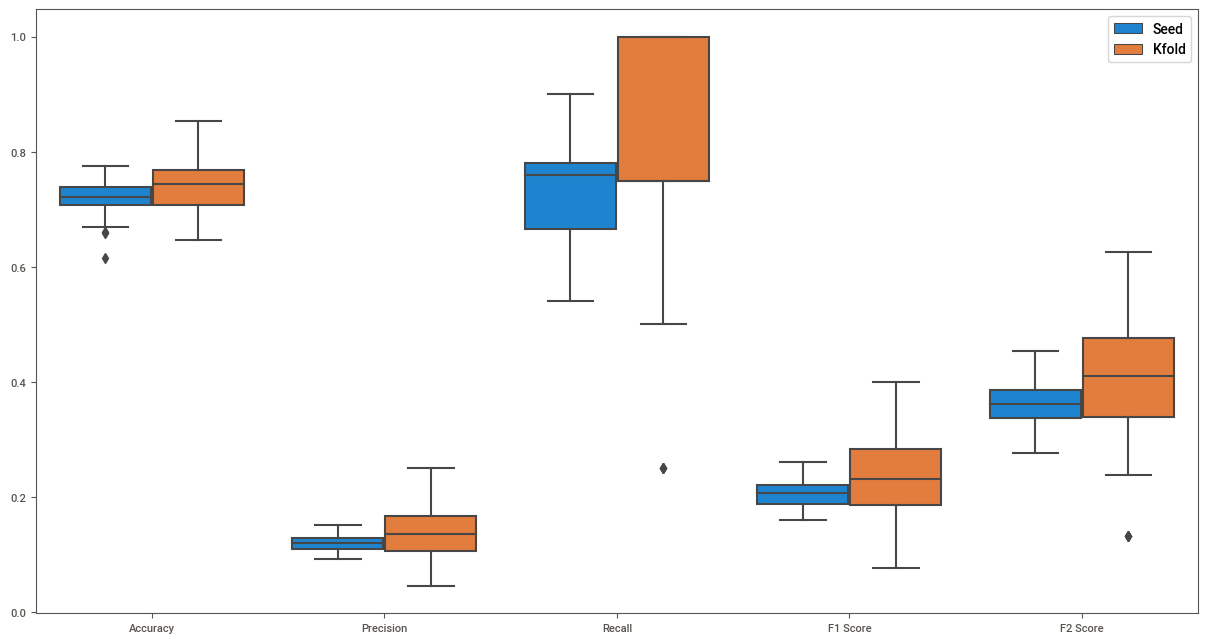

In [94]:
hue = ["Seed"] * 250 + ["Kfold"] * 250
plt.figure(figsize=(15, 8))
sns.boxplot(metric_labels, all_metrics, hue=hue)

## Comparación de modelos

C) Realizar la división de datos de la manera que considere más adecuada, teniendo en cuenta el análisis realizado en b), y comparar el desempeño de Random Forests y AdaBoost. Realizar una búsqueda de hiperparámetros para ambos modelos. Para esto, deberá elegirse una métrica de evaluación y justificar la elección. Reportar y analizar la matriz de confusión del mejor modelo, tanto para el caso de audios cantados como hablados.

1. Train/Test
2. Métrica
3. Busqueda hiperparámetros (Cuáles son los hiperparametros? Cual el espacio de búsqueda acotado?)
    * Random forest
    * Adaboost
4. Comparación de modelos
    * Matriz de confusión
5. Comprar ambos modelos
    * Cantados
    * Hablados

### Métrica

f1? o accuracy?

### Random Forests

Random Forest es una implementación de un algoritmo de *Bagging* que propone como estimadores base a **n_estimators** árboles de decisión. Cada árbol verá un subset distinto de los datos de entrenamiento (bagging, llamado **bootstrap** en los parámetros de sklearn). A su vez, para elegir el mejor split en cada nivel, se tienen en cuenta solo **max_features** atributos, seleccionados al azar. Estas 2 técnicas combinadas llevan a obtener árboles que sean distintos entre si y estén decorrelacionados, lo cual es bueno ya que si un árbol comete errores, probablemente otros no lo cometerán y se compensarán. Cuanto más independientes sean los árboles entre si más reduciremos la varianza.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)
print("Accuracy training : {:.3f}".format(rf.score(X_train, y_train)))
print("Accuracy test: {:.3f}".format(rf.score(X_test, y_test)))

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

parameters = {
    "n_estimators": range(50, 500, 10),
    "max_depth": range(1, 6),
    "bootstrap": [True, False],
}
clf = RandomizedSearchCV(
    RandomForestClassifier(max_features=None),
    parameters,
    n_jobs=10,
    scoring="accuracy",
    cv=5,
    n_iter=3,
)

clf.fit(X_train, y_train)
rf = clf.best_estimator_
print(clf.best_score_, clf.best_params_)
print("Accuracy training : {:.3f}".format(rf.score(X_train, y_train)))
print("Accuracy test: {:.3f}".format(rf.score(X_test, y_test)))

In [ ]:
pd.DataFrame(clf.cv_results_).sample(3)

In [ ]:
features = [x for i, x in enumerate(df_proc.columns) if i != 8]
feat_importances = rf.feature_importances_

sns.barplot(
    y=features,
    x=feat_importances,
    orient="h",
    order=reversed(np.array(features)[np.argsort(feat_importances)]),
)

### AdaBoost
En cada iteración construye un stump nuevo y le da más peso a las muestras que fueron clasificadas mal por el anterior stump. De esta manera, en cada iteración se intenta corregir los errores que cometió el anterior clasificador. Una vez armado el ensamble, cada stump tendrá asociado un peso en sus predicciones de acuerdo a qué tan bueno fue clasificando durante el entrenamiento. A continuación les dejamos un video explicativo del funcionamiento del algoritmo:

https://www.youtube.com/watch?v=LsK-xG1cLYA&ab_channel=StatQuestwithJoshStarmerStatQuestwithJoshStarmerVerified

La implementación de AdaBoost de sklearn nos provee de un meta-estimador para Boosting, al cual le podemos pasar cualquier estimador (por defecto usa un arbol de profundidad 1, un stump):

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html?highlight=adaboost#sklearn.ensemble.AdaBoostClassifier

Paper original:
https://web.stanford.edu/~hastie/Papers/samme.pdf 


In [ ]:
from sklearn.ensemble import AdaBoostClassifier

parameters = {"n_estimators": range(50, 200, 5), "learning_rate": np.arange(0, 1, 0.01)}
clf = RandomizedSearchCV(
    AdaBoostClassifier(), parameters, n_jobs=12, scoring="accuracy", cv=12, n_iter=3
)

clf.fit(X_train, y_train)
ab = clf.best_estimator_
print(clf.best_score_, clf.best_params_)
print("Accuracy training : {:.3f}".format(ab.score(X_train, y_train)))
print("Accuracy test: {:.3f}".format(ab.score(X_test, y_test)))

### Matriz de confusión

In [ ]:
cm = confusion_matrix(y_smote_test, y_smote_pred_test)
sns.heatmap(cm, cmap="Blues", annot=True, fmt="g")
plt.xlabel("Predicted")
plt.ylabel("True")

## Opcionales

**Opcionales** (dan puntos extra):

* Sumar al punto c) un modelo de perceptrón multicapa.
* Evaluar el desempeño de los modelos al utilizar el conjunto de atributos ComParE 2016.

### Compare2016 

https://pypi.org/project/opensmile/

D) Elegir y realizar alguno de los siguientes puntos:
    
    1. Evaluar la robustez del mejor modelo ante la presencia de ruido en los audios. Realizar una curva que muestre cómo varía una métrica de desempeño para distintas relaciones señal a ruido. El ruido utilizado puede ser sintético (gaussiano por ejemplo), o ruido ambiental. Algunas fuentes de ruido ambiental son:
        * https://github.com/qutsaivt/QUT-NOISE 
        * https://www.kaggle.com/aanhari/demand-dataset 
        * https://urbansounddataset.weebly.com/urbansound8k.html
        
    2. Evaluar el mejor modelo en audios grabados por los integrantes del grupo. Pueden evaluar la generalización ante distintas frases, pronunciaciones, intensidad de la emoción, etc…
   
    3. Calcular la media y desvío estándar de los atributos para cada actor, y normalizar los audios de cada actor utilizando esas estadísticas. Evaluar el desempeño del mejor modelo cuando es entrenado con los datos normalizados de esta manera (por hablante). Compare el desempeño con el modelo sin normalización. Explicar cuáles son las ventajas y desventajas de aplicar este preprocesamiento.
   

Ir por el segundo caso

- Cuanto grabamos
- Que grabamos
    - Idiomas
    - Distintas frases
- Que emociones?

**Referencias**

* An Introduction to Statistical Learning. Capítulos 2 (2.2.2), 5 (5.2) y 8 (8.2, 8.3.3, 8.3.4). 
* http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf
* Seni, Elder, “Ensemble Methods in Data Mining: Improving Accuracy Through Combining Predictions”, Morgan & Claypool, 2010. 
* https://doc.lagout.org/Others/Data 
* Mining/Ensemble Methods in Data Mining_ Improving Accuracy through Combining Predictions %5BSeni %26 Elder 2010-02-24%5D.pdf
* http://scott.fortmann-roe.com/docs/BiasVariance.html

**Material suplementario**:
Ejemplo de paper del tema: https://arxiv.org/abs/1912.10458 + Libro que pasaron
